In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import geopandas
import datetime as dt
import numpy as np
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from shapely.geometry import Polygon,box
from prepare_inversion import get_start_date_of_week
import matplotlib.dates as mdates

interp_region=[20,48,-126,-70]       # lat_min, lat_max, lon_min, lon_max
flexpart_region=[12,56,-134,-62]       # lat_min, lat_max, lon_min, lon_max



# 2. Fundamentals

## map of all obspack meas stations
see Atmo server, /home/pkuehn/software/obsPack_data.ipynb

## map of Gosat meas

In [2]:
# read data
gosat_path='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/RemoTeCv240/prep_footprints/high_res/scaled_weekly/high_res_scaled_footprints_20091001-20110331_2x2_weekly.nc'
gosat_data=xr.open_dataset(gosat_path)

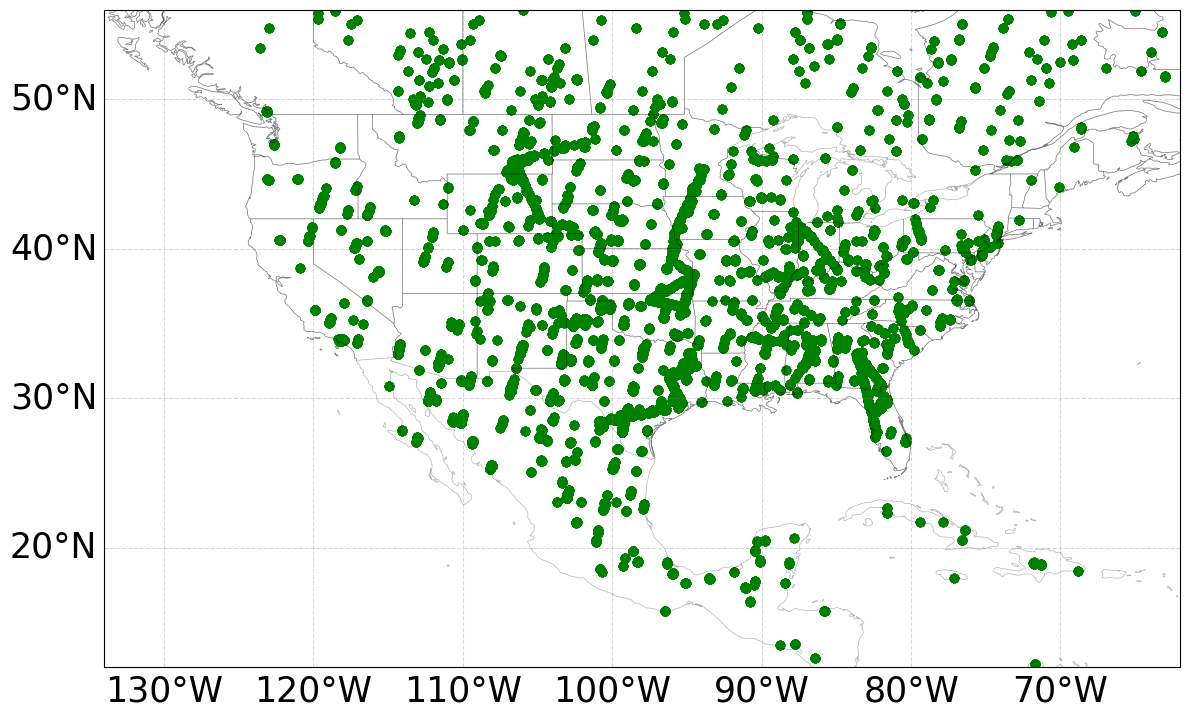

In [9]:
# just plot meas  during 2010
# looks nearly identical to 18 month plot
gosat_data_sel=gosat_data.where(gosat_data.release_day.dt.year==2010, drop=True)
fig, ax=plt.subplots(1,1,figsize=(12,8), subplot_kw={'projection': ccrs.PlateCarree()})
# gosat_data.xco2.plot(ax=ax)
ax.scatter(gosat_data_sel.release_lon, gosat_data_sel.release_lat, color='g')
ax.set_title('')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
# Add coastlines
ax.coastlines(linewidth=0.5, alpha=0.3)
# Add U.S. state borders
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
gl = ax.gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
ax.grid(c='lightgrey')
ax.set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
ax.set_ylim(12,56)
fig.tight_layout()
plt.show()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Fundamentals/gosat_meas_locations_2010.png')

# 3. Methods

## 3.1 map of study region

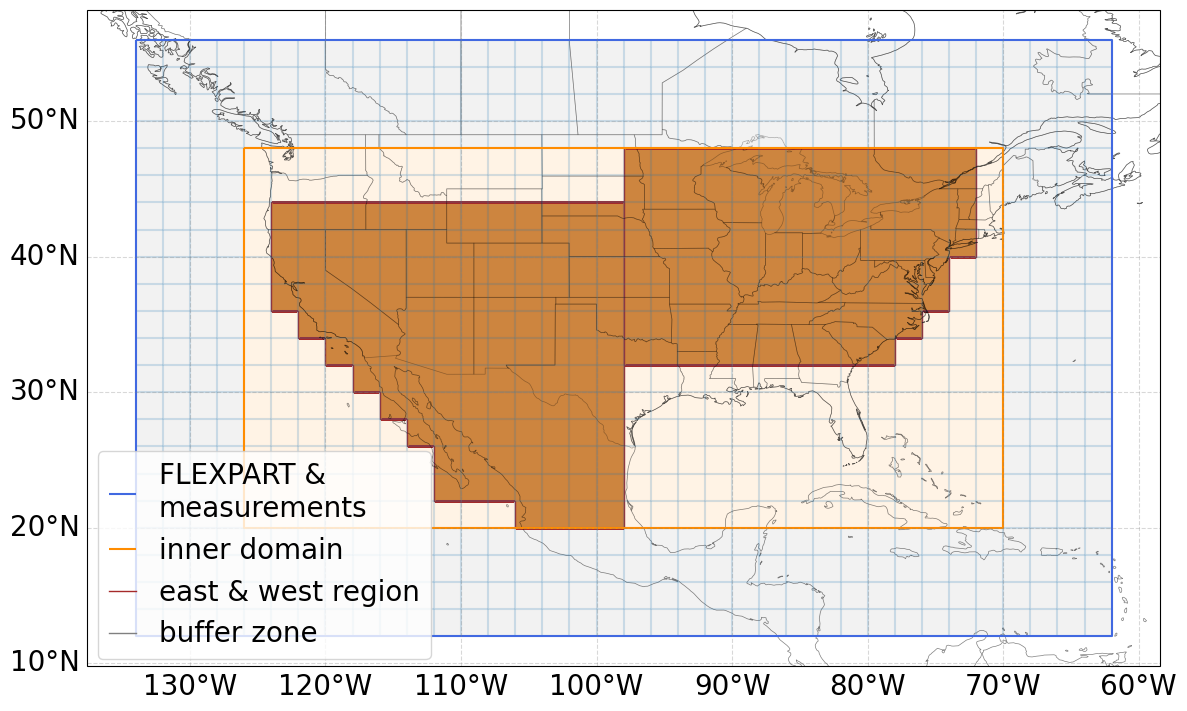

In [ ]:
lat_step=2
lon_step=2
interp_region=[20,48,-126,-70]       # lat_min, lat_max, lon_min, lon_max
flexpart_region=[12,56,-134,-62]       # lat_min, lat_max, lon_min, lon_max

lat=np.arange(flexpart_region[0],flexpart_region[1]+lat_step,lat_step)
lon=np.arange(-flexpart_region[2],-flexpart_region[3]-lon_step, -lon_step)

# read boudary file
gdf = geopandas.read_file("/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/east_west_region_boundaries.geojson")

geom_inv=[]
for i in range(0,len(lat)-1):
    for j in range(0, len(lon)-1):
        geom_inv.append(Polygon(zip([-lon[j+1],-lon[j],-lon[j],-lon[j+1]],[lat[i+1],lat[i+1],lat[i],lat[i]])))
geom_inv.append(Polygon(zip([interp_region[2],interp_region[3],interp_region[3],interp_region[2]],[interp_region[1],interp_region[1],interp_region[0],interp_region[0]])))
geom_inv.append(Polygon(zip([flexpart_region[2],flexpart_region[3],flexpart_region[3],flexpart_region[2]],[flexpart_region[1],flexpart_region[1],flexpart_region[0],flexpart_region[0]])))
# buffer zone
geom_inv.append(Polygon(zip([flexpart_region[2],flexpart_region[3],flexpart_region[3],flexpart_region[2]],[flexpart_region[1],flexpart_region[1],interp_region[1],interp_region[1]])))
geom_inv.append(Polygon(zip([flexpart_region[2],flexpart_region[3],flexpart_region[3],flexpart_region[2]],[interp_region[0],interp_region[0],flexpart_region[0],flexpart_region[0]])))
geom_inv.append(Polygon(zip([interp_region[3],flexpart_region[3],flexpart_region[3],interp_region[3]],[interp_region[1],interp_region[1],interp_region[0],interp_region[0]])))
geom_inv.append(Polygon(zip([interp_region[2],flexpart_region[2],flexpart_region[2],interp_region[2]],[interp_region[1],interp_region[1],interp_region[0],interp_region[0]])))



# create polygon
geom_byron = [Polygon(zip([-98,-73,-73,-98],[48,48,32,32])),        # dlat=16, dlon=25
              Polygon(zip([-123,-98,-98,-123],[44,44,20,20]))]      # dlat=24, dlon=25
gdf_byron=geopandas.GeoDataFrame({'Region':['east','west']},geometry=geom_byron)
gdf_inv=geopandas.GeoDataFrame({'Region':np.append(np.arange(0,len(geom_inv)-2),['Interp','FLEXPART_meas'])},geometry=geom_inv)
gdf_byron

fig, ax = plt.subplots(figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})
gdf_inv[:-2-4].boundary.plot(ax=ax,alpha=0.1)         # , label='inversion boxes'
gdf_inv[-1-4:-4].boundary.plot(ax=ax, color='royalblue', label='FLEXPART & \nmeasurements')
gdf_inv[-2-4:-1-4].boundary.plot(ax=ax, color='darkorange', label='inner domain')
gdf_inv[-2-4:-1-4].plot(ax=ax, color='darkorange', alpha=0.1)
gdf_inv[-4:].plot(ax=ax, color='grey', alpha=0.1)
# gdf_byron.boundary.plot(ax=ax, color='red', label='estimate byron boxes')

for _, row in gdf.iterrows():
    # ax.plot(*row.geometry.exterior.xy,transform=ccrs.PlateCarree(),color='brown', linewidth=1) # just for boundaries
    ax.add_geometries([row.geometry],crs=ccrs.PlateCarree(),facecolor='peru',edgecolor='brown',linewidth=1)
# ax.legend(bbox_to_anchor=(1.4, 1))

# Add coastlines
ax.coastlines(linewidth=0.5, alpha=0.5)
# ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
# Add U.S. state borders
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
gl = ax.gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
# gl.set_ylabel
gl.ylabel_style = {'size': 20}
# ax.set_xlim([-130,-60])
# ax.set_ylim([10,60])
ax.grid(c='lightgrey')
# ax.set_title(f'{lon_step}°x{lat_step}°')

# Add a custom line to the legend
custom_line = Line2D([0], [0], color='brown', lw=1, label='east & west region')
custom_line2 = Line2D([0], [0], color='grey', lw=1, label='buffer zone')

# Add the custom line to the existing legend
plt.legend(handles=[*ax.get_legend_handles_labels()[0], custom_line,custom_line2],handlelength=1, loc=(0.01, 0.01), fontsize=20)

# ax.legend()
fig.tight_layout()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Methods/study_region_map.png', dpi=300, bbox_inches='tight')

## 3.2/3.3 Distribution of assimilated measurements

In [ ]:
# plot weekly footprint sum
# insitu
insitu_path='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/insitu/prep_footprints/high_res/scaled_weekly/high_res_scaled_footprints_20091001-20110331_2x2_weekly.nc'
insitu_data=xr.open_dataset(insitu_path)
# gosat data
gosat_path='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/RemoTeCv240/prep_footprints/high_res/scaled_weekly/high_res_scaled_footprints_20091001-20110331_2x2_weekly.nc'
gosat_data=xr.open_dataset(gosat_path)

insitu_data

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


<xarray.Dataset> Size: 22GB
Dimensions:                          (time: 80, pointspec: 12395, latitude: 22,
                                      longitude: 36)
Coordinates:
  * longitude                        (longitude) float32 144B -133.0 ... -63.0
  * latitude                         (latitude) float32 88B 13.0 15.0 ... 55.0
  * time                             (time) datetime64[ns] 640B 2009-09-21 .....
  * pointspec                        (pointspec) int64 99kB 0 1 2 ... 764 765
    height                           float32 4B ...
Data variables: (12/19)
    spec001_mr                       (time, pointspec, latitude, longitude) float32 3GB ...
    release_num                      (pointspec) int64 99kB ...
    release_day                      (pointspec) datetime64[ns] 99kB ...
    release_time                     (pointspec) datetime64[ns] 99kB ...
    file                             (pointspec) <U44 2MB ...
    release_lat                      (pointspec) float64 99kB ...
    ...                               ...
    frac_remaining                   (pointspec) float64 99kB ...
    spec001_mr_scaled_1              (time, pointspec, latitude, longitude) float64 6GB ...
    spec001_mr_scaled_2              (time, pointspec, latitude, longitude) float64 6GB ...
    spec001_mr_scaled_3              (time, pointspec, latitude, longitude) float64 6GB ...
    TM5_IS_background                (pointspec) float32 50kB ...
    TM5_IS_co2                       (pointspec) float32 50kB ...
Attributes: (12/37)
    Conventions:            CF-1.6
    title:                  FLEXPART model output
    git:                    682d874 Tue Jul 2 10:56:37 2024 +0200
    source:                 Version 11.0 (2023-07-11) model output
    history:                2025-03-19 14:24 +0100  created by b382762 on l40...
    references:             Stohl et al., Atmos. Chem. Phys., 2005, doi:10.51...
    ...                     ...
    ind_source:             1
    ind_receptor:           2
    mquasilag:              0
    nested_output:          0
    sfc_only:               0
    linit_cond:             0

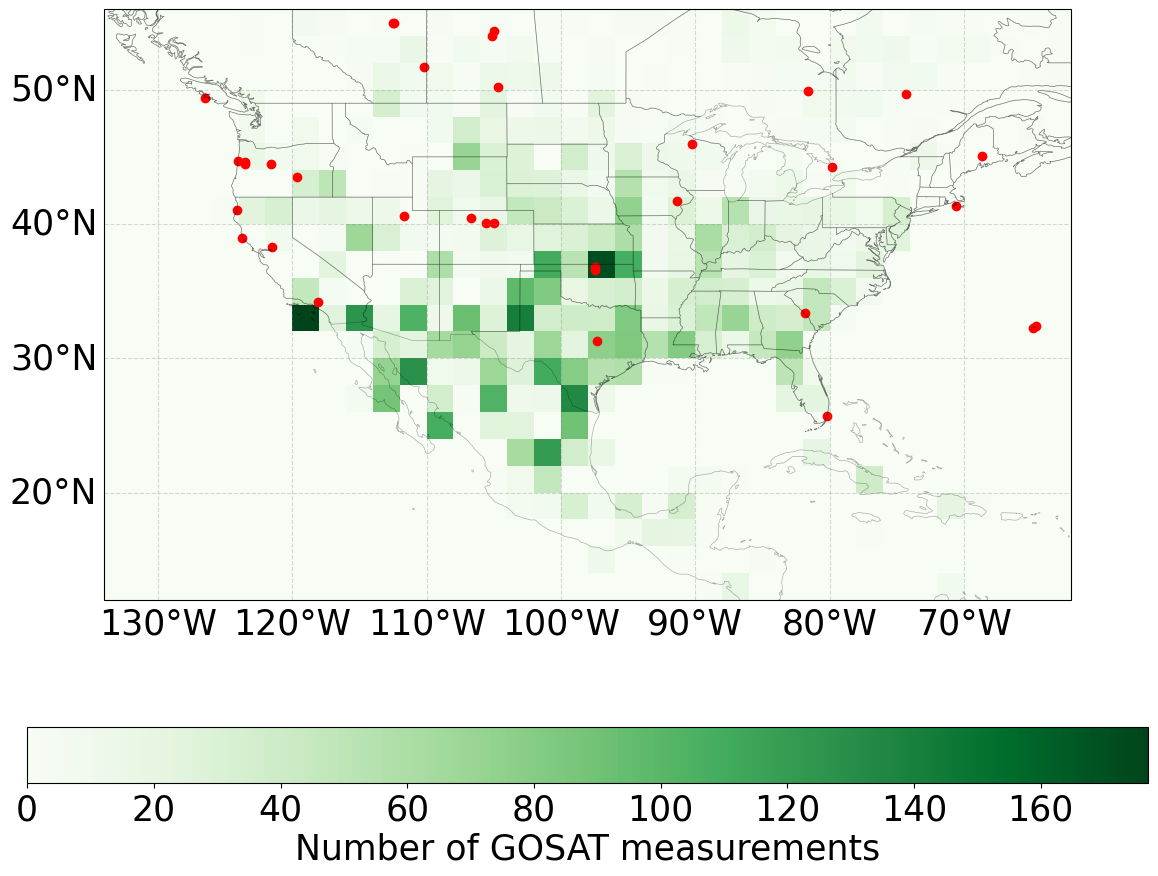

In [ ]:
# Combine lat and lon into a pandas DataFrame
insitu_loc_df = pd.DataFrame({
    'lat': insitu_data['release_lat'].round(2).values,  # round to four nachkommastellen to neglect very small differences
    'lon': insitu_data['release_lon'].round(2).values,
})

# Drop duplicates to keep only unique locations
insitu_loc_df_unique = insitu_loc_df.drop_duplicates()

# Define the bin edges
lat_centers = np.arange(flexpart_region[0]+1, flexpart_region[1], 2)
lon_centers = np.arange(flexpart_region[2]+1, flexpart_region[3], 2)

# # Digitize the lat/lon into bins
# lat_idx = np.digitize(, lat_bins) - 1
# lon_idx = np.digitize(, lon_bins) - 1

# For each lat, find nearest lat_center
lat_idx = np.abs(gosat_data.release_lat.values[..., np.newaxis] - lat_centers).argmin(axis=-1)
lon_idx = np.abs(gosat_data.release_lon.values[..., np.newaxis] - lon_centers).argmin(axis=-1)

# count
counts = np.zeros((len(lat_centers), len(lon_centers)), dtype=int)

for i, j in zip(lat_idx.ravel(), lon_idx.ravel()):
    counts[i, j] += 1
        
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Grid for plotting
lon_grid, lat_grid = np.meshgrid(lon_centers, lat_centers)

mesh = ax.pcolormesh(lon_grid, lat_grid, counts, cmap='Greens', shading='auto')
cbar=plt.colorbar(mesh, ax=ax, location='bottom')
cbar.set_label('Number of GOSAT measurements', fontsize=25)
cbar.ax.tick_params(labelsize=25)
# plot insitu meas location
ax.scatter(insitu_loc_df_unique.lon, insitu_loc_df_unique.lat, color='r')

# Add coastlines
ax.coastlines(linewidth=0.5, alpha=0.3)
# Add U.S. state borders
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
gl = ax.gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
ax.grid(c='lightgrey')
ax.set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
ax.set_ylim(12,56)
ax.tick_params(axis='both', labelsize='xx-large')
fig.tight_layout()
plt.show()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Methods/meas_distribution.png')

## 3.4 FLEXPART footprint examples

In [2]:
# read is footprint
f_data=xr.open_dataset('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/insitu/prep_footprints/high_res/scaled_hourly_total/high_res_scaled_footprints_2010_07.nc')[['spec001_mr', 'file']]
f_data=f_data.where(f_data.file=='co2_wbi_surface-pfp_1_allvalid-379magl.nc', drop=True)
f_data

<xarray.Dataset> Size: 235MB
Dimensions:     (pointspec: 19, time: 977, latitude: 44, longitude: 72)
Coordinates:
  * time        (time) datetime64[ns] 8kB 2010-06-21T06:00:00 ... 2010-07-31T...
  * longitude   (longitude) float32 288B -133.5 -132.5 -131.5 ... -63.5 -62.5
  * latitude    (latitude) float32 176B 12.5 13.5 14.5 15.5 ... 53.5 54.5 55.5
    height      float32 4B 30.0
  * pointspec   (pointspec) int64 152B 15 42 68 94 191 ... 614 639 708 733 756
Data variables:
    spec001_mr  (pointspec, time, latitude, longitude) float32 235MB 0.0 ... 0.0
    file        (pointspec) object 152B 'co2_wbi_surface-pfp_1_allvalid-379ma...
Attributes: (12/37)
    Conventions:            CF-1.6
    title:                  FLEXPART model output
    git:                    682d874 Tue Jul 2 10:56:37 2024 +0200
    source:                 Version 11.0 (2023-07-11) model output
    history:                2025-03-14 15:39 +0100  created by b382762 on l40...
    references:             Stohl et al., Atmos. Chem. Phys., 2005, doi:10.51...
    ...                     ...
    ind_source:             1
    ind_receptor:           2
    mquasilag:              0
    nested_output:          0
    sfc_only:               0
    linit_cond:             0

13


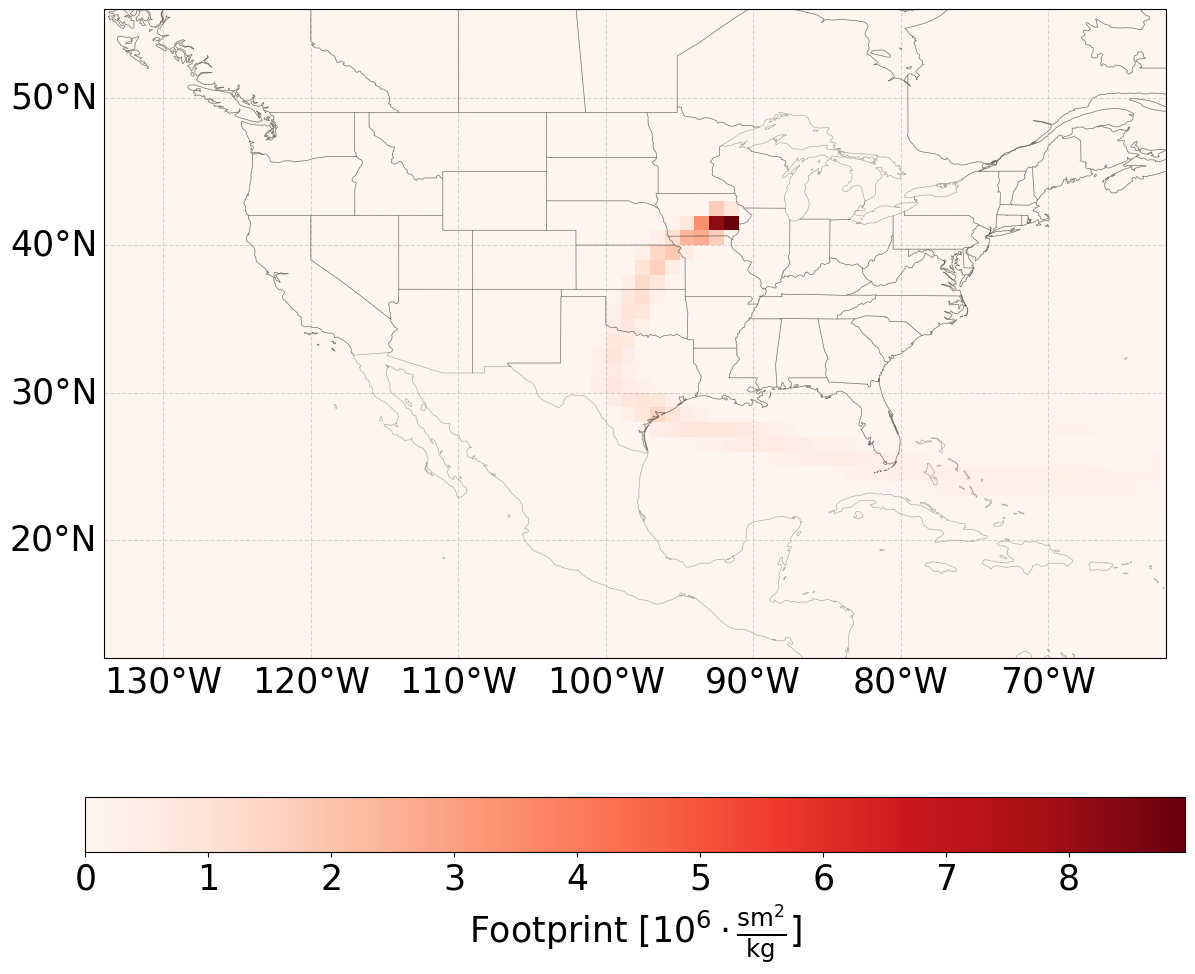

In [4]:
# i+=1
i=13
print(i)
temp=f_data[['spec001_mr']].isel(pointspec=i).sum(dim='time')/1e6

# plot is footprint
fig, ax=plt.subplots(1,1,figsize=(12,10), subplot_kw={'projection': ccrs.PlateCarree()})
plot=temp.spec001_mr.plot(ax=ax, cmap='Reds', cbar_kwargs={'location':'bottom', 'label':r'Footprint [$\mathrm{10^6 \cdot \frac{s m^2}{kg}}$]'})
plot.colorbar.ax.xaxis.label.set_size(25)
plot.colorbar.ax.tick_params(labelsize=25)
ax.set_title('')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
# Add coastlines
ax.coastlines(linewidth=0.5, alpha=0.3)
# Add U.S. state borders
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
gl = ax.gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
ax.grid(c='lightgrey')
ax.set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
ax.set_ylim(12,56)
fig.tight_layout()
plt.show()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Methods/insitu_footprint_example.png')

# 1,5, 9, 13

In [5]:
# read is footprint
gosat_data=xr.open_dataset('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/RemoTeCv240/prep_footprints/high_res/scaled_hourly_total/high_res_scaled_footprints_2010_07.nc')[['spec001_mr', 'release_lat', 'release_lon']]
# gosat_data=gosat_data.where(gosat_data.file=='co2_wbi_surface-pfp_1_allvalid-379magl.nc', drop=True)
# gosat_data.release_lat.values

41


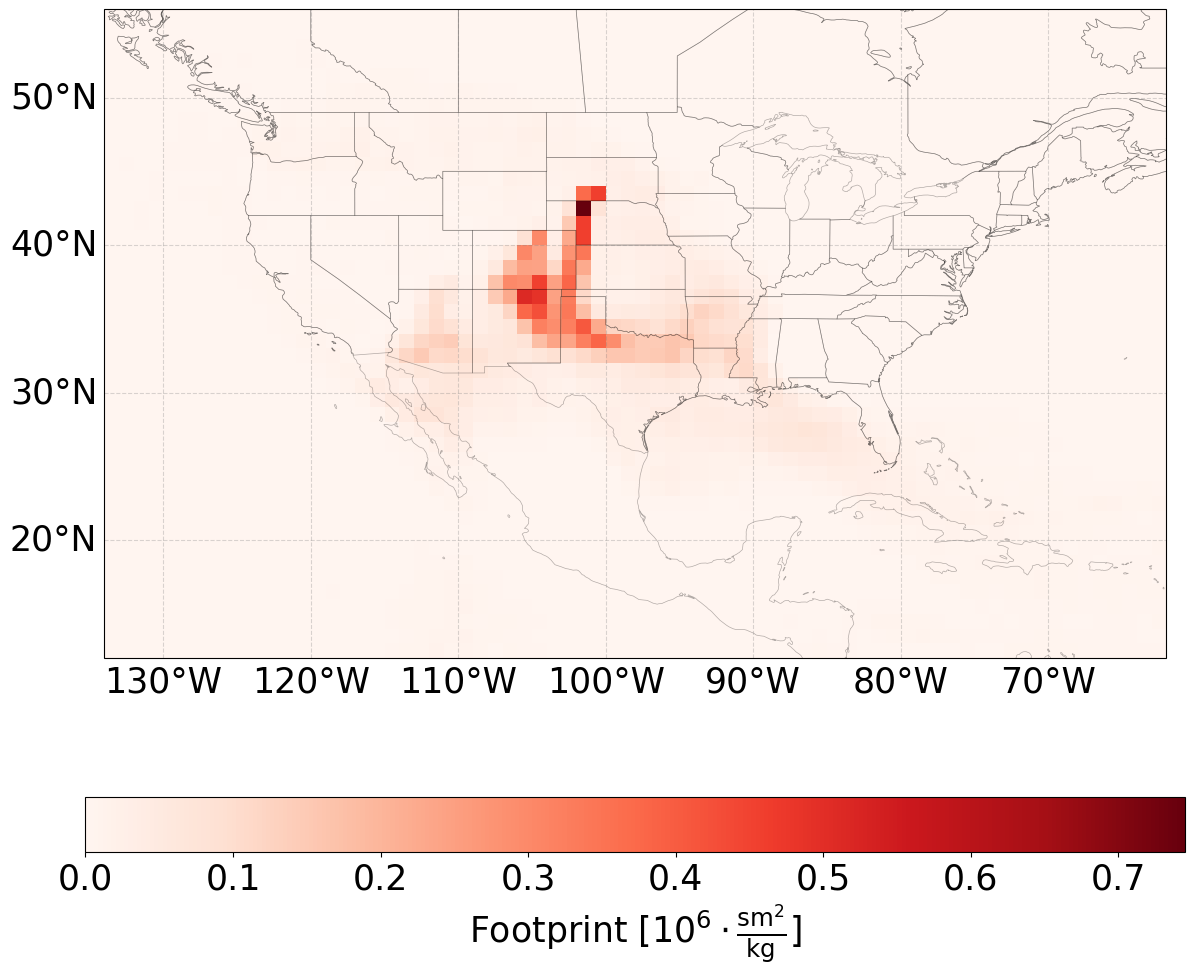

In [6]:
# i+=1
i=41
print(i)
temp=gosat_data.isel(pointspec=i).sum(dim='time')/1e6

# plot is footprint
fig, ax=plt.subplots(1,1,figsize=(12,10), subplot_kw={'projection': ccrs.PlateCarree()})
plot=temp.spec001_mr.plot(ax=ax, cmap='Reds', cbar_kwargs={'location':'bottom', 'label':r'Footprint [$\mathrm{10^6 \cdot \frac{s m^2}{kg}}$]'})
plot.colorbar.ax.xaxis.label.set_size(25)
plot.colorbar.ax.tick_params(labelsize=25)


ax.set_title('')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
# Add coastlines
ax.coastlines(linewidth=0.5, alpha=0.3)
# Add U.S. state borders
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
gl = ax.gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
ax.grid(c='lightgrey')
ax.set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
ax.set_ylim(12,56)
fig.tight_layout()
plt.show()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Methods/gosat_footprint_example.png')
# good i: 34,36,41 ...

### 3.4.1 FLEXPART simulation duration

0.21476401774909237
0.18210903506526746


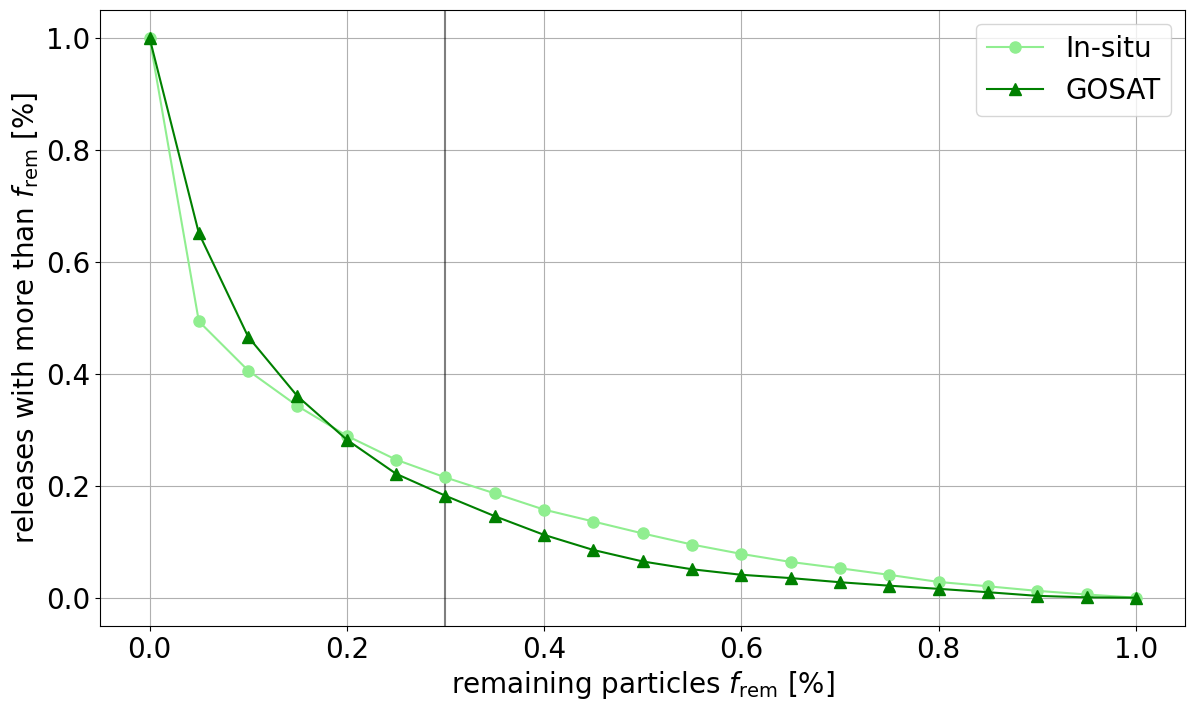

In [30]:
# plot 
start_date, end_date=dt.date(2009,10,1), dt.date(2011,3,31)
# insitu data
dir_path='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final'
is_data=xr.open_dataarray(f'{dir_path}/insitu/remaining_particles_{start_date.strftime("%Y%m%d")}_{end_date.strftime("%Y%m%d")}.nc')
# gosat data
gosat_data=xr.open_dataarray(f'{dir_path}/RemoTeCv240/remaining_particles_{start_date.strftime("%Y%m%d")}_{end_date.strftime("%Y%m%d")}.nc')
# gosat_data

f_rem=np.linspace(0,1,21)
is_n_remaining=[(is_data>=val).sum().item() for val in f_rem]
is_frac_remaining=is_n_remaining/(np.ones(len(is_n_remaining))*is_data.size)

gosat_n_remaining=[(gosat_data>=val).sum().item() for val in f_rem]
gosat_frac_remaining=gosat_n_remaining/(np.ones(len(gosat_n_remaining))*gosat_data.size)

fig, ax=plt.subplots(figsize=(14,8))
ax.vlines(0.3, -0.1,1.1, color='black', alpha=0.5)
ax.plot(f_rem, is_frac_remaining,marker='o', markersize=8,color='lightgreen', label='In-situ')
ax.plot(f_rem, gosat_frac_remaining, marker='^', markersize=8,color='green', label='GOSAT')
ax.grid()
ax.legend(fontsize=20)
ax.set_xlabel(r'remaining particles $f_\mathrm{rem}$ [%]', fontsize=20)     # (fractions of particles remaining in flexpart domain)
ax.set_ylabel(r'releases with more than $f_\mathrm{rem}$ [%]', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylim((-0.05, 1.05))
ax.set_xlim((-0.05, 1.05))
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Methods/fraction_remaining_particles.png')

print(is_frac_remaining[6])
print(gosat_frac_remaining[6])

### 3.4.2 FLEXPART background upper limit

In [ ]:
# Create pressure bins
bins = [0, 10, 20,50,70,80,90, 100,150, 200,300,400, 500,700, 800, 1000, 2000]  
bin_labels = pd.IntervalIndex.from_breaks(bins)

# select one day
data_dir='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/RemoTeCv240_with_h_res/2010_07/'
ds_list=[]
for date in pd.date_range(dt.date(2010,7,1), dt.date(2010,7,31)):
    dir_path=f'{data_dir}Release_{date.strftime("%Y%m%d")}/'
    print(date.strftime("%Y%m%d"))
    # get list of files 
    files=[dir_path+f for f in os.listdir(dir_path) if f.startswith('partoutput_')]

    # read files
    data=xr.open_mfdataset(files,combine='nested', concat_dim='time')

    # select first release, drop times where only nan values
    i=0
    num_parts=40000
    n_releases=int(data.particle.size/num_parts)

    for i in range(0,n_releases):        #n_releases
        data_sel=data.isel(particle=slice(i*num_parts, (i+1)*num_parts)).dropna(dim='time', how='all')
        # get pressure at release time
        ds=data_sel.sel(time=data_sel.time.max(), drop=True)[['prs']]/100    # Pa -> hPa

        # error if there is a nan in initial pressure
        if ds.prs.isnull().any().compute().item():
            print('ERROR: nan value in initial pressure!')
        else:
            # check if below 30m at some point
            # determine if at any point z<30m
            ds['below_30']=(data_sel.z<30).any(dim='time').compute()

            # add pressure as coordinate
            ds=ds.assign_coords(prs=ds.prs.compute())
            # # swap dims
            # ds=ds.swap_dims({'particle':'prs'})

            # group by pressure bins
            p_bins = pd.cut(ds["prs"], bins=bins, right=False, labels=bins[:-1])  # label is the pressure at the upper boundary 50 -> (50,100]
            # assign the bins as coordinates
            ds=ds.assign_coords(particle=p_bins)
            # goupby bins, count sumber of particles below 30m, and total number of particles released in that layer
            data_bin=ds.groupby('particle').sum().compute()
            data_bin['num']=ds.below_30.groupby('particle').count().compute()
            ds_list.append([date,i,data_bin.particle, data_bin.below_30,data_bin.below_30/data_bin.num])

df=pd.DataFrame(ds_list, columns=['date','release_num','bins','n_below_30','frac_below_30'])
df.to_pickle('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Methods/gosat_plim_contribution/frac_below_30.pkl')

In [59]:
df=pd.read_pickle('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Methods/gosat_plim_contribution/frac_below_30.pkl')
df['bins']=df['bins'].apply(lambda x: x.values)
df['n_below_30']=df['n_below_30'].apply(lambda x: x.values)
df['frac_below_30']=df['frac_below_30'].apply(lambda x: x.values)
# df

In [61]:
# have different shapes, pad arrays with nans
max_len = max(
    df['n_below_30'].apply(lambda x: len(x)).max(),
    df['frac_below_30'].apply(lambda x: len(x)).max(),
    df['bins'].apply(lambda x: len(x)).max()
)

def pad_array(arr, length, pad_value=0):
    arr = np.array(arr)
    if len(arr) < length:
        return np.pad(arr, (0, length - len(arr)), constant_values=pad_value)
    return arr

def pad_with_nan(arr, target_len):
    arr = np.array(arr, dtype=float)  # Ensure float to support np.nan
    if len(arr) < target_len:
        return np.pad(arr, (0, target_len - len(arr)), constant_values=np.nan)
    return arr

for col in ['bins', 'n_below_30', 'frac_below_30']:
    # df[col] = df[col].apply(lambda x: pad_array(x, max_len))
    df[col] = df[col].apply(lambda x: pad_with_nan(x, max_len))

grouped = df.groupby('date').agg({
    'bins': lambda x: np.nanmean(np.stack(x.to_list()), axis=0),
    'n_below_30': lambda x: np.nanmean(np.stack(x.to_list()), axis=0),
    'frac_below_30': lambda x: np.nanmean(np.stack(x.to_list()), axis=0),
}).reset_index()
grouped.bins[17]

array([   0.,   10.,   20.,   50.,   70.,   80.,   90.,  100.,  150.,
        200.,  300.,  400.,  500.,  700.,  800., 1000.])

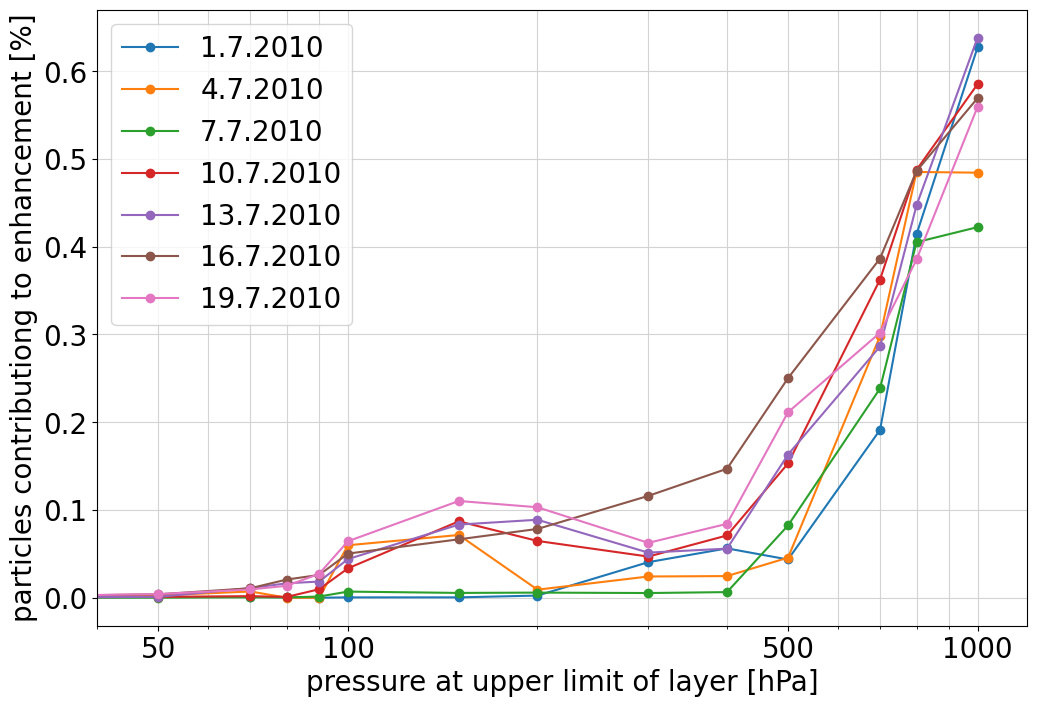

In [63]:
fig, ax=plt.subplots(figsize=(12,8))
for i in range(0,7):
    ax.plot(grouped.bins[3*i], grouped.frac_below_30[3*i], marker='o', label=f'{(3*i+1)}.7.2010')
ax.set_xscale('log')
ax.set_xlim(40,1200)
ax.legend(fontsize=20)
# Set custom ticks and labels
plt.xticks([50,100,500, 1000], ['50','100','500', '1000'])
ax.set_ylabel('particles contributiong to enhancement [%]', fontsize=20)
ax.set_xlabel(r'pressure at upper limit of layer [hPa]', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.grid(which='both', c='lightgrey')
fig.savefig(f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Methods/gosat_plim_contribution_mean.png')

## 3.5 TM5-4DVar prior flux examples

In [ ]:
prior_monthly=xr.open_dataset('/work/bb1170/RUN/b382762/data/TM5Inversion/glb3x2_20220413_new_gridded_flux/flux_1x1_prior_cut.nc') # in gC/m^2/day
# get nee flux in kgCO2/(m^2 s)
for col in ['CO2_flux_nee','CO2_flux_fire','CO2_flux_oce', 'CO2_flux_fos']:
    prior_monthly[col]=(prior_monthly[col]*44/12*1e-3/(24*60*60)).assign_attrs(units='kgCO2/(m^2 s)')
prior_monthly=prior_monthly*1e6     # kgCO2 -> mgCO2
prior_monthly.sel(time='2010-06').CO2_flux_nee

<xarray.DataArray 'CO2_flux_nee' (time: 1, latitude: 44, longitude: 72)> Size: 25kB
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.75347725e-09,  1.75347725e-09,  1.31517550e-07],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.75347725e-09,  1.75347725e-09,  1.31517550e-07],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  5.12992825e-07],
        ...,
        [-3.41870273e-03, -3.41870273e-03, -6.81990109e-03, ...,
         -3.32270639e-02, -3.32270639e-02, -4.26457397e-02],
        [-1.09989111e-02, -1.09989111e-02, -2.29425606e-02, ...,
         -2.35020275e-02, -2.35020275e-02, -2.67789498e-02],
        [-1.09989111e-02, -1.09989111e-02, -2.29425606e-02, ...,
         -2.35020275e-02, -2.35020275e-02, -2.67789498e-02]]])
Coordinates:
  * time       (time) datetime64[ns] 8B 2010-06-01
  * latitude   (latitude) float64 352B 12.5 13.5 14.5 15.5 ... 53.5 54.5 55.5
  * longitude  (longitude) float64 576B -133.5 -132.5 -131.5 ... -63.5 -62.5

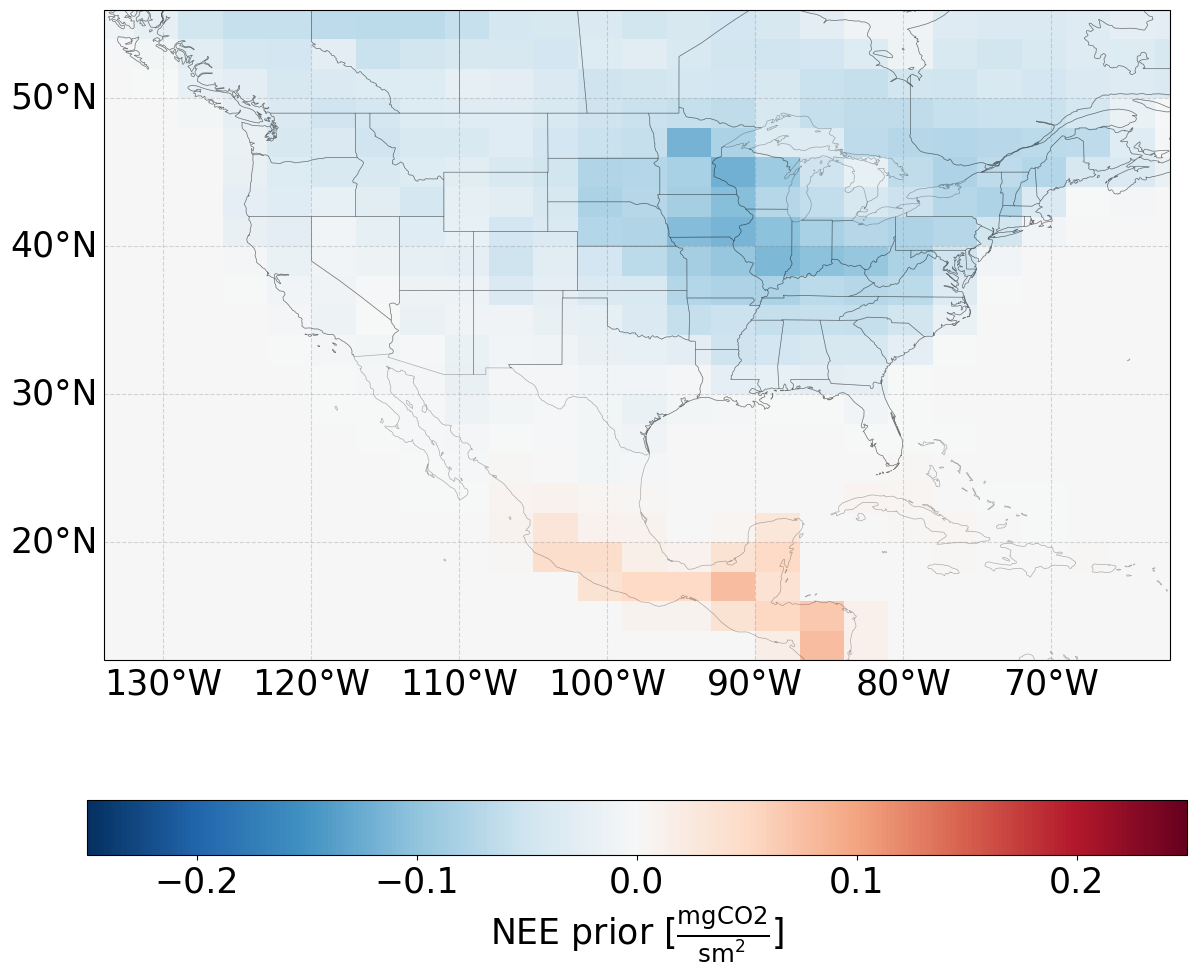

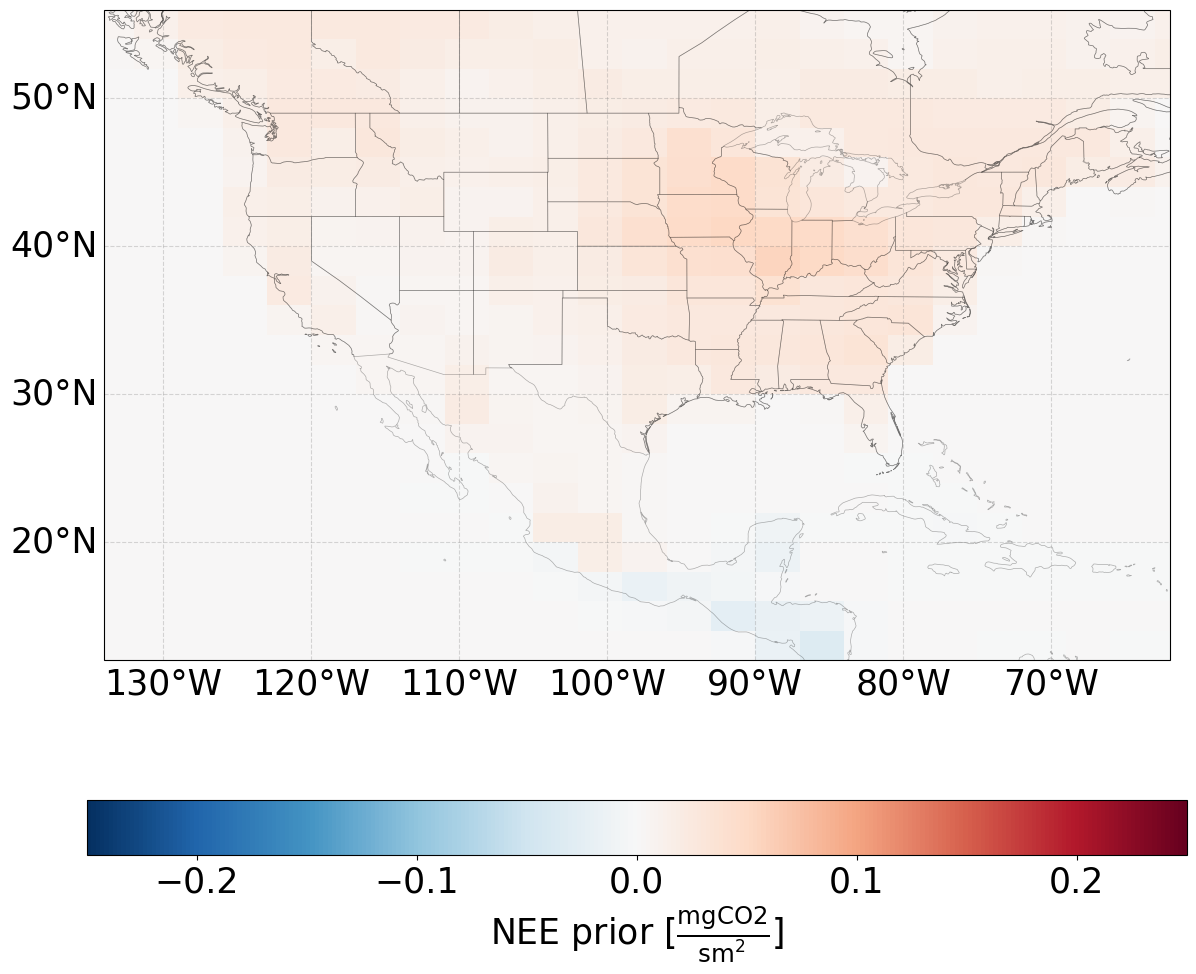

In [ ]:
# plot prior flux
for t_sel in ['2010-06','2010-12']:
    fig, ax=plt.subplots(1,1,figsize=(12,10), subplot_kw={'projection': ccrs.PlateCarree()})
    plot=prior_monthly.sel(time=t_sel).CO2_flux_nee.plot(ax=ax,vmin=-0.25,vmax=0.25, cmap='RdBu_r', cbar_kwargs={'location':'bottom', 'label':r'NEE prior [$\mathrm{\frac{mgCO2}{s m^2}}$]'})
    plot.colorbar.ax.xaxis.label.set_size(25)
    plot.colorbar.ax.tick_params(labelsize=25)
    ax.set_title('')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    # Add coastlines
    ax.coastlines(linewidth=0.5, alpha=0.3)
    # Add U.S. state borders
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
    gl = ax.gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 25}
    gl.ylabel_style = {'size': 25}
    ax.grid(c='lightgrey')
    ax.set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
    ax.set_ylim(12,56)
    fig.tight_layout()
    plt.show()
    fig.savefig(f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Methods/NEE_prior_example_{t_sel}.png')



# 4. Inversion setup tests

## 4.1 Spatial resolution of the state vector

In [4]:
# read data for 2x2 uncorrelated
start_date = dt.date(2009,10,1)
end_date = dt.date(2011,3,31)
bg_str = 'RemoTeC_2.4.0+IS'
gosat_err_val=1
meas_err_val=4
corr_str='no'
f_str='spec001_mr'

### 2x2°, no correlation

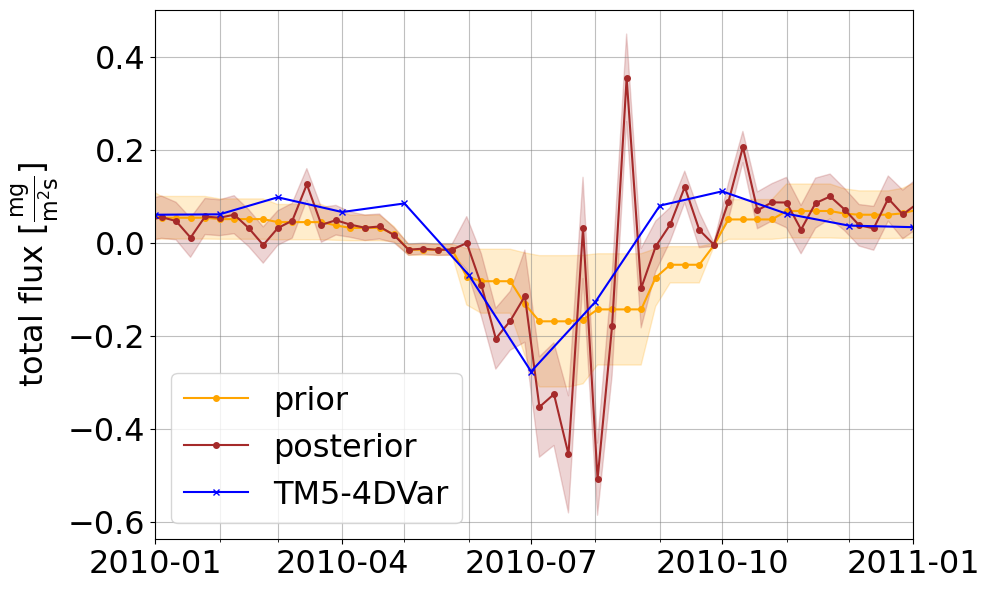

In [28]:
corr_str='no'
res=2

data_dir=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/{res}x{res}/{corr_str}_correlation/footprint_{f_str}/{gosat_err_val}ppm_gosat_meas_err/{meas_err_val}ppm_insitu_meas_err/'
inv_data=xr.open_dataset(f'{data_dir}/{start_date.strftime("%Y%m%d")}-{end_date.strftime("%Y%m%d")}_{bg_str}_bg.nc')

# read TM5-4DVar data
ref_flux=xr.open_dataset(f'/work/bb1170/RUN/b382762/data/TM5Inversion/glb3x2_20220413_new_gridded_flux/flux_{res}x{res}_{bg_str}_cut.nc')

# select location and time
# fontsize
f_size=23
sdir='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/43_93_example/'

# select region close to 37/-97, many gosat & is measurements
lat_sel, lon_sel = 43, -93
# t_sel=dt.datetime(2010,8,30,0,0,0)
t_sel=dt.datetime(2010,6,28,0,0,0)
# t_sel=dt.datetime(2010,6,21,0,0,0)

fig,ax=plt.subplots(figsize=(10,6), sharey=True)

inv_data_sel=inv_data.sel(latitude=lat_sel, longitude=lon_sel)*1e6
ref_flux_sel=ref_flux.sel(latitude=lat_sel, longitude=lon_sel)*1e6
# plot time series, prior & posterior
ms=4
ax.plot(inv_data_sel.time, inv_data_sel.TM5_prior_flux, c='orange',marker='o',markersize=ms, label='prior')
ax.fill_between(inv_data_sel.time, inv_data_sel.TM5_prior_flux-inv_data_sel.prior_uncertainty, inv_data_sel.TM5_prior_flux+inv_data_sel.prior_uncertainty, color='orange', alpha=0.2)
ax.plot(inv_data_sel.time, inv_data_sel.TM5_posterior_flux, c='brown', marker='o', markersize=ms, label='posterior')
ax.fill_between(inv_data_sel.time, inv_data_sel.TM5_posterior_flux-inv_data_sel.TM5_posterior_std, inv_data_sel.TM5_posterior_flux+inv_data_sel.TM5_posterior_std, color='brown', alpha=0.2)
# plot reference
ax.plot(ref_flux_sel.time, ref_flux_sel.total_flux,c='b', marker='x', markersize=ms, label='TM5-4DVar')
        
ax.legend(fontsize=23)
# ax.set_title(f'lat/lon: {lat_sel}/{lon_sel}')

ax.set_xlim(dt.date(2010,1,1), dt.date(2011,1,1))
ax.tick_params(labelleft=True, labelsize=23)
ax.set_ylabel(r'total flux [$\mathrm{\frac{mg}{m^2 s}}$]', fontsize=23)
# ax.set_ylim(-1.5e-7, 1.2e-7)

# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.grid(which='both', c='grey', alpha=0.5)
fig.tight_layout()
fig.savefig(f'{sdir}/2x2_no_corr_{lat_sel}{lon_sel}.png', dpi=300, bbox_inches='tight')


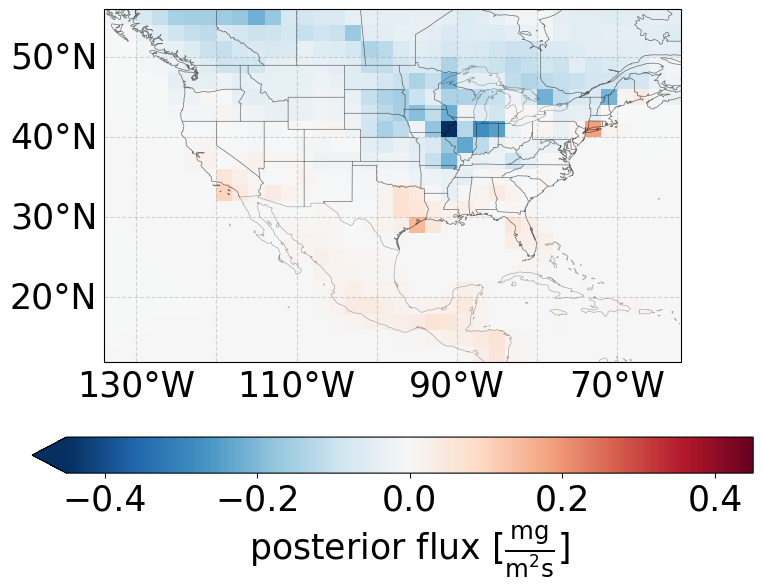

In [29]:
# plot time map 
# select specific time, plot map

inv_data_sel=inv_data.sel(time=t_sel)*1e6

fig, ax=plt.subplots(figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree()}) #1,1,, 
plot =inv_data_sel.TM5_posterior_flux.plot(ax=ax,vmin=-4.5e-1, vmax=4.5e-1,cmap='RdBu_r', 
                                           cbar_kwargs={'location':'bottom', 'label':r'posterior flux [$\mathrm{\frac{mg}{m^2 s}}$]'})
plot.colorbar.ax.xaxis.label.set_size(25)
plot.colorbar.ax.tick_params(labelsize=25)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
# Add coastlines
ax.coastlines(linewidth=0.5, alpha=0.3)
# Add U.S. state borders
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
gl = ax.gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
ax.grid(c='lightgrey')
ax.set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
ax.set_ylim(12,56)
ax.set_title('')
fig.tight_layout()
plt.show()
fig.savefig(f'{sdir}/2x2_no_corr_{t_sel.strftime("%Y%m%d")}_posterior_flux.png', dpi=300)

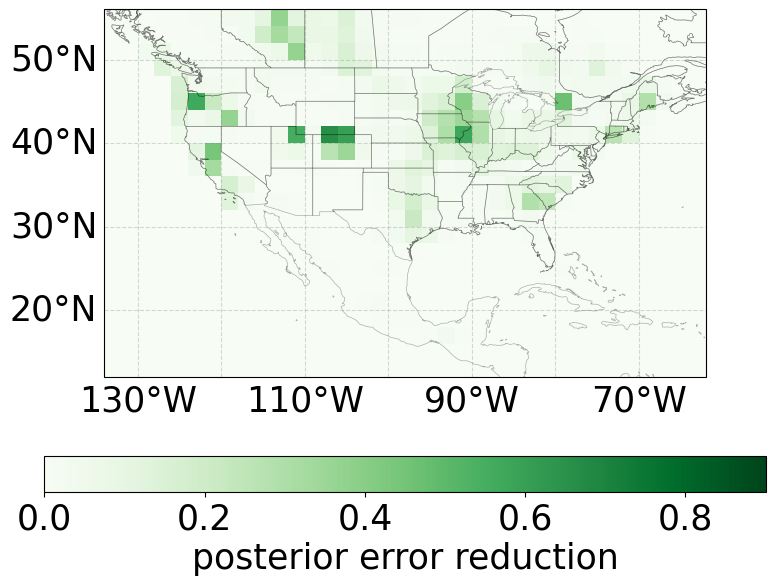

In [30]:
# plot posterior error reduction
# get covariance from uncertainty, using data for 2010
prior_cov_diag = inv_data.sel(time='2010').prior_uncertainty**2  # Diagonal of prior covariance (squared uncertainties)
posterior_cov_diag = inv_data.sel(time='2010').TM5_posterior_std**2  # Diagonal of posterior covariance (squared std)

# Posterior Uncertainty Reduction = 1-trace(posterior)/trace(prior)
posterior_uncertainty_reduction = 1 - ((posterior_cov_diag).sum(dim='time') / (prior_cov_diag).sum(dim='time'))
# plot
fig, ax=plt.subplots(figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree()}) #1,1,, 
plot =posterior_uncertainty_reduction.plot(ax=ax,vmin=0, vmax=0.9, cmap='Greens', cbar_kwargs={'location':'bottom', 'label':r'posterior error reduction'})

# Add coastlines
ax.coastlines(linewidth=0.5, alpha=0.3)
# Add U.S. state borders
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
gl = ax.gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
plot.colorbar.ax.xaxis.label.set_size(25)
plot.colorbar.ax.tick_params(labelsize=25)
ax.grid(c='lightgrey')
ax.set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
ax.set_ylim(12,56)
ax.set_title('')
fig.tight_layout()
plt.show()
fig.savefig(f'{sdir}/2x2_{corr_str}_corr_{t_sel.strftime("%Y%m%d")}_posterior_error_red.png', dpi=300)


### 4x4°, no correlation

In [ ]:
# für 4x4 daten
# now same plots with correlation
corr_str='no'
res=4
data_dir=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/{res}x{res}/{corr_str}_correlation/footprint_{f_str}/{gosat_err_val}ppm_gosat_meas_err/{meas_err_val}ppm_insitu_meas_err/'
inv_data=xr.open_dataset(f'{data_dir}/{start_date.strftime("%Y%m%d")}-{end_date.strftime("%Y%m%d")}_{bg_str}_bg.nc')
# read TM5-4DVar data
ref_flux=xr.open_dataset(f'/work/bb1170/RUN/b382762/data/TM5Inversion/glb3x2_20220413_new_gridded_flux/flux_{res}x{res}_{bg_str}_cut.nc')


# select location and time

# select region close to 37/-97, many gosat & is measurements
lat_sel, lon_sel = 43, -93
# lat_sel, lon_sel = 39, -95
# t_sel=dt.datetime(2010,8,30,0,0,0)

# t_sel=dt.datetime(2010,6,21,0,0,0)
t_sel=dt.datetime(2010,6,28,0,0,0)


inv_data_sel=inv_data.sel(latitude=lat_sel, longitude=lon_sel, method='nearest')*1e6
ref_flux_sel=ref_flux.sel(latitude=lat_sel, longitude=lon_sel, method='nearest')*1e6
lat_sel = inv_data_sel.latitude.item()
lon_sel = inv_data_sel.longitude.item()

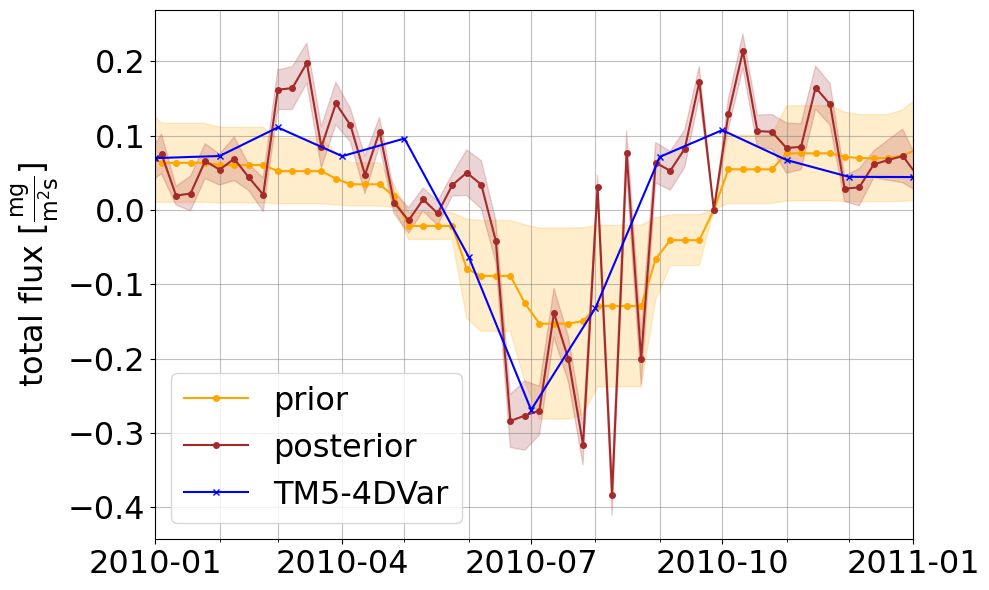

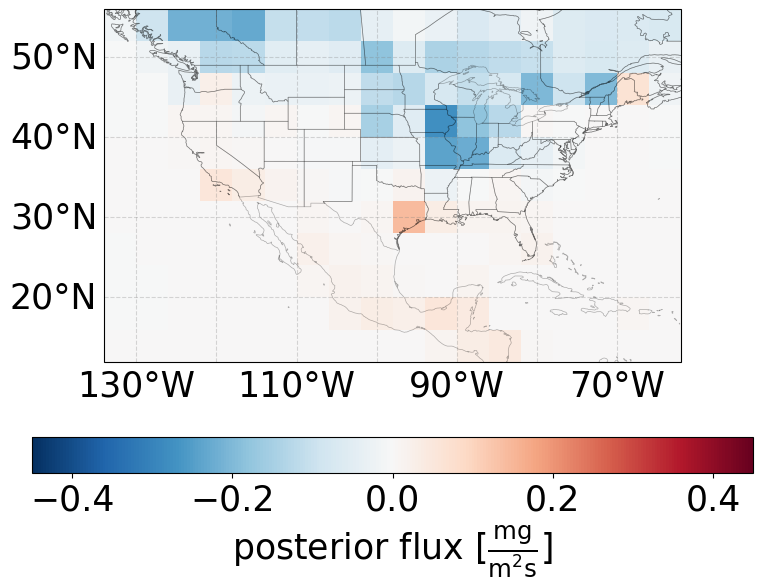

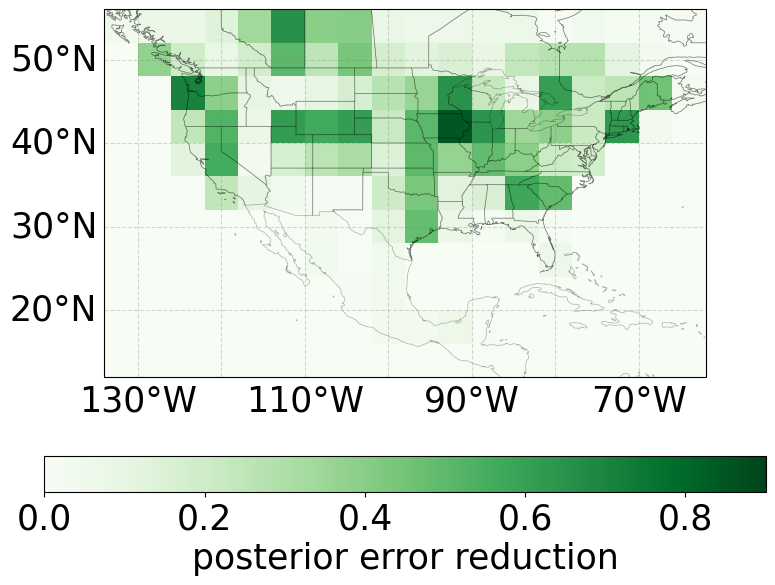

In [ ]:
fig,ax=plt.subplots(figsize=(10,6), sharey=True)

# plot time series, prior & posterior
ms=4
ax.plot(inv_data_sel.time, inv_data_sel.TM5_prior_flux, c='orange',marker='o',markersize=ms, label='prior')
ax.fill_between(inv_data_sel.time, inv_data_sel.TM5_prior_flux-inv_data_sel.prior_uncertainty, inv_data_sel.TM5_prior_flux+inv_data_sel.prior_uncertainty, color='orange', alpha=0.2)
ax.plot(inv_data_sel.time, inv_data_sel.TM5_posterior_flux, c='brown', marker='o', markersize=ms, label='posterior')
ax.fill_between(inv_data_sel.time, inv_data_sel.TM5_posterior_flux-inv_data_sel.TM5_posterior_std, inv_data_sel.TM5_posterior_flux+inv_data_sel.TM5_posterior_std, color='brown', alpha=0.2)
# plot reference
ax.plot(ref_flux_sel.time, ref_flux_sel.total_flux,c='b', marker='x', markersize=ms, label='TM5-4DVar')
        
# ax.legend(fontsize=23)
# ax.set_title(f'lat/lon: {lat_sel}/{lon_sel}')

ax.set_xlim(dt.date(2010,1,1), dt.date(2011,1,1))
ax.legend(fontsize=23)
ax.tick_params(labelleft=True, labelsize=23)
ax.set_ylabel(r'total flux [$\mathrm{\frac{mg}{m^2 s}}$]', fontsize=23)
# ax.set_ylim(-1.5e-1, 1.2e-1)

# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.grid(which='both', c='grey', alpha=0.5)
fig.tight_layout()
fig.savefig(f'{sdir}/{res}x{res}_{corr_str}_corr_{lat_sel}{lon_sel}.png', dpi=300, bbox_inches='tight')

# plot time map 
# select specific time, plot map

inv_data_sel=inv_data.sel(time=t_sel)*1e6

fig, ax=plt.subplots(figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree()}) #1,1,, 
plot =inv_data_sel.TM5_posterior_flux.plot(ax=ax,vmin=-4.5e-1, vmax=4.5e-1,cmap='RdBu_r', cbar_kwargs={'location':'bottom', 'label':r'posterior flux [$\mathrm{\frac{mg}{m^2 s}}$]'})
cbar = plot.colorbar
cbar.ax.xaxis.label.set_size(12)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
# Add coastlines
ax.coastlines(linewidth=0.5, alpha=0.3)
# Add U.S. state borders
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
gl = ax.gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
plot.colorbar.ax.xaxis.label.set_size(25)
plot.colorbar.ax.tick_params(labelsize=25)
ax.grid(c='lightgrey')
ax.set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
ax.set_ylim(12,56)
ax.set_title('')
fig.tight_layout()
plt.show()
fig.savefig(f'{sdir}/{res}x{res}_{corr_str}_corr_{t_sel.strftime("%Y%m%d")}_posterior_flux.png', dpi=300, bbox_inches='tight')

# plot posterior error reduction
# get covariance from uncertainty, using data for 2010
prior_cov_diag = inv_data.sel(time='2010').prior_uncertainty**2  # Diagonal of prior covariance (squared uncertainties)
posterior_cov_diag = inv_data.sel(time='2010').TM5_posterior_std**2  # Diagonal of posterior covariance (squared std)

# Posterior Uncertainty Reduction = 1-trace(posterior)/trace(prior)
posterior_uncertainty_reduction = 1 - ((posterior_cov_diag).sum(dim='time') / (prior_cov_diag).sum(dim='time'))
# plot
fig, ax=plt.subplots(figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree()}) #1,1,, 
plot =posterior_uncertainty_reduction.plot(ax=ax,vmin=0, vmax=0.9, cmap='Greens', cbar_kwargs={'location':'bottom', 'label':r'posterior error reduction'})
cbar = plot.colorbar
cbar.ax.xaxis.label.set_size(12)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
# Add coastlines
ax.coastlines(linewidth=0.5, alpha=0.3)
# Add U.S. state borders
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
gl = ax.gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
plot.colorbar.ax.xaxis.label.set_size(25)
plot.colorbar.ax.tick_params(labelsize=25)
ax.grid(c='lightgrey')
ax.set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
ax.set_ylim(12,56)
ax.set_title('')
fig.tight_layout()
plt.show()
fig.savefig(f'{sdir}/{res}x{res}_{corr_str}_corr_{t_sel.strftime("%Y%m%d")}_posterior_error_red.png', dpi=300, bbox_inches='tight')


## 4.2 Correlation, 2x2 with correlation

In [31]:
# now same plots with correlation
corr_str='with'
res=2

data_dir=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/{res}x{res}/{corr_str}_correlation/footprint_{f_str}/{gosat_err_val}ppm_gosat_meas_err/{meas_err_val}ppm_insitu_meas_err/'
inv_data=xr.open_dataset(f'{data_dir}/{start_date.strftime("%Y%m%d")}-{end_date.strftime("%Y%m%d")}_{bg_str}_bg.nc')


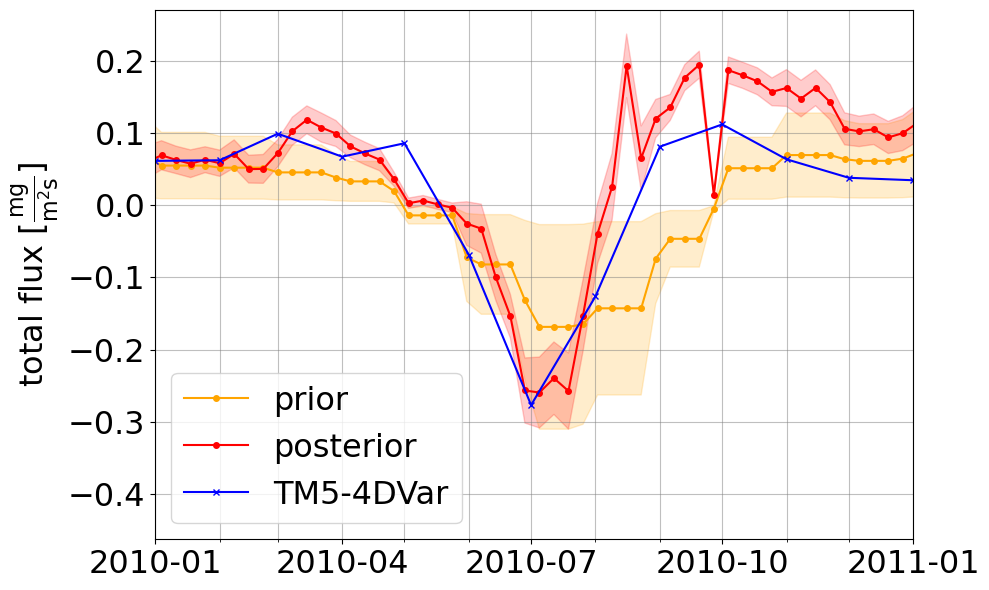

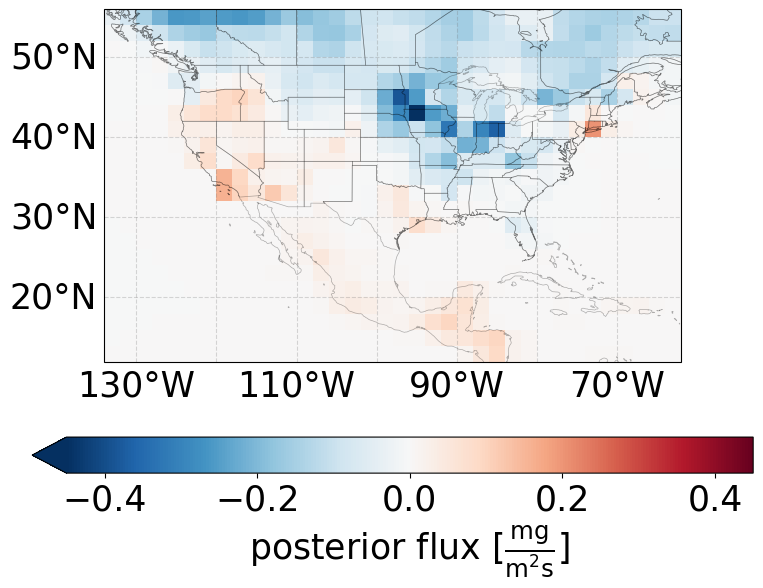

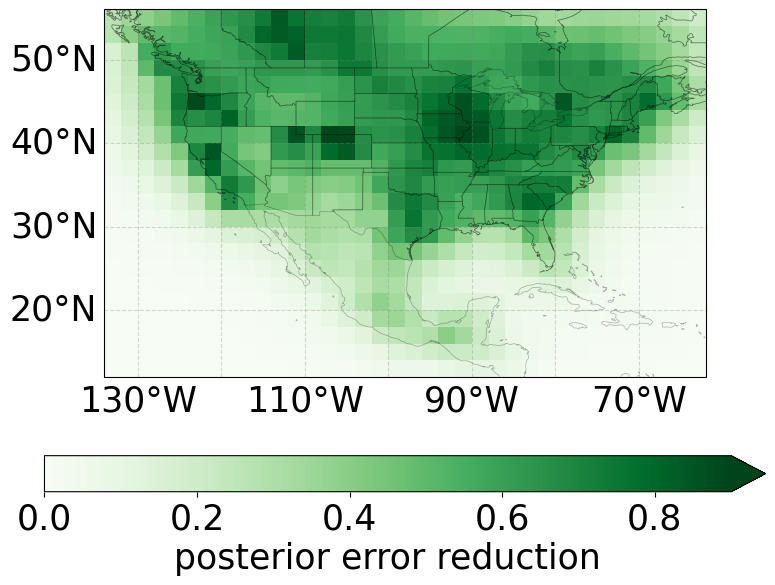

In [35]:
# select location and time
sdir='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/43_93_example/'
# select region close to 37/-97, many gosat & is measurements
lat_sel, lon_sel = 43, -93
# t_sel=dt.datetime(2010,8,30,0,0,0)
t_sel=dt.datetime(2010,6,28,0,0,0)
# t_sel=dt.datetime(2010,6,21,0,0,0)

fig,ax=plt.subplots(figsize=(10,6), sharey=True)

inv_data_sel=inv_data.sel(latitude=lat_sel, longitude=lon_sel)*1e6
ref_flux_sel=ref_flux.sel(latitude=lat_sel, longitude=lon_sel)*1e6
# plot time series, prior & posterior
ms=4
ax.plot(inv_data_sel.time, inv_data_sel.TM5_prior_flux, c='orange',marker='o',markersize=ms, label='prior')
ax.fill_between(inv_data_sel.time, inv_data_sel.TM5_prior_flux-inv_data_sel.prior_uncertainty, inv_data_sel.TM5_prior_flux+inv_data_sel.prior_uncertainty, color='orange', alpha=0.2)
ax.plot(inv_data_sel.time, inv_data_sel.TM5_posterior_flux, c='r', marker='o', markersize=ms, label='posterior')
ax.fill_between(inv_data_sel.time, inv_data_sel.TM5_posterior_flux-inv_data_sel.TM5_posterior_std, inv_data_sel.TM5_posterior_flux+inv_data_sel.TM5_posterior_std, color='r', alpha=0.2)
# plot reference
ax.plot(ref_flux_sel.time, ref_flux_sel.total_flux,c='b', marker='x', markersize=ms, label='TM5-4DVar')
        
# ax.legend(fontsize='large')
# ax.set_title(f'lat/lon: {lat_sel}/{lon_sel}')

ax.set_xlim(dt.date(2010,1,1), dt.date(2011,1,1))
ax.legend(fontsize=23)
ax.tick_params(labelleft=True, labelsize=23)
# ax.tick_params(labelleft=True, size=23)
ax.set_ylabel(r'total flux [$\mathrm{\frac{mg}{m^2 s}}$]', fontsize=23)
# ax.set_ylim(-1.5e-1, 1.2e-1)

# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.grid(which='both', c='grey', alpha=0.5)
fig.tight_layout()
fig.savefig(f'{sdir}/2x2_{corr_str}_corr_{lat_sel}{lon_sel}.png', dpi=300, bbox_inches='tight')

# plot time map 
# select specific time, plot map

inv_data_sel=inv_data.sel(time=t_sel)*1e6

fig, ax=plt.subplots(figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree()}) #1,1,, 
plot =inv_data_sel.TM5_posterior_flux.plot(ax=ax,vmin=-4.5e-1, vmax=4.5e-1,cmap='RdBu_r', cbar_kwargs={'location':'bottom', 'label':r'posterior flux [$\mathrm{\frac{mg}{m^2 s}}$]'})
cbar = plot.colorbar
cbar.ax.xaxis.label.set_size(12)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
# Add coastlines
ax.coastlines(linewidth=0.5, alpha=0.3)
# Add U.S. state borders
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
gl = ax.gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
plot.colorbar.ax.xaxis.label.set_size(25)
plot.colorbar.ax.tick_params(labelsize=25)
ax.grid(c='lightgrey')
ax.set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
ax.set_ylim(12,56)
ax.set_title('')
fig.tight_layout()
plt.show()
fig.savefig(f'{sdir}/2x2_{corr_str}_corr_{t_sel.strftime("%Y%m%d")}_posterior_flux.png', dpi=300, bbox_inches='tight')

# plot posterior error reduction
# get covariance from uncertainty, using data for 2010
prior_cov_diag = inv_data.sel(time='2010').prior_uncertainty**2  # Diagonal of prior covariance (squared uncertainties)
posterior_cov_diag = inv_data.sel(time='2010').TM5_posterior_std**2  # Diagonal of posterior covariance (squared std)

# Posterior Uncertainty Reduction = 1-trace(posterior)/trace(prior)
posterior_uncertainty_reduction = 1 - ((posterior_cov_diag).sum(dim='time') / (prior_cov_diag).sum(dim='time'))
# plot
fig, ax=plt.subplots(figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree()}) #1,1,, 
plot =posterior_uncertainty_reduction.plot(ax=ax,vmin=0, vmax=0.9, cmap='Greens', cbar_kwargs={'location':'bottom', 'label':r'posterior error reduction'})
cbar = plot.colorbar
cbar.ax.xaxis.label.set_size(12)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
# Add coastlines
ax.coastlines(linewidth=0.5, alpha=0.3)
# Add U.S. state borders
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
gl = ax.gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
plot.colorbar.ax.xaxis.label.set_size(25)
plot.colorbar.ax.tick_params(labelsize=25)
ax.grid(c='lightgrey')
ax.set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
ax.set_ylim(12,56)
ax.set_title('')
fig.tight_layout()
plt.show()
fig.savefig(f'{sdir}/2x2_{corr_str}_corr_{t_sel.strftime("%Y%m%d")}_posterior_error_red.png')


### Averaging Kernel section

In [ ]:
# read data
no_corr_flux=xr.open_dataset('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/no_correlation/footprint_spec001_mr/1ppm_gosat_meas_err/2ppm_insitu_meas_err/20091001-20110331_RemoTeC_2.4.0+IS_bg.nc')
no_corr_path='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/no_correlation/footprint_spec001_mr/1ppm_gosat_meas_err/2ppm_insitu_meas_err/20091001-20110331_RemoTeC_2.4.0+IS_bg_ak_post_cov.nc'
no_corr_ak=xr.open_dataset(no_corr_path)
corr_path='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/with_correlation/footprint_spec001_mr/1ppm_gosat_meas_err/2ppm_insitu_meas_err/20091001-20110331_RemoTeC_2.4.0+IS_bg_ak_post_cov.nc'
corr_ak=xr.open_dataset(corr_path)
nlat=int((flexpart_region[1]-flexpart_region[0])/2)
nlon=int((flexpart_region[3]-flexpart_region[2])/2)
nlat*nlon

792

In [ ]:
# Create all combinations (Cartesian product)
import itertools
combinations = list(itertools.product(no_corr_flux.time.values, no_corr_flux.latitude.values, no_corr_flux.longitude.values))

# Create MultiIndex
index_x = pd.MultiIndex.from_tuples(combinations, names=['time_x', 'latitude_x', 'longitude_x'])
index_y = pd.MultiIndex.from_tuples(combinations, names=['time_y', 'latitude_y', 'longitude_y'])

# # assign multiindex to coordinates
ak_data_no_corr=no_corr_ak.TM5_averaging_kernel.assign_coords(x=index_x,y=index_y)
ak_data_with_corr=corr_ak.TM5_averaging_kernel.assign_coords(x=index_x,y=index_y)
# ak_data=ak_data.unstack('x').unstack('y')
# print(multi_index_y)
# ak_data_no_corr

In [ ]:
lat_slice=slice(43-2,43+2)
lon_slice=slice(-126,-70)
ticks_loc=np.arange(0,3*28,step=14)
# plot for some different time steps
# for time_slice in ['2010-05-17','2010-06-07','2010-06-28','2010-07-12','2010-08-02','2010-12-06']:
# time_slice='2010-06-28'
time_slice='2010-06-28'

# select time step
ak_data_no_corr_sel=ak_data_no_corr.sel(time_x=time_slice,time_y=time_slice).unstack('y').unstack('x')   #, 
ak_data_with_corr_sel=ak_data_with_corr.sel(time_x=time_slice,time_y=time_slice).unstack('y').unstack('x')   #, 
# select inner region
ak_data_no_corr_sel=ak_data_no_corr_sel.sel(latitude_x=lat_slice,latitude_y=lat_slice,longitude_x=lon_slice,longitude_y=lon_slice)
ak_data_with_corr_sel=ak_data_with_corr_sel.sel(latitude_x=lat_slice,latitude_y=lat_slice,longitude_x=lon_slice,longitude_y=lon_slice)
# ak_data_no_corr_sel


print(ak_data_no_corr_sel.stack(x=("latitude_x", "longitude_x"), y=("latitude_y", "longitude_y")).values.trace())
print(ak_data_with_corr_sel.stack(x=("latitude_x", "longitude_x"), y=("latitude_y", "longitude_y")).values.trace())

10.780665046793166
5.2888627098660175


-0.09940329543029572 1.5617050076091294
-0.14634397916841568 1.5617050076091294


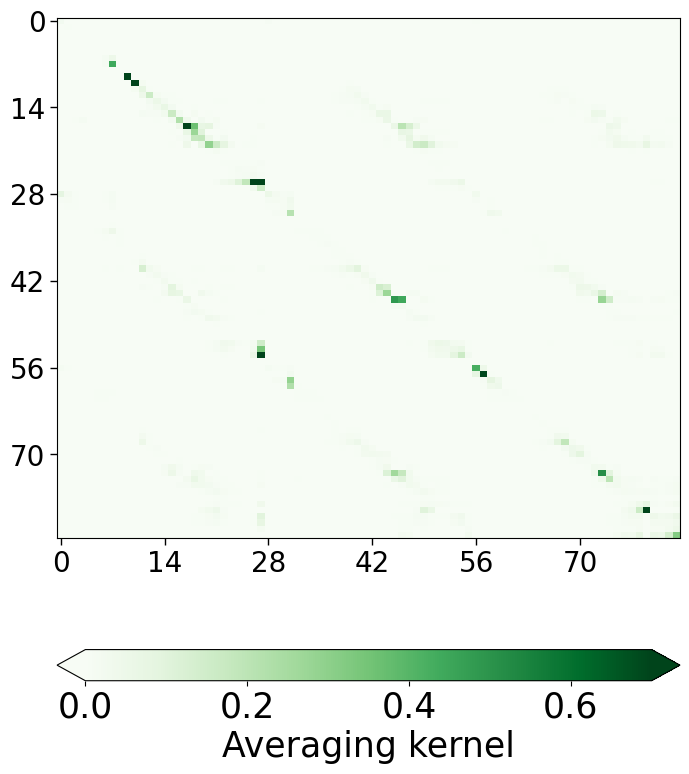

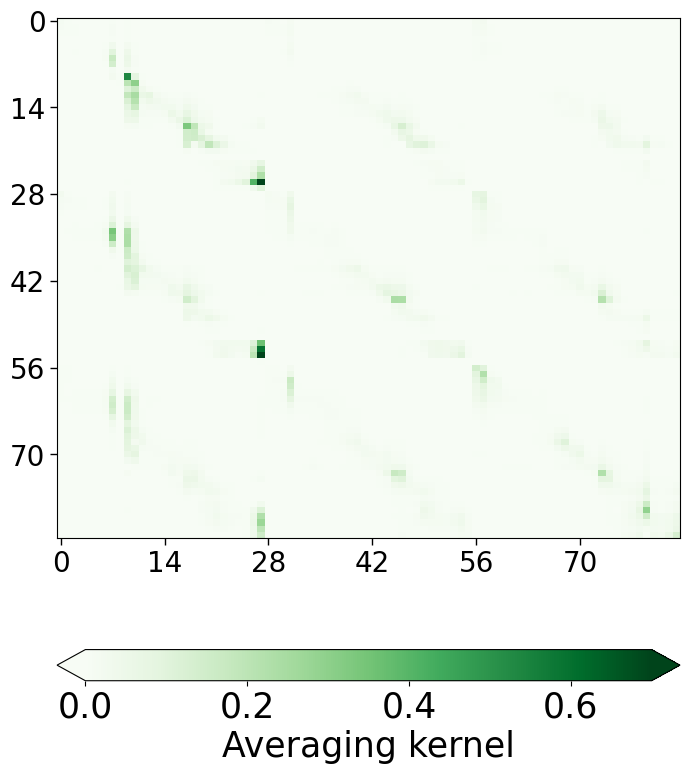

In [ ]:
# plot
c_map='Greens'
fig,ax=plt.subplots(1,1, figsize=(7,8))
plot=ak_data_no_corr_sel.stack(x=("latitude_x", "longitude_x"), y=("latitude_y", "longitude_y")).reset_index(['x','y']).plot(ax=ax,vmin=0,vmax=0.7,cmap=c_map, cbar_kwargs={'location':'bottom', 'label':r'Averaging kernel'})
# ax.plot(ak_data_no_corr_sel.stack(x=("latitude_x", "longitude_x"), y=("latitude_y", "longitude_y")).values)
plot.colorbar.ax.xaxis.label.set_size(25)
plot.colorbar.ax.tick_params(labelsize=25)
# ax.set_title(f'no correlation, {time_slice}')
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
plt.xticks(ticks=ticks_loc, labels=ticks_loc)
plt.yticks(ticks=ticks_loc, labels=ticks_loc)
ax.tick_params(size=5, width=1, labelsize=20)
print(ak_data_no_corr_sel.min().item(), ak_data_no_corr_sel.max().item())
fig.tight_layout()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/AK_lat43_no_corr.png', dpi=300, bbox_inches='tight')

# with correlation
fig,ax=plt.subplots(1,1, figsize=(7,8))
plot=ak_data_with_corr_sel.stack(x=("latitude_x", "longitude_x"), y=("latitude_y", "longitude_y")).reset_index(['x','y']).plot(ax=ax,vmin=0,vmax=0.7,cmap=c_map, cbar_kwargs={'location':'bottom', 'label':r'Averaging kernel'})
plot.colorbar.ax.xaxis.label.set_size(25)
plot.colorbar.ax.tick_params(labelsize=25)
# ax.plot(ak_data_no_corr_sel.stack(x=("latitude_x", "longitude_x"), y=("latitude_y", "longitude_y")).values)
# ax.set_title(f'with correlation')
print(ak_data_with_corr_sel.min().item(), ak_data_no_corr_sel.max().item())
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
plt.xticks(ticks=ticks_loc, labels=ticks_loc)
plt.yticks(ticks=ticks_loc, labels=ticks_loc)
ax.tick_params(size=5, width=1, labelsize=20)
fig.tight_layout()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/AK_lat43_with_corr.png', dpi=300, bbox_inches='tight')


### Example cells with/without correlation

In [ ]:
# plot example and surroundings cells

# read data
bg_str = 'RemoTeC_2.4.0+IS'
gosat_err_val=1
meas_err_val=2
data_dir=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/no_correlation/footprint_spec001_mr/{gosat_err_val}ppm_gosat_meas_err/{meas_err_val}ppm_insitu_meas_err/'
data=xr.open_dataset(f'{data_dir}/20091001-20110331_{bg_str}_bg.nc').sel(latitude=slice(20,48), longitude=slice(-123,-73))
corr_data=xr.open_dataset(f'{data_dir.replace("no_corr", "with_corr")}/20091001-20110331_{bg_str}_bg.nc').sel(latitude=slice(20,48), longitude=slice(-123,-73))
# read reference
ref_flux_2x2=xr.open_dataset(f'/work/bb1170/RUN/b382762/data/TM5Inversion/glb3x2_20220413_new_gridded_flux/flux_2x2_{bg_str}_cut.nc').sel(latitude=slice(20,48), longitude=slice(-123,-73))
# get monthly mean
corr_data_monthly= corr_data.reindex(time=pd.date_range(dt.date(2010,1,1) ,dt.date(2011,1,1)), method='ffill')
corr_data_monthly_std=corr_data_monthly.resample(time='MS').std() # resample to monthly mean
corr_data_monthly=corr_data_monthly.resample(time='MS').mean() # resample to monthly mean

lat_mid=43
lon_mid=-93
lat_lon_list=[(lat, lon) for lat in [lat_mid-2,lat_mid,lat_mid+2] for lon in [lon_mid+2,lon_mid,lon_mid-2]]

# sort by latitude descending, longitude ascending
lat_lon_list=sorted(lat_lon_list, key=lambda x: (-x[0], x[1]))
# plot overview
fig, ax=plt.subplots(3, 3, figsize=(3*6, 3*6), sharey=True, sharex=True)
ax=ax.flatten()
# marker size
ms=2
for i in range(0, len(lat_lon_list)):
    lat_sel, lon_sel =lat_lon_list[i]
    ref_flux_2x2_sel=ref_flux_2x2.sel(latitude=lat_sel, longitude=lon_sel)*1e6
    data_sel=data.sel(latitude=lat_sel, longitude=lon_sel)*1e6
    corr_data_sel=corr_data.sel(latitude=lat_sel, longitude=lon_sel)*1e6
    
    # plot prior
    ax[i].plot(data_sel.time, data_sel.TM5_prior_flux, c='orange', marker='o', markersize=ms, label='prior')
    ax[i].fill_between(data_sel.time, data_sel.TM5_prior_flux-data_sel.prior_uncertainty, data_sel.TM5_prior_flux+data_sel.prior_uncertainty, color='orange', alpha=0.2)        
    # plot posterior
    ax[i].plot(data_sel.time, data_sel.TM5_posterior_flux, c='brown', marker='o', markersize=ms, label='posterior no correlation')
    # with correlation
    ax[i].plot(corr_data_sel.time, corr_data_sel.TM5_posterior_flux, c='r', marker='o', markersize=ms,linestyle='--', label='posterior with correlation')
    ax[i].fill_between(corr_data_sel.time, corr_data_sel.TM5_posterior_flux-corr_data_sel.TM5_posterior_std, corr_data_sel.TM5_posterior_flux+corr_data_sel.TM5_posterior_std, color='r', alpha=0.2)        
    
    # plot reference flux
    ax[i].plot(ref_flux_2x2_sel.time+np.timedelta64(14, 'D'), ref_flux_2x2_sel.total_flux,c='b', marker='x',linestyle='-', markersize=ms, label='TM5-4DVar')
    
    # ax[i].legend(fontsize='large')
    ax[i].set_title(fr'$( {lat_sel}^\circ \mathrm{{N}}, {-lon_sel}^\circ\mathrm{{W}})$', fontsize=23)
    ax[i].set_xlim(dt.date(2010,1,1), dt.date(2010,12,31))
    # ax[i].tick_params(labelleft=True)
    # ax[i].set_ylim(-8e-7, 4e-7)
    
    # You can change the step of range() as you prefer (now, it selects each third month) 
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,5)))
    ax[i].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax[i].grid(which='both', c='grey', alpha=0.5)
    # ax[i].tick_params(labelsize=23)
    ax[i].tick_params(axis='both', which='major', labelsize=23, width=1.5, length=6)
for i in [1,4,5,7]:
    ax[i].axvspan(dt.date(2010,8,12), dt.date(2010,8,20), color='yellow', alpha=0.3)
for i in [0,3,6]:
    ax[i].set_ylabel(r'total flux [$\mathrm{\frac{mg}{m^2 s}}$]', fontsize=23)
# title_str=f'Total 2x2 flux, with/without correlation,no diurnal cycle,{gosat_err_val}pp gosat meas err, {meas_err_val}ppm measurement error'
# fig.suptitle(title_str)
# fig.tight_layout(rect=[0, 0., 1, 0.98])
fig.tight_layout()
ax[6].legend(fontsize=20)
spath_fig=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/correlation/flux_timeseries_example_surrounding_{lat_mid}{lon_mid}.png'
fig.savefig(spath_fig)
print(f'saved to: {spath_fig}')
plt.close()

## 4.3 Diurnal cycle

### scaling factors examples

In [77]:
# read data
# test, read data file, plot same as above
path="/work/bb1170/RUN/b382762/data/TM5Inversion/weekly_mean_prior_scaling_RemoTeC+IS.nc"
data=xr.open_dataset(path)
data

<xarray.Dataset> Size: 138MB
Dimensions:          (date: 80, time: 8, latitude: 44, longitude: 72)
Coordinates:
  * latitude         (latitude) float64 352B 12.5 13.5 14.5 ... 53.5 54.5 55.5
  * longitude        (longitude) float64 576B -133.5 -132.5 ... -63.5 -62.5
  * time             (time) float64 64B 1.5 4.5 7.5 10.5 13.5 16.5 19.5 22.5
  * date             (date) datetime64[ns] 640B 2009-09-21 ... 2011-03-28
Data variables:
    fossil           (date, time, latitude, longitude) float64 16MB ...
    nee              (date, time, latitude, longitude) float64 16MB ...
    ocean            (date, time, latitude, longitude) float64 16MB ...
    fire             (date, time, latitude, longitude) float64 16MB ...
    grid_cell_area   (date, latitude, longitude) float64 2MB ...
    nee_mean         (date, latitude, longitude) float64 2MB ...
    scaling_bio      (date, latitude, longitude, time) float64 16MB ...
    total_flux       (date, time, latitude, longitude) float64 16MB ...
    total_flux_mean  (date, latitude, longitude) float64 2MB ...
    rest_flux        (date, time, latitude, longitude) float64 16MB ...
    rest_flux_mean   (date, latitude, longitude) float64 2MB ...
    scaling_total    (date, time, latitude, longitude) float64 16MB ...

-0.15870730663888144
-4.256990098300701


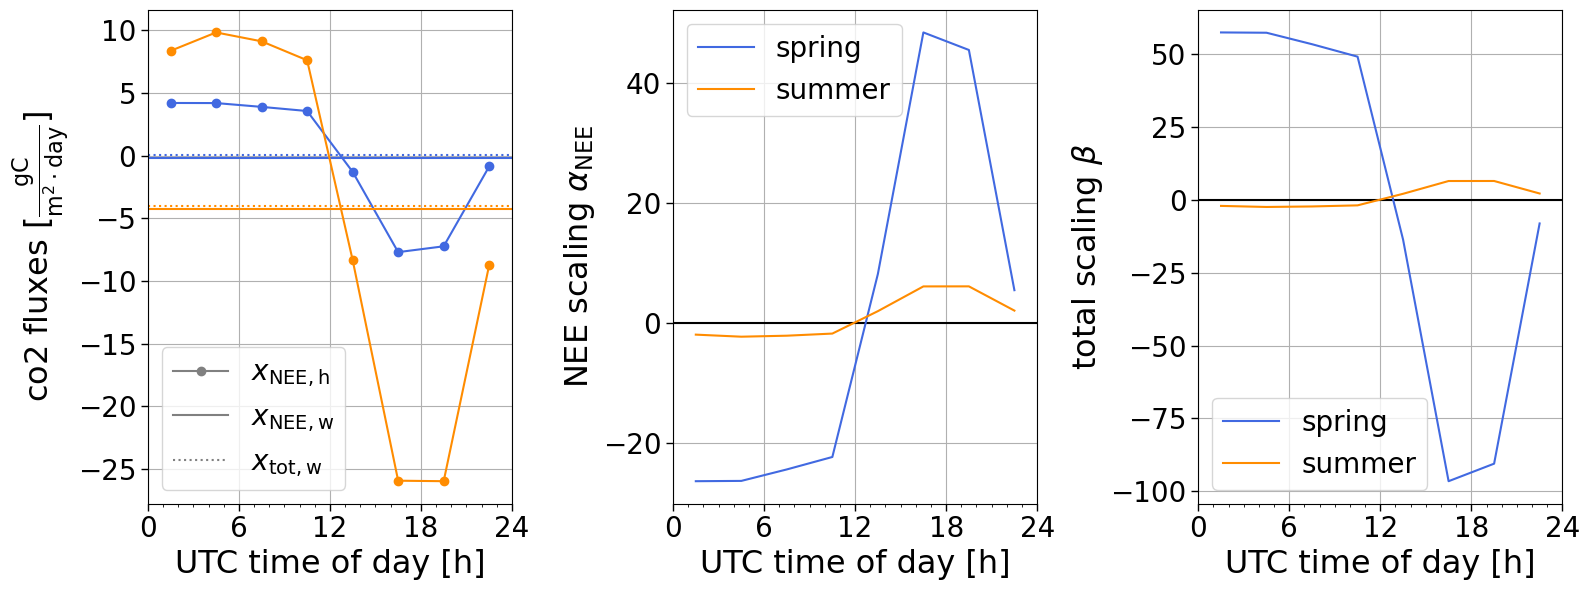

In [95]:

week_sel=[dt.datetime(2010,5,3, 0,0,0), dt.datetime(2010,6,28, 0,0,0)]

lat, lon= 43.5,-93.5
clist=['royalblue', 'darkorange']
# clist=['#377eb8', '#ff7f00']
date_str=['spring', 'summer']
fig, ax=plt.subplots(1,3, figsize=(16,6))
j=0
for i in [1,2]:
    ax[i].hlines(0, 0,24, color='black')
for date_sel in week_sel:      #week_sel
    ax[0].plot(data.time, data.sel(date=date_sel, latitude=lat, longitude=lon).nee,marker='o',color=clist[j], label=fr'$x_\mathrm{{NEE, h}}$ {date_str[j]}')       # date_sel.values
    ax[0].hlines(data.sel(date=date_sel, latitude=lat, longitude=lon).nee_mean,0,24,color=clist[j], label=fr'$x_\mathrm{{NEE, w}}$, {date_str[j]}')
    print(data.sel(date=date_sel, latitude=lat, longitude=lon).nee_mean.values)
    # ax[0].plot(data.time, data.sel(date=date_sel, latitude=lat, longitude=lon).rest_flux, marker='x', linestyle='--',color=clist[j], label=f'rest, {date_str[j]}')       # date_sel.values
    # ax[0].plot(data.time, data.sel(date=date_sel, latitude=lat, longitude=lon).total_flux, marker='>', linestyle=':',color=clist[j], label=f'total, {date_str[j]}')       # date_sel.values
    ax[0].hlines(data.sel(date=date_sel, latitude=lat, longitude=lon).total_flux_mean,0,24,color=clist[j],linestyles=':', label=f'$x_\mathrm{{tot, w}}$, {date_str[j]}')
    ax[1].plot(data.time, data.sel(date=date_sel, latitude=lat, longitude=lon).scaling_bio,color=clist[j], label=date_str[j])       # date_sel.values      # label=date_sel.strftime("%d.%m.%Y")
    ax[2].plot(data.time, data.sel(date=date_sel, latitude=lat, longitude=lon).scaling_total,color=clist[j], label=date_str[j])        # label=date_sel.strftime("%d.%m.%Y")
    ax[0].set_ylabel(r'co2 fluxes $\mathrm{[\frac{gC}{m^2 \cdot day}]}$',fontsize=23)
    ax[1].set_ylabel(r'NEE scaling $\alpha_\mathrm{NEE}$',fontsize=23)
    ax[2].set_ylabel(r'total scaling $\beta$',fontsize=23)
    j+=1
for i in range(0, len(ax)):
    ax[i].grid()
    # ax[i].hlines(0,0,24, color='black')
    ax[i].set_xlim((0,24))
    ax[i].set_xlabel('UTC time of day [h]',fontsize=23)
    ax[i].tick_params(axis='both', which='major', labelsize=20, width=1, length=5)
    ax[i].set_xticks(np.arange(0,25,step=6), minor=False)
    ax[i].set_xticks(np.arange(0,25,step=1), minor=True)
    # ax[i].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
# ax[0].set_title('co2 fluxes')
# ax[1].set_title(f'NEE scaling, ({lat}/{lon})')
# ax[2].set_title(f'total scaling, ({lat}/{lon})')
# ax[0].legend(fontsize=23)

# Manually create legend handles
custom_legend = [
    Line2D([0], [0], marker='o', label=fr'$x_\mathrm{{NEE, h}}$',color='grey', linestyle='-'),
    Line2D([0], [0], marker='', label=fr'$x_\mathrm{{NEE, w}}$',color='grey', linestyle='-'),
    Line2D([0], [0], marker='', label=fr'$x_\mathrm{{tot, w}}$',color='grey', linestyle=':')
]
# Add custom legend
ax[0].legend(handles=custom_legend, loc='lower left', fontsize=20)
ax[1].legend(fontsize=20)
ax[2].legend(fontsize=20)
fig.tight_layout()
# passt
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/diurnal_cycle/scaling_factor_examples.png', dpi=300, bbox_inches='tight')


### sign flip argument fig

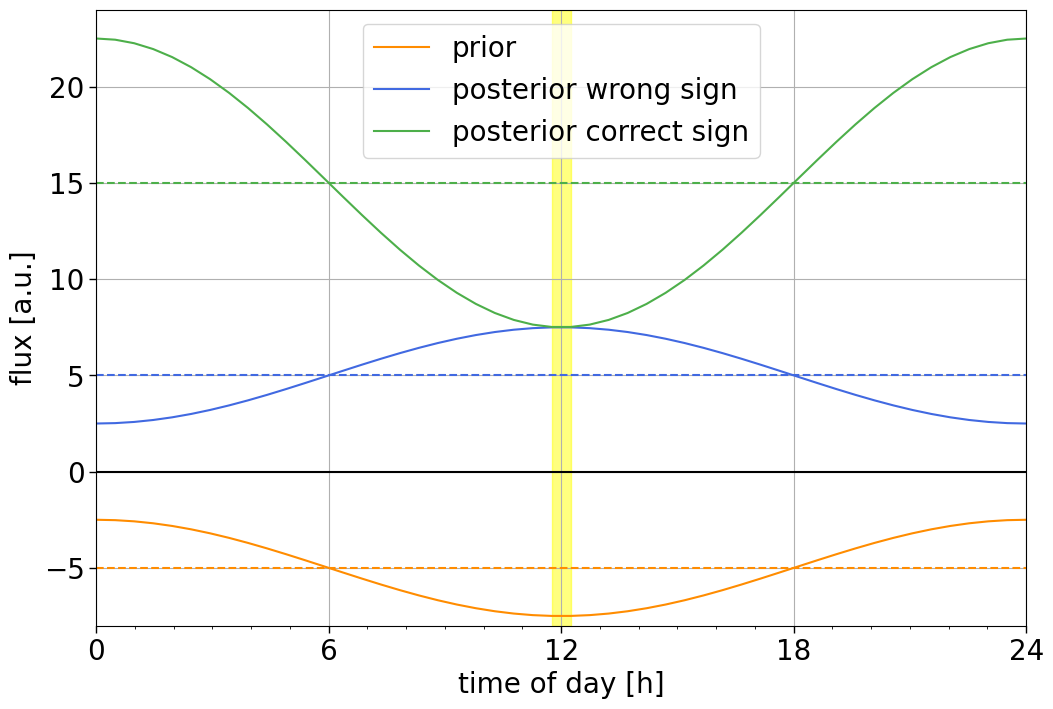

In [109]:
# sign flip argument fig, 16.05

x_val=np.linspace(0,24)
# y_val=-0.5*np.sin(x_val/24*2*np.pi)
y_val=-0.5*np.cos(x_val/24*2*np.pi)

#list of colors
# cmap = mpl.colormaps['Blues']
# # Take colors at regular intervals spanning the colormap.
# colors = cmap(np.linspace(0.9, 0.6, 4))
# colors=['blue', 'royalblue', 'cornflowerblue', 'deepskyblue']
# colors=['forestgreen', 'royalblue', 'cornflowerblue', 'darkorange']
# colors=['#4daf4a','#f781bf','#f781bf', 'royalblue',]
colors=['darkorange', 'royalblue']
label_list=['prior', 'posterior wrong sign', 'posterior correct sign']

fig, ax=plt.subplots(figsize=(12,8))
ax.hlines(0, 0,24,color='black')
i=0
# for a in [-5,-1,1,5]:
for a in [-5,5]:
    ax.plot(x_val, y_val*a+a,color=colors[i], label=label_list[i])
    ax.hlines(a, 0,24,color=colors[i], linestyle='--')
    i+=1
    

# ax.hlines(10, 0,24,color='red', linestyle='--')
# ax.plot(x_val, y_val*-5+10,color='red', label=r'$x_\mathrm{w}=10$')
ax.plot(x_val, y_val*-15+15,color='#4daf4a', label=label_list[-1])
ax.hlines(15, 0,24,color='#4daf4a', linestyle='--')
ax.axvspan(12-0.25, 12+0.25, alpha=0.5, color='yellow')
ax.grid()
ax.set_xlim(0,24)
ax.set_ylim(-8,24)
ax.tick_params(axis='both', which='major', labelsize=20, width=1, length=5)
ax.set_xticks(np.arange(0,25,step=6), minor=False)
ax.set_xticks(np.arange(0,25,step=1), minor=True)
ax.set_xlabel('time of day [h]', fontsize=20)
ax.set_ylabel('flux [a.u.]', fontsize=20)
ax.legend( fontsize=20)
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/diurnal_cycle/sign_change_schematic.png', dpi=300, bbox_inches='tight')

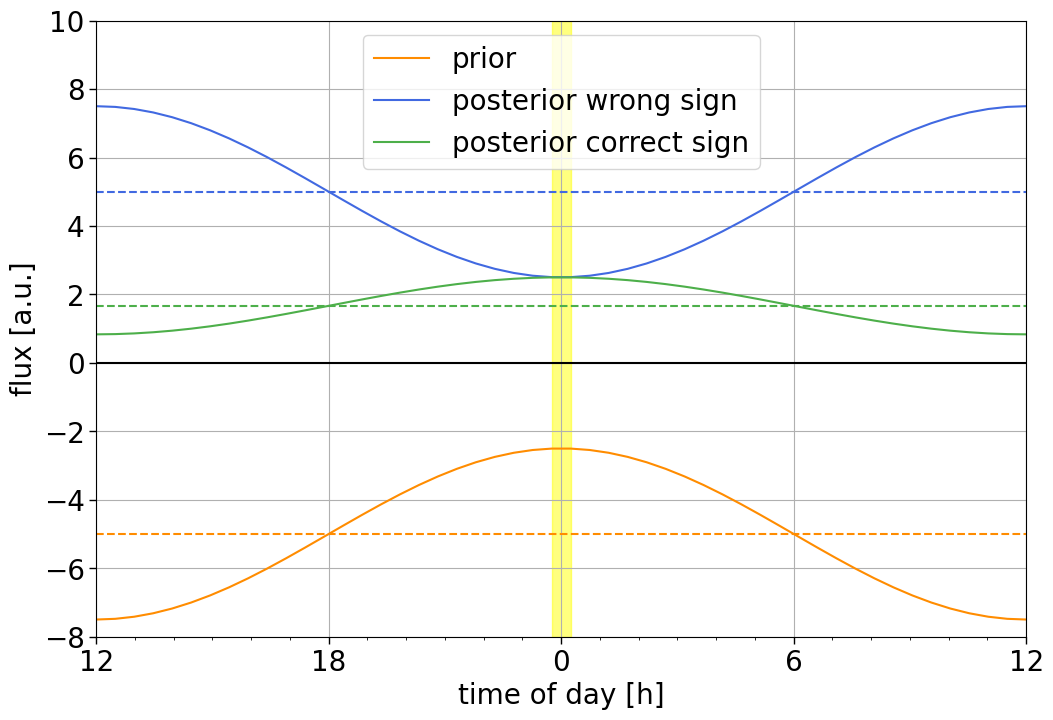

In [110]:
# sign flip argument fig, 16.05

x_val=np.linspace(12,36)
# y_val=-0.5*np.sin(x_val/24*2*np.pi)
y_val=-0.5*np.cos(x_val/24*2*np.pi)

colors=['darkorange', 'royalblue']
label_list=['prior', 'posterior wrong sign', 'posterior correct sign']

fig, ax=plt.subplots(figsize=(12,8))
ax.hlines(0, 12,36,color='black')
i=0
# for a in [-5,-1,1,5]:
for a in [-5,5]:
    ax.plot(x_val, y_val*a+a,color=colors[i], label=label_list[i])
    ax.hlines(a, 12,36,color=colors[i], linestyle='--')
    i+=1
    

# ax.hlines(10, 12,36,color='red', linestyle='--')
# ax.plot(x_val, y_val*-5+10,color='red', label=r'$x_\mathrm{w}=10$')
ax.plot(x_val, y_val*-5/3+5/3,color='#4daf4a', label=label_list[-1])
ax.hlines(5/3, 12,36,color='#4daf4a', linestyle='--')
ax.axvspan(24-0.25, 24+0.25, alpha=0.5, color='yellow')
ax.grid()
ax.set_xlim(12,36)
ax.set_ylim(-8,10)
ax.tick_params(axis='both', which='major', labelsize=20, width=1, length=5)
ax.set_xticks(np.arange(12,37,step=6), labels=[12,18,0,6,12], minor=False)
ax.set_xticks(np.arange(12,37,step=1), minor=True)
ax.set_xlabel('time of day [h]', fontsize=20)
ax.set_ylabel('flux [a.u.]', fontsize=20)
ax.legend( fontsize=20)
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/diurnal_cycle/sign_change_schematic_night.png', dpi=300, bbox_inches='tight')

In [24]:
3/4*24

18.0

### 4.3.3 example flux cells

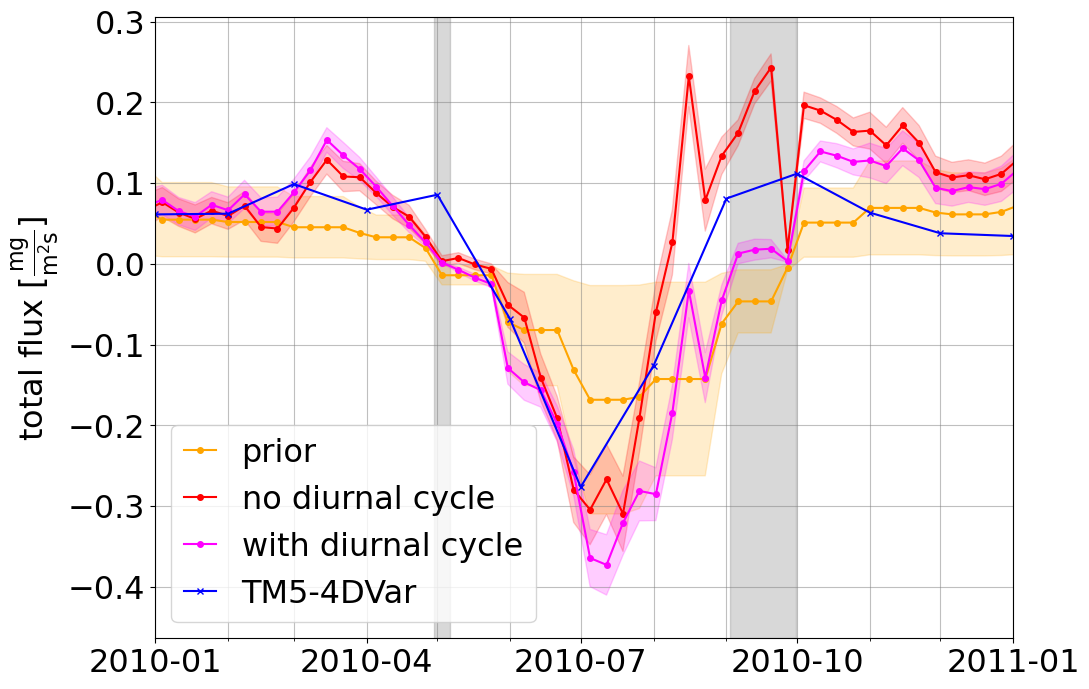

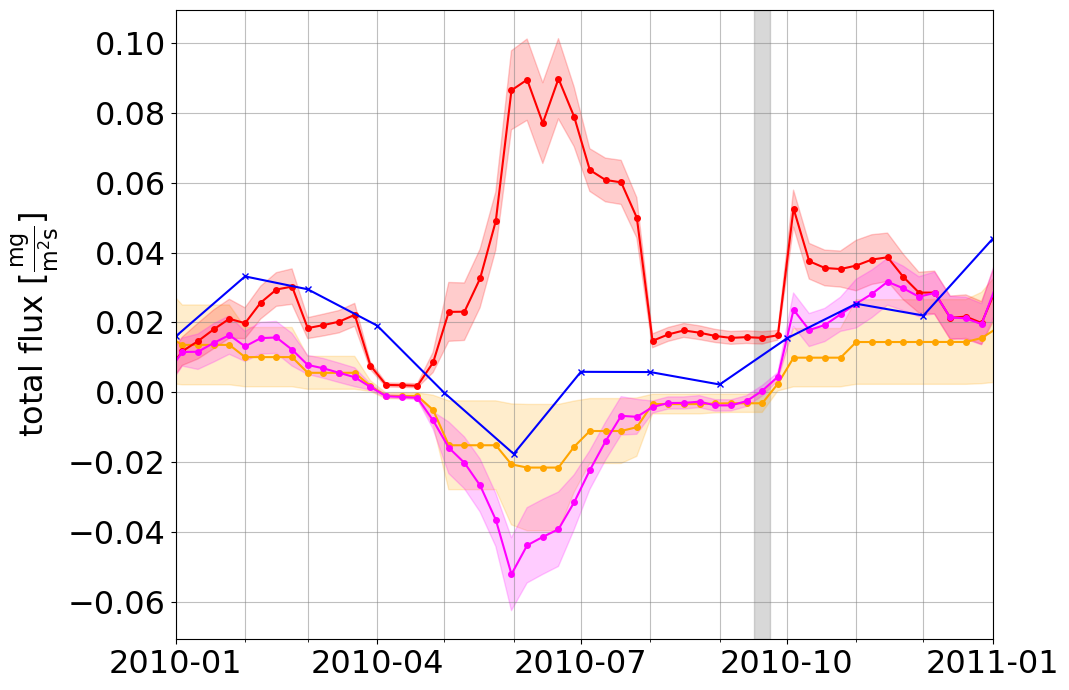

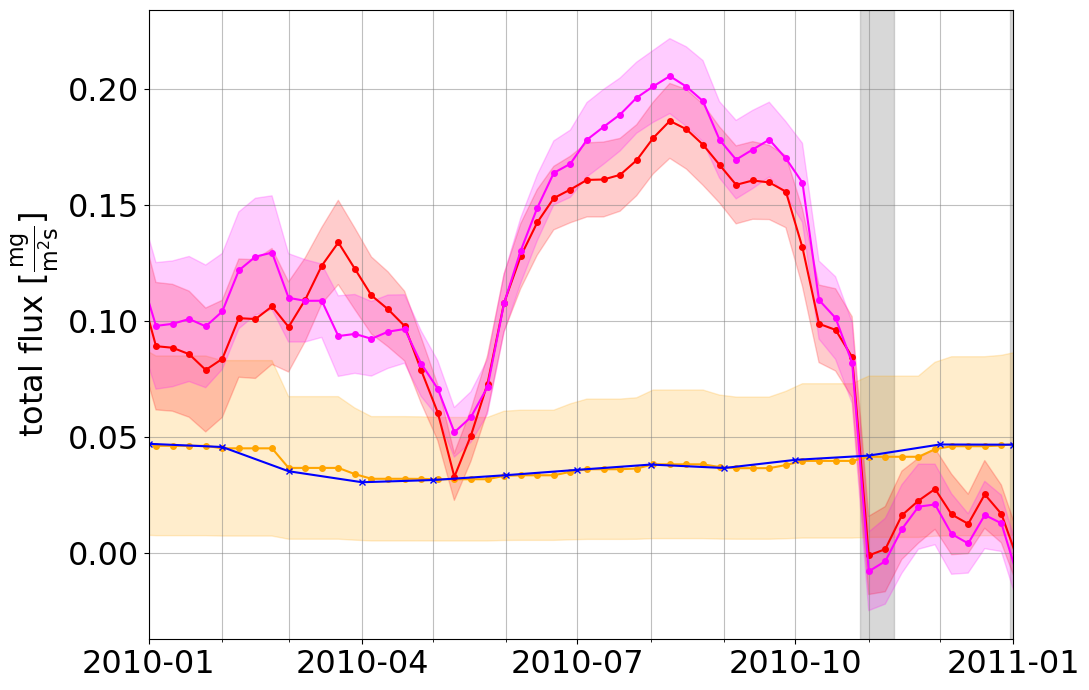

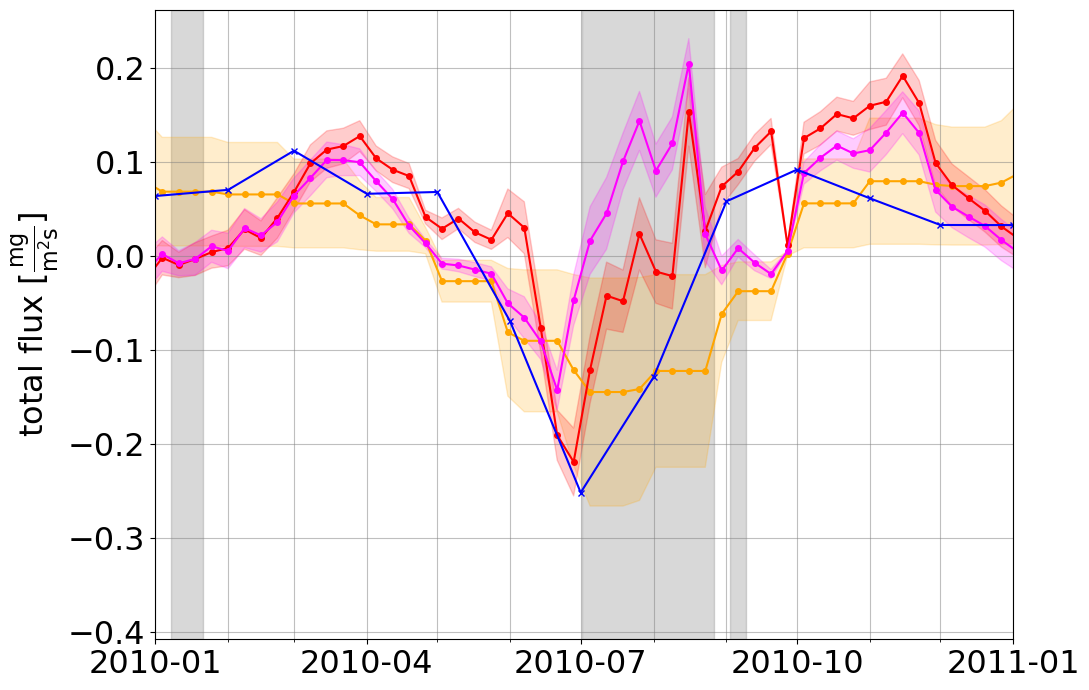

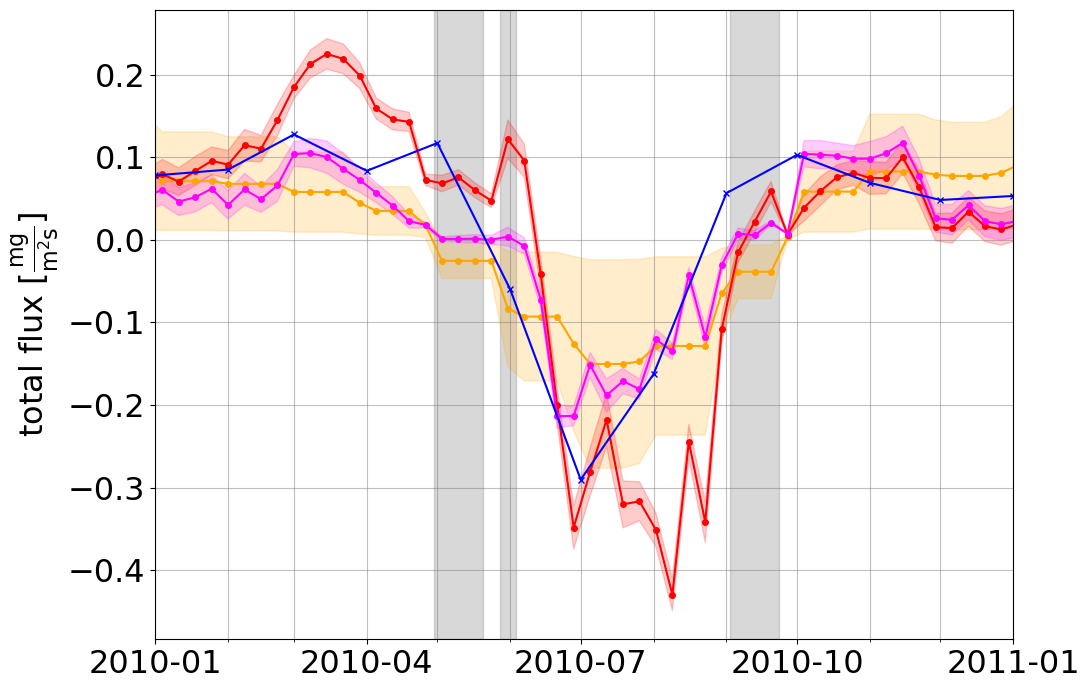

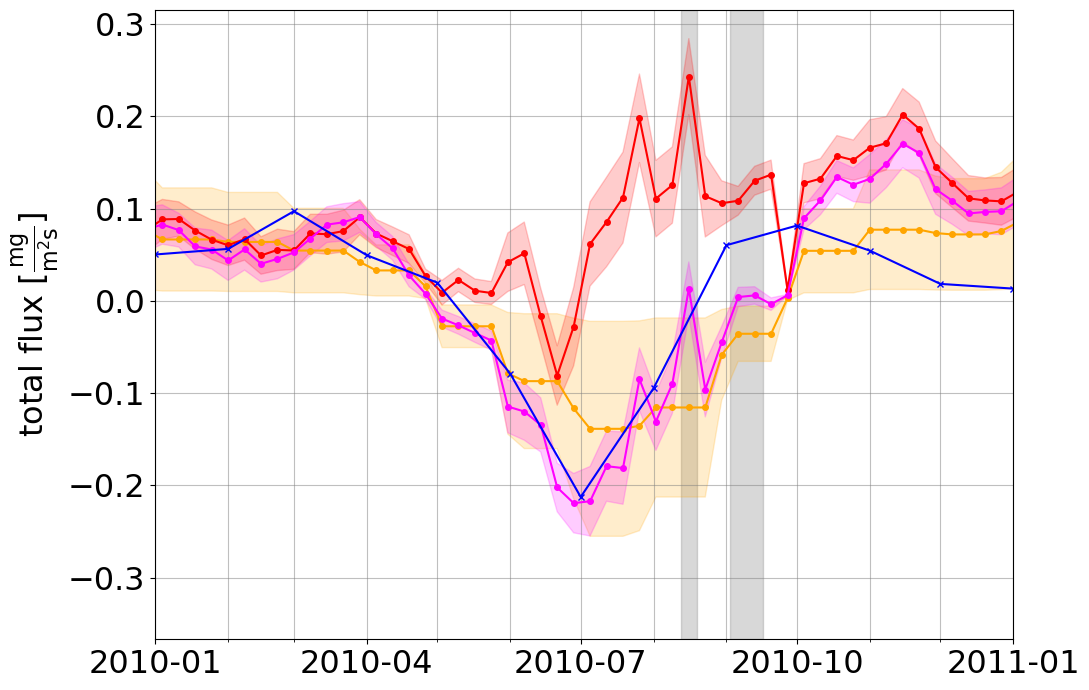

In [57]:
# plot fluxes with and without diurnal cycle for some example cells
# one where good improvement through diurnal cycle
# now same plots with diurnal cycle

gosat_err_val=1
meas_err_val=2
start_date = dt.date(2009,10,1)
end_date = dt.date(2011,3,31)
bg_str = 'RemoTeC_2.4.0+IS'
corr_str='with'
res=2
data_dir=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/{res}x{res}/{corr_str}_correlation/footprint_spec001_mr_scaled/{gosat_err_val}ppm_gosat_meas_err/{meas_err_val}ppm_insitu_meas_err/'
inv_data=xr.open_dataset(f'{data_dir}/{start_date.strftime("%Y%m%d")}-{end_date.strftime("%Y%m%d")}_{bg_str}_bg.nc')
unscaled_data=xr.open_dataset(f'{data_dir.replace("footprint_spec001_mr_scaled", "footprint_spec001_mr")}/{start_date.strftime("%Y%m%d")}-{end_date.strftime("%Y%m%d")}_{bg_str}_bg.nc')
# read reference
ref_flux=xr.open_dataset(f'/work/bb1170/RUN/b382762/data/TM5Inversion/glb3x2_20220413_new_gridded_flux/flux_{res}x{res}_{bg_str}_cut.nc')

# select locations

# select regions
lat_lon_list = [(43,-93), (43, -117), ( 33, -119), (41,-93), (41,-91), (41,-95)]      #, (37,-97)
# lat_lon_list = []      #, (37,-97)

for (lat_sel, lon_sel) in lat_lon_list:
    fig,ax=plt.subplots(figsize=(11,7), sharey=True)
    inv_data_sel=inv_data.sel(latitude=lat_sel, longitude=lon_sel)*1e6
    unscaled_data_sel=unscaled_data.sel(latitude=lat_sel, longitude=lon_sel)*1e6
    ref_flux_sel=ref_flux.sel(latitude=lat_sel, longitude=lon_sel)*1e6
    
    # mask for prior-posterior signflip
    sign_mask=inv_data_sel.where(np.sign(inv_data_sel.TM5_prior_flux)!=np.sign(inv_data_sel.TM5_posterior_flux), drop=True)
    # get time intervals
    t_intervals=[(t - np.timedelta64(84, 'h'), t + np.timedelta64(84, 'h')) for t in sign_mask.time.values]
    t_intervals.sort()
    # Merge overlapping or consecutive intervals
    merged_intervals = []
    for start, end in t_intervals:
        if not merged_intervals:
            merged_intervals.append((start, end))
        else:
            last_start, last_end = merged_intervals[-1]
            if start <= last_end:  # overlap or consecutive
                merged_intervals[-1] = (last_start, max(last_end, end))
            else:
                merged_intervals.append((start, end))
    for start, end in merged_intervals:
        ax.axvspan(start, end, color='grey', alpha=0.3)
        
    # plot time series, prior & posterior
    ms=4
    ax.plot(inv_data_sel.time, inv_data_sel.TM5_prior_flux, c='orange',marker='o',markersize=ms, label='prior')
    ax.fill_between(inv_data_sel.time, inv_data_sel.TM5_prior_flux-inv_data_sel.prior_uncertainty, inv_data_sel.TM5_prior_flux+inv_data_sel.prior_uncertainty, color='orange', alpha=0.2)
    # plot without scaling
    ax.plot(unscaled_data_sel.time, unscaled_data_sel.TM5_posterior_flux, c='red', marker='o', markersize=ms, label='no diurnal cycle')
    ax.fill_between(unscaled_data_sel.time, unscaled_data_sel.TM5_posterior_flux-unscaled_data_sel.TM5_posterior_std, unscaled_data_sel.TM5_posterior_flux+unscaled_data_sel.TM5_posterior_std, color='red', alpha=0.2)
    # plot with scaling
    ax.plot(inv_data_sel.time, inv_data_sel.TM5_posterior_flux, c='magenta', marker='o', markersize=ms, label='with diurnal cycle')
    ax.fill_between(inv_data_sel.time, inv_data_sel.TM5_posterior_flux-inv_data_sel.TM5_posterior_std, inv_data_sel.TM5_posterior_flux+inv_data_sel.TM5_posterior_std, color='magenta', alpha=0.2)
    # plot reference
    ax.plot(ref_flux_sel.time, ref_flux_sel.total_flux,c='b', marker='x', markersize=ms, label='TM5-4DVar')
    if (lat_sel, lon_sel)==(43,-93): 
        ax.legend(handlelength=1,fontsize=23, loc='lower left')
    # ax.set_title(f'lat/lon: {lat_sel}/{lon_sel}')

    ax.set_xlim(dt.date(2010,1,1), dt.date(2011,1,1))
    ax.tick_params(labelleft=True, labelsize=23)
    ax.set_ylabel(r'total flux [$\mathrm{\frac{mg}{m^2 s}}$]', fontsize=23)
    # ax.set_ylim(-1.5e-7, 1.2e-7)

    # You can change the step of range() as you prefer (now, it selects each third month) 
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.grid(which='both', c='grey', alpha=0.5)
    fig.tight_layout()
    fig.savefig(f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/diurnal_cycle/2x2_{corr_str}_corr_{lat_sel}{lon_sel}_diurnal_cycle_comp.png', dpi=300, bbox_inches='tight')




### mean absolute difference to ref flux 

In [17]:
# get mean flux diff to res for example cell
gosat_err_val=1
meas_err_val=2
start_date = dt.date(2009,10,1)
end_date = dt.date(2011,3,31)
bg_str = 'RemoTeC_2.4.0+IS'
corr_str='with'
res=2
data_dir=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/{res}x{res}/{corr_str}_correlation/footprint_spec001_mr_scaled/{gosat_err_val}ppm_gosat_meas_err/{meas_err_val}ppm_insitu_meas_err/'
inv_data=xr.open_dataset(f'{data_dir}/{start_date.strftime("%Y%m%d")}-{end_date.strftime("%Y%m%d")}_{bg_str}_bg.nc')
unscaled_data=xr.open_dataset(f'{data_dir.replace("footprint_spec001_mr_scaled", "footprint_spec001_mr")}/{start_date.strftime("%Y%m%d")}-{end_date.strftime("%Y%m%d")}_{bg_str}_bg.nc')
# read reference
ref_flux=xr.open_dataset(f'/work/bb1170/RUN/b382762/data/TM5Inversion/glb3x2_20220413_new_gridded_flux/flux_{res}x{res}_{bg_str}_cut_weekly.nc')

# select locations

# select regions
lat_lon_list = [(43,-93), (43, -117), ( 33, -119)]      #, (37,-97)

for (lat_sel, lon_sel) in lat_lon_list:
    print(lat_sel, lon_sel)
    inv_data_sel=inv_data.sel(latitude=lat_sel, longitude=lon_sel, time=slice(dt.date(2010,1,1), dt.date(2010,12,31)))
    unscaled_data_sel=unscaled_data.sel(latitude=lat_sel, longitude=lon_sel, time=slice(dt.date(2010,1,1), dt.date(2010,12,31)))
    ref_flux_sel=ref_flux.sel(latitude=lat_sel, longitude=lon_sel, time=slice(dt.date(2010,1,1), dt.date(2010,12,31)))
    # TODO check this, feel like there is something wrong for 43/117 cell
    unscaled_diff=np.abs(unscaled_data_sel.TM5_posterior_flux -ref_flux_sel.total_flux).mean()
    unscaled_diff_std=np.abs(unscaled_data_sel.TM5_posterior_flux -ref_flux_sel.total_flux).std()
    print('unscaled diff')
    print(np.round(unscaled_diff.item(), 12), np.round(unscaled_diff_std.item(), 12))
    
    scaled_diff=np.abs(inv_data_sel.TM5_posterior_flux -ref_flux_sel.total_flux).mean()
    scaled_diff_std=np.abs(inv_data_sel.TM5_posterior_flux -ref_flux_sel.total_flux).std()
    print('scaled diff')
    print(np.round(scaled_diff.item(),12), np.round(scaled_diff_std.item(),12))

    print('')

43 -93
unscaled diff
6.4818e-08 6.1942e-08
scaled diff
5.1952e-08 3.6199e-08

43 -117
unscaled diff
2.4082e-08 2.8117e-08
scaled diff
1.3613e-08 9.839e-09

33 -119
unscaled diff
7.4398e-08 4.1589e-08
scaled diff
8.3046e-08 4.5593e-08



In [24]:
#  overall flux difference for inner region, 2010
unscaled_data_sel=unscaled_data.sel(latitude=slice(20,48), longitude=slice(-126,-70), time=slice(dt.date(2010,1,1), dt.date(2010,12,31)))
inv_data_sel=inv_data.sel(latitude=slice(20,48), longitude=slice(-126,-70), time=slice(dt.date(2010,1,1), dt.date(2010,12,31)))
ref_flux_sel=ref_flux.sel(latitude=slice(20,48), longitude=slice(-126,-70), time=slice(dt.date(2010,1,1), dt.date(2010,12,31)))
# inv_data_sel
# ref_flux_sel

unscaled_diff=np.abs(unscaled_data_sel.TM5_posterior_flux -ref_flux_sel.total_flux).mean()
unscaled_diff_std=np.abs(unscaled_data_sel.TM5_posterior_flux -ref_flux_sel.total_flux).std()
print('unscaled diff')
print(np.round(unscaled_diff.item(), 12), np.round(unscaled_diff_std.item(), 12))

scaled_diff=np.abs(inv_data_sel.TM5_posterior_flux -ref_flux_sel.total_flux).mean()
scaled_diff_std=np.abs(inv_data_sel.TM5_posterior_flux -ref_flux_sel.total_flux).std()
print('scaled diff')
print(np.round(scaled_diff.item(),12), np.round(scaled_diff_std.item(),12))


unscaled diff
1.8651e-08 2.9162e-08
scaled diff
1.6979e-08 2.482e-08


### seasonal maps of flux differences to TM5-4DVar

In [128]:
# read monthly mean data
data_dir='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/with_correlation/footprint_spec001_mr_scaled/1ppm_gosat_meas_err/2ppm_insitu_meas_err'
scaled_monthly=xr.open_dataset(f'{data_dir}/monthly_mean_flux_2010_RemoTeC_2.4.0+IS_bg.nc')
unscaled_monthly=xr.open_dataset(f'{data_dir.replace("footprint_spec001_mr_scaled", "footprint_spec001_mr")}/monthly_mean_flux_2010_RemoTeC_2.4.0+IS_bg.nc')
diff=(scaled_monthly-unscaled_monthly)*1e6
scaled_monthly
# read is meas stations
# just get position
insitu_data=xr.open_dataset('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/insitu/prep_footprints/high_res/scaled_weekly/high_res_scaled_footprints_20091001-20110331_4x4_weekly.nc')#[['release_lat', 'release_lon', 'file', 'elevation[masl]']]
insitu_data
# Combine lat and lon into a pandas DataFrame
insitu_df = pd.DataFrame({
    'lat': insitu_data['release_lat'].round(2).values,  # round to four nachkommastellen to neglegt very small differences
    'lon': insitu_data['release_lon'].round(2).values,
    'file': insitu_data['file'].values,
    'elevation': insitu_data['elevation[masl]'].round(0).values,
    # 'intake_height': insitu_data['intake_height[magl]'].values,
})

# Drop duplicates to keep only unique locations
insitu_df_unique = insitu_df.drop_duplicates()

# insitu_df_unique.shape


In [131]:
# get mean over 4 months each
diff_mean=diff.coarsen(time=4).mean()
# diff_mean

for t in diff_mean.time:
    diff_sel=diff_mean.sel(time=t)
    print(t.values)
    print(np.round(diff_sel.TM5_posterior_flux.min().item(), 4), np.round(diff_sel.TM5_posterior_flux.max().item(), 4))
    # print(np.round(diff_sel.TM5_posterior_flux.mean().item(), 10), np.round(diff_sel.TM5_posterior_flux.std().item(), 10))
    print('')

2010-02-15T00:00:00.000000000
-0.0755 0.0757

2010-06-16T00:00:00.000000000
-0.1704 0.1591

2010-10-16T12:00:00.000000000
-0.0642 0.0702



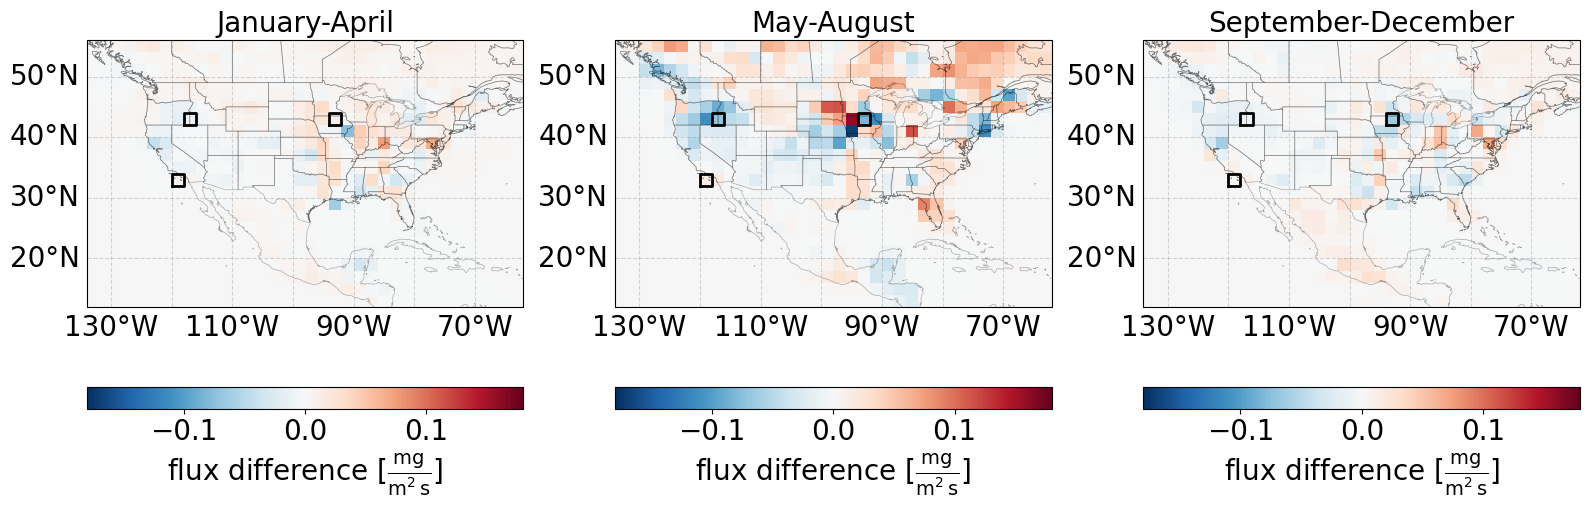

In [134]:
# plot differences for 12 months
fig, ax=plt.subplots(1,3,figsize=(16,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax=ax.flatten()
max_val = np.ceil(np.max(np.abs(diff_mean.TM5_posterior_flux.values)) * 1e2) * 1e-2
# fig.suptitle('Flux difference, scaled - unscaled footprints')



# plot monthly maps 
for t in scaled_monthly.time.values:
    i=pd.to_datetime(t).month
    # plot difference
    # diff_mean.TM5_posterior_flux.sel(time=t).plot(ax=ax[i-1],vmin=-max_val, vmax=max_val,cmap='RdBu_r', cbar_kwargs={'location':'bottom', 'label':r'total flux [$\mathrm{\frac{kg}{m^2 \, s}}$]'})
    # ax[i-1].set_title(f"{pd.to_datetime(t).strftime('%m.%Y')}")
    
for i in range(0,len(ax)):
    # diff_mean.TM5_posterior_flux.isel(time=i).plot(ax=ax[i],cmap='RdBu_r', cbar_kwargs={'location':'bottom', 'label':r'total flux [$\mathrm{\frac{kg}{m^2 \, s}}$]'})
    plot=diff_mean.TM5_posterior_flux.isel(time=i).plot(ax=ax[i],vmin=-max_val, vmax=max_val,cmap='RdBu_r', 
                                                   cbar_kwargs={'location':'bottom', 'label':r'flux difference [$\mathrm{\frac{mg}{m^2 \, s}}$]'})
    plot.colorbar.ax.xaxis.label.set_size(20)
    plot.colorbar.ax.tick_params(labelsize=20)
    # scatter is_meas locations
    # ax[i].scatter(insitu_df_unique.lon, insitu_df_unique.lat, color='black', s=3)
    
    ax[i].set_xlabel('longitude')
    ax[i].set_ylabel('latitude')
    # Add coastlines
    ax[i].coastlines(linewidth=0.5, alpha=0.3)
    # Add U.S. state borders
    ax[i].add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
    gl = ax[i].gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    ax[i].grid(c='lightgrey')
    ax[i].set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
    ax[i].set_ylim(12,56)
    # plot boxes for shown examples
    for (lat_sel, lon_sel) in [(43,-93), (43,-117), (33,-119)]:
        box_lats = [lat_sel-1, lat_sel-1, lat_sel+1, lat_sel+1, lat_sel-1]
        box_lons = [lon_sel-1, lon_sel+1, lon_sel+1, lon_sel-1, lon_sel-1]
        ax[i].plot(box_lons, box_lats, transform=ccrs.PlateCarree(), color='black', linewidth=2)
ax[0].set_title('January-April', fontsize=20)
ax[1].set_title('May-August', fontsize=20)
ax[2].set_title('September-December', fontsize=20)
fig.tight_layout()
plt.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/diurnal_cycle/total_flux_diff_scaled-unscaled.png', dpi=300, bbox_inches='tight')




## 4.4 measurement errors

average difference to meas for July to september:
0.25
gosat posterior_diff: -0.2917613854322722
gosat TM5_molefrac_diff_interpolated: 0.27202333893717184
is posterior_diff: -1.7259690322291446
is TM5_molefrac_diff_interpolated: -0.6827027483784716 

overall average difference to meas for 2010:
gosat posterior_diff: 0.01795307958994921
gosat TM5_molefrac_diff_interpolated: 0.4945420271831682
is posterior_diff: -1.060681604856156
is TM5_molefrac_diff_interpolated: -0.9512552457509896 

overall absolute mean diff to meas for 2010:
gosat posterior_diff: 0.7553512894743933
gosat TM5_molefrac_diff_interpolated: 0.7028964073887376
is posterior_diff: 1.712518185239022
is TM5_molefrac_diff_interpolated: 1.711753311587761 
 

average difference to meas for July to september:
3
gosat posterior_diff: -0.15972761666280744
gosat TM5_molefrac_diff_interpolated: 0.27202333893717184
is posterior_diff: -1.1815842341630904
is TM5_molefrac_diff_interpolated: -0.6827027483784716 

overall average differen

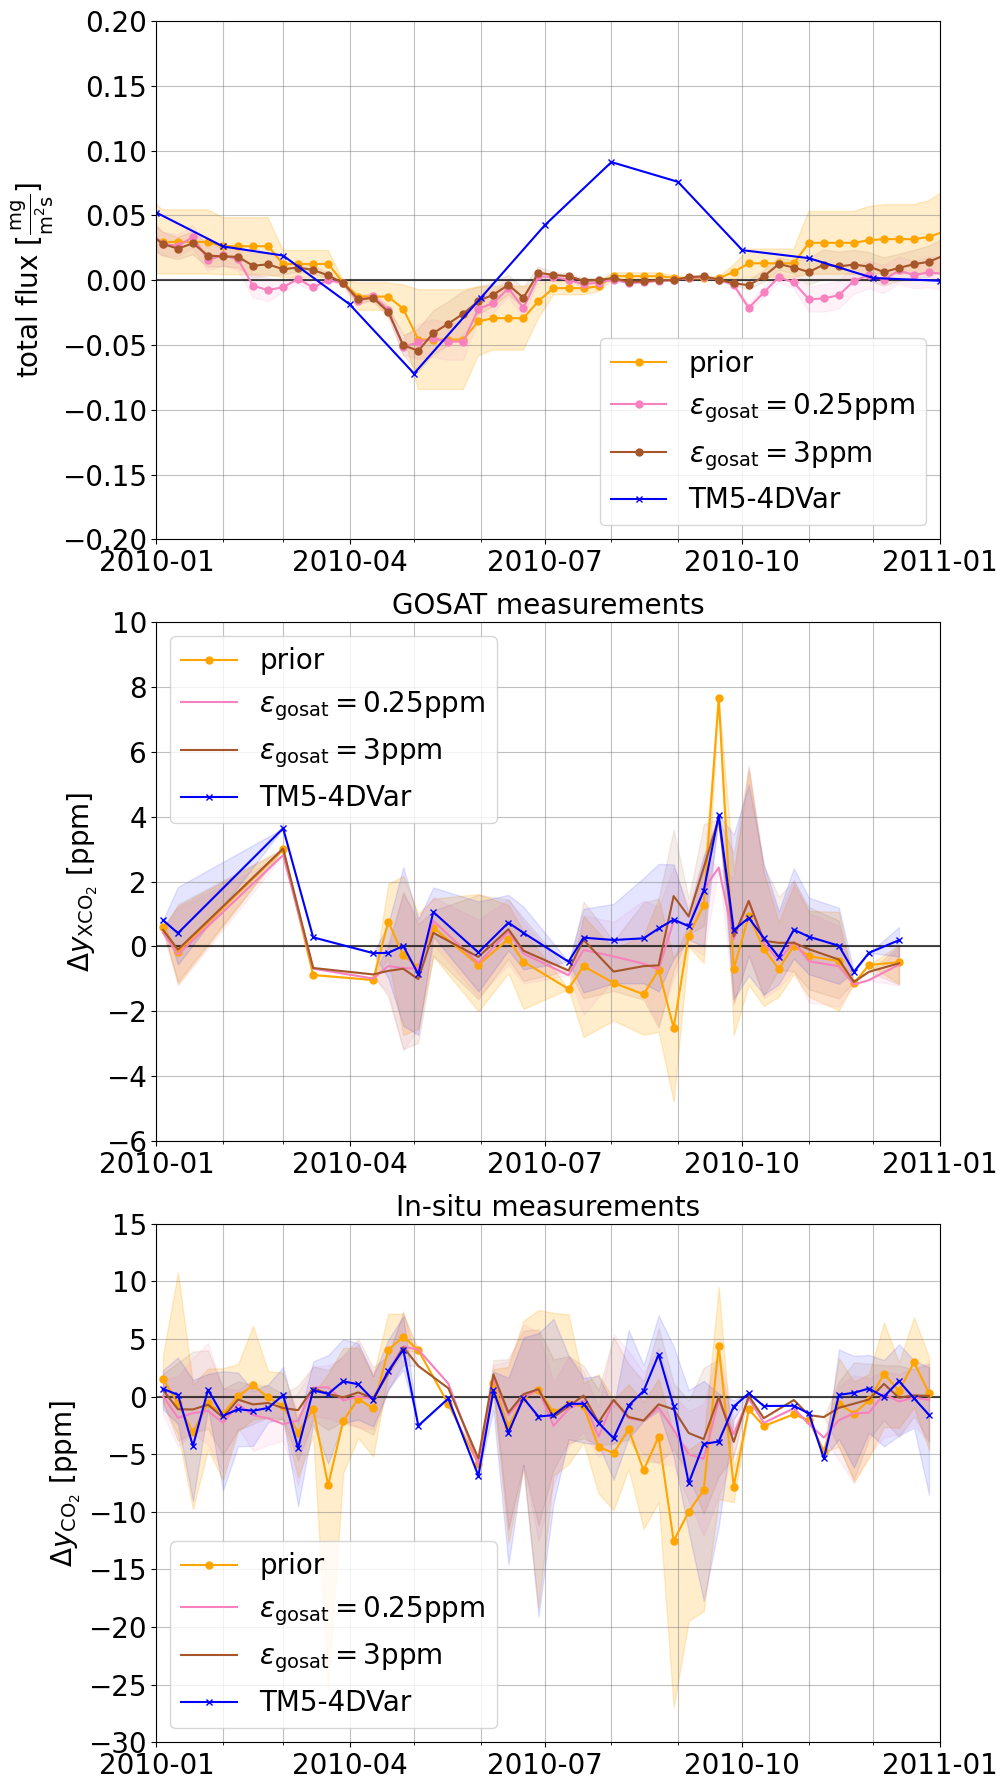

In [2]:
# plot fluxes for example region with multiple insitu meas errs?

# now same plots with correlation
corr_str='with'
f_str= 'spec001_mr_scaled'
bg_str = 'RemoTeC_2.4.0+IS'
res=2
ref_flux=xr.open_dataset(f'/work/bb1170/RUN/b382762/data/TM5Inversion/glb3x2_20220413_new_gridded_flux/flux_{res}x{res}_{bg_str}_cut.nc')
start_date=dt.date(2009,10,1)
end_date=dt.date(2011,3,31)

# select region
# lat_sel, lon_sel = 39, -95
# lat_sel, lon_sel = 33, -119
lat_sel, lon_sel = 37, -97


ms=5

meas_err_val=2
gosat_err_list=[0.25,0.5,0.8,1,1.2,1.5,2,2.5,3]
cmap = mpl.colormaps['Reds']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0.5, 0.9, len(gosat_err_list)))

# only use min and max error value, all other located in between
gosat_err_list=[0.25,3]
colors=['#f781bf', '#a65628']


for (lat_sel, lon_sel) in [(37, -97)]:      #, (31, -97)
    nrows=1
    # read ref flux
    ref_flux_sel=ref_flux.sel(latitude=lat_sel, longitude=lon_sel)*1e6
    
    for i in range(0,len(gosat_err_list)):
        gosat_err_val=gosat_err_list[i]
        # read flux data
        data_dir=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/{res}x{res}/{corr_str}_correlation/footprint_{f_str}/{gosat_err_val}ppm_gosat_meas_err/{meas_err_val}ppm_insitu_meas_err/'
        inv_data=xr.open_dataset(f'{data_dir}/{start_date.strftime("%Y%m%d")}-{end_date.strftime("%Y%m%d")}_{bg_str}_bg.nc')
        inv_data_sel=inv_data.sel(latitude=lat_sel, longitude=lon_sel)*1e6
        # read weekly meas data
        gosat_weekly=xr.open_dataset(f'{data_dir}/weekly_data/gosat_data_weekly_mean_2010_RemoTeC_2.4.0+IS_bg.nc').sel(release_box_lat=lat_sel, release_box_lon=lon_sel).dropna(dim='release_week', how='all')
        is_weekly=xr.open_dataset(f'{data_dir}/weekly_data/is_data_weekly_mean_2010_RemoTeC_2.4.0+IS_bg.nc').sel(release_box_lat=lat_sel, release_box_lon=lon_sel).dropna(dim='release_week', how='all')
        if i==0:
            # check if there are gosat meas
            if gosat_weekly.release_week.size>0:
                nrows+=1
            # check for is meas
            if is_weekly.release_week.size>0:
                nrows+=1
            # create fig with right amount of rows
            fig,ax=plt.subplots(nrows,1,figsize=(10,nrows*6))
            for k in range(len(ax)):
                ax[k].hlines(0,dt.date(2010,1,1), dt.date(2011,1,1), color='black', alpha=0.7)
            # plot just once prior
            # fluxes
            ax[0].plot(inv_data_sel.time, inv_data_sel.TM5_prior_flux, c='orange',marker='o',markersize=ms, label='prior')
            ax[0].fill_between(inv_data_sel.time, inv_data_sel.TM5_prior_flux-inv_data_sel.prior_uncertainty, inv_data_sel.TM5_prior_flux+inv_data_sel.prior_uncertainty, color='orange', alpha=0.2)
            # measurements and prior val
            if gosat_weekly.release_week.size>0:
                ax[1].plot(gosat_weekly.release_week, gosat_weekly['prior_diff'],color='orange',marker='o',markersize=ms,  label='prior')
                ax[1].fill_between(gosat_weekly.release_week,gosat_weekly['prior_diff_min'],gosat_weekly['prior_diff_max'], color='orange', alpha=0.2)
            if is_weekly.release_week.size>0:
                ax[nrows-1].plot(is_weekly.release_week, is_weekly['prior_diff'],color='orange',marker='o',markersize=ms,  label='prior')
                ax[nrows-1].fill_between(is_weekly.release_week,is_weekly['prior_diff_min'],is_weekly['prior_diff_max'], color='orange', alpha=0.2)
        # plot posterior fluxes
        ax[0].plot(inv_data_sel.time, inv_data_sel.TM5_posterior_flux, c=colors[i], marker='o', markersize=ms, label=fr'$\epsilon_\mathrm{{gosat}}={gosat_err_val}\mathrm{{ppm}}$')
        ax[0].fill_between(inv_data_sel.time, inv_data_sel.TM5_posterior_flux-inv_data_sel.TM5_posterior_std, inv_data_sel.TM5_posterior_flux+inv_data_sel.TM5_posterior_std, color=colors[i], alpha=0.1)

        # plot measurements
        if gosat_weekly.release_week.size>0:
            ax[1].set_title('GOSAT measurements', fontsize=20)
            ax[1].plot(gosat_weekly.release_week, gosat_weekly['posterior_diff'], color=colors[i],  label=fr'$\epsilon_\mathrm{{gosat}}={gosat_err_val}\mathrm{{ppm}}$')
            ax[1].fill_between(gosat_weekly.release_week, gosat_weekly['posterior_diff_min'], gosat_weekly['posterior_diff_max'], color=colors[i], alpha=0.1)
        if is_weekly.release_week.size>0:
            ax[nrows-1].set_title('In-situ measurements', fontsize=20)
            ax[nrows-1].plot(is_weekly.release_week, is_weekly['posterior_diff'], color=colors[i],  label=fr'$\epsilon_\mathrm{{gosat}}={gosat_err_val}\mathrm{{ppm}}$')
            ax[nrows-1].fill_between(is_weekly.release_week, is_weekly['posterior_diff_min'], is_weekly['posterior_diff_max'], color=colors[i], alpha=0.1)

        # get average difference to meas for July to August
        print('average difference to meas for July to september:')
        print(gosat_err_val)
        print('gosat posterior_diff:', gosat_weekly.sel(release_week=slice(dt.date(2010,7,1), dt.date(2010,8,30))).posterior_diff.mean().item())
        print('gosat TM5_molefrac_diff_interpolated:', gosat_weekly.sel(release_week=slice(dt.date(2010,7,1), dt.date(2010,8,30))).TM5_molefrac_diff_interpolated.mean().item())
        print('is posterior_diff:', is_weekly.sel(release_week=slice(dt.date(2010,7,1), dt.date(2010,8,30))).posterior_diff.mean().item())
        print('is TM5_molefrac_diff_interpolated:', is_weekly.sel(release_week=slice(dt.date(2010,7,1), dt.date(2010,8,30))).TM5_molefrac_diff_interpolated.mean().item(),'\n')
        
        # get oveall measurement difference
        print('overall average difference to meas for 2010:')
        print('gosat posterior_diff:', gosat_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).posterior_diff.mean().item())
        print('gosat TM5_molefrac_diff_interpolated:', gosat_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).TM5_molefrac_diff_interpolated.mean().item())
        print('is posterior_diff:', is_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).posterior_diff.mean().item())
        print('is TM5_molefrac_diff_interpolated:', is_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).TM5_molefrac_diff_interpolated.mean().item(),'\n')

        # get oveall absolute mean difference
        print('overall absolute mean diff to meas for 2010:')
        print('gosat posterior_diff:', np.abs(gosat_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).posterior_diff).mean().item())
        print('gosat TM5_molefrac_diff_interpolated:', np.abs(gosat_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).TM5_molefrac_diff_interpolated).mean().item())
        print('is posterior_diff:', np.abs(is_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).posterior_diff).mean().item())
        print('is TM5_molefrac_diff_interpolated:', np.abs(is_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).TM5_molefrac_diff_interpolated).mean().item(),'\n \n')

    # plot reference
    ax[0].plot(ref_flux_sel.time, ref_flux_sel.total_flux,c='b', marker='x', markersize=ms, label='TM5-4DVar')
    if gosat_weekly.release_week.size>0:
        ax[1].plot(gosat_weekly.release_week, gosat_weekly['TM5_molefrac_diff_interpolated'],color='b',marker='x',markersize=ms,  label='TM5-4DVar')
        ax[1].fill_between(gosat_weekly.release_week, gosat_weekly['TM5_molefrac_diff_interpolated_min'], gosat_weekly['TM5_molefrac_diff_interpolated_max'], color='b', alpha=0.1)
        ax[1].set_ylabel(r'$\Delta y_\mathrm{XCO_2}$ [ppm]', fontsize=20)
    if is_weekly.release_week.size>0:
        ax[nrows-1].plot(is_weekly.release_week, is_weekly['TM5_molefrac_diff_interpolated'],color='b',marker='x',markersize=ms,  label='TM5-4DVar')
        ax[nrows-1].fill_between(is_weekly.release_week, is_weekly['TM5_molefrac_diff_interpolated_min'], is_weekly['TM5_molefrac_diff_interpolated_max'], color='b', alpha=0.1)
        ax[nrows-1].set_ylabel(r'$\Delta y_\mathrm{CO_2}$ [ppm]', fontsize=20)

    # ax[0].set_title(fr'$({lat_sel}^\circ\mathrm{{N}}, {-lon_sel}^\circ\mathrm{{W}})$, changing gosat measurement error')
    ax[0].set_ylabel(r'total flux [$\mathrm{\frac{mg}{m^2 s}}$]', fontsize=20)
    for i in range(len(ax)):
        ax[i].set_xlim(dt.date(2010,1,1), dt.date(2011,1,1))
        ax[i].tick_params(labelleft=True, labelsize=20)
        ax[i].legend(fontsize=20)  
        ax[i].grid(which='both', c='grey', alpha=0.5)
        # ax[i].hlines(0,dt.date(2010,1,1), dt.date(2010,12,31), color='black')
        ax[i].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))
        ax[i].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax[0].set_ylim(-0.2,0.2)
    ax[1].set_ylim(-6,10)
    ax[2].set_ylim(-30,15)
    fig.tight_layout()
    fig.savefig(f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/meas_err/variable_gosat_err_comp_{lat_sel}{lon_sel}_meas_diff.png')
    # plt.close()

average difference to meas for July to september:
0.5
gosat posterior_diff: -0.058791697082462534
gosat TM5_molefrac_diff_interpolated: 0.27202333893717184
is posterior_diff: -0.6912697607637229
is TM5_molefrac_diff_interpolated: -0.6827027483784716
overall average difference to meas for 2010:
gosat posterior_diff: 0.1949942901609617
gosat TM5_molefrac_diff_interpolated: 0.4945420271831682
is posterior_diff: -0.3953342769716424
is TM5_molefrac_diff_interpolated: -0.9512552457509896 

overall absolute mean diff to meas for 2010:
gosat posterior_diff: 0.8602880489662803
gosat TM5_molefrac_diff_interpolated: 0.7028964073887376
is posterior_diff: 0.9492814138339051
is TM5_molefrac_diff_interpolated: 1.711753311587761 
 

average difference to meas for July to september:
10
gosat posterior_diff: -0.4395021413914662
gosat TM5_molefrac_diff_interpolated: 0.27202333893717184
is posterior_diff: -2.3464937401331216
is TM5_molefrac_diff_interpolated: -0.6827027483784716
overall average difference

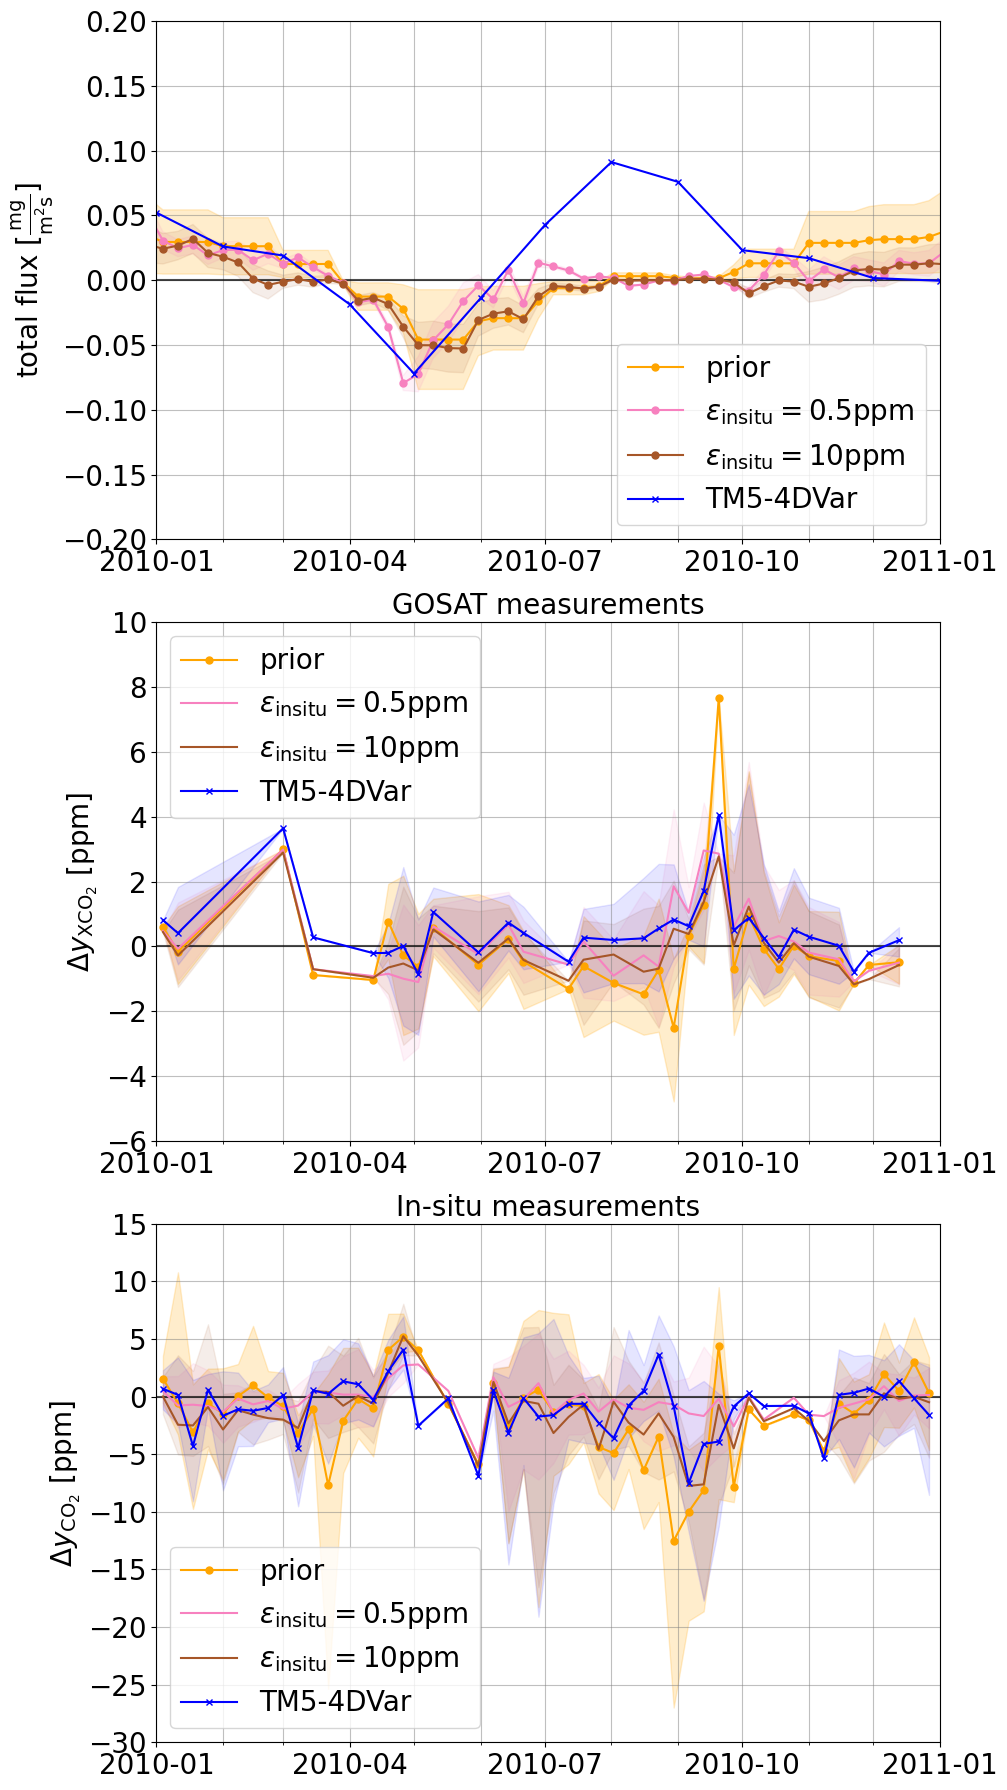

In [3]:
# for variable is meas error
corr_str='with'
f_str= 'spec001_mr_scaled'
bg_str = 'RemoTeC_2.4.0+IS'
res=2
ref_flux=xr.open_dataset(f'/work/bb1170/RUN/b382762/data/TM5Inversion/glb3x2_20220413_new_gridded_flux/flux_{res}x{res}_{bg_str}_cut.nc')
start_date=dt.date(2009,10,1)
end_date=dt.date(2011,3,31)

# select region
# lat_sel, lon_sel = 39, -95
# lat_sel, lon_sel = 33, -119
lat_sel, lon_sel = 37, -97


ms=5

# gosat_err_list=[0.25,0.5,0.8,1,1.2,1.5,2,2.5,3]
# cmap = mpl.colormaps['Reds']
# # Take colors at regular intervals spanning the colormap.
# colors = cmap(np.linspace(0.5, 0.9, len(gosat_err_list)))

# only use min and max error value, all other located in between
gosat_err_val=1
meas_err_list=[0.5,10]
colors=['#f781bf', '#a65628']


for (lat_sel, lon_sel) in [(37, -97)]:      #, (31, -97)
    nrows=1
    # read ref flux
    ref_flux_sel=ref_flux.sel(latitude=lat_sel, longitude=lon_sel)*1e6
    
    for i in range(0,len(meas_err_list)):
        meas_err_val=meas_err_list[i]
        # read flux data
        data_dir=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/{res}x{res}/{corr_str}_correlation/footprint_{f_str}/{gosat_err_val}ppm_gosat_meas_err/{meas_err_val}ppm_insitu_meas_err/'
        inv_data=xr.open_dataset(f'{data_dir}/{start_date.strftime("%Y%m%d")}-{end_date.strftime("%Y%m%d")}_{bg_str}_bg.nc')
        inv_data_sel=inv_data.sel(latitude=lat_sel, longitude=lon_sel)*1e6
        # read weekly meas data
        gosat_weekly=xr.open_dataset(f'{data_dir}/weekly_data/gosat_data_weekly_mean_2010_RemoTeC_2.4.0+IS_bg.nc').sel(release_box_lat=lat_sel, release_box_lon=lon_sel).dropna(dim='release_week', how='all')
        is_weekly=xr.open_dataset(f'{data_dir}/weekly_data/is_data_weekly_mean_2010_RemoTeC_2.4.0+IS_bg.nc').sel(release_box_lat=lat_sel, release_box_lon=lon_sel).dropna(dim='release_week', how='all')
        if i==0:
            # check if there are gosat meas
            if gosat_weekly.release_week.size>0:
                nrows+=1
            # check for is meas
            if is_weekly.release_week.size>0:
                nrows+=1
            # create fig with right amount of rows
            fig,ax=plt.subplots(nrows,1,figsize=(10,nrows*6))
            for k in range(len(ax)):
                ax[k].hlines(0,dt.date(2010,1,1), dt.date(2011,1,1), color='black', alpha=0.7)
            # plot just once prior
            # fluxes
            ax[0].plot(inv_data_sel.time, inv_data_sel.TM5_prior_flux, c='orange',marker='o',markersize=ms, label='prior')
            ax[0].fill_between(inv_data_sel.time, inv_data_sel.TM5_prior_flux-inv_data_sel.prior_uncertainty, inv_data_sel.TM5_prior_flux+inv_data_sel.prior_uncertainty, color='orange', alpha=0.2)
            # measurements and prior val
            if gosat_weekly.release_week.size>0:
                ax[1].set_title('GOSAT measurements', fontsize=20)
                ax[1].plot(gosat_weekly.release_week, gosat_weekly['prior_diff'],color='orange',marker='o',markersize=ms,  label='prior')
                ax[1].fill_between(gosat_weekly.release_week,gosat_weekly['prior_diff_min'],gosat_weekly['prior_diff_max'], color='orange', alpha=0.2)
            if is_weekly.release_week.size>0:
                ax[nrows-1].set_title('In-situ measurements', fontsize=20)
                ax[nrows-1].plot(is_weekly.release_week, is_weekly['prior_diff'],color='orange',marker='o',markersize=ms,  label='prior')
                ax[nrows-1].fill_between(is_weekly.release_week,is_weekly['prior_diff_min'],is_weekly['prior_diff_max'], color='orange', alpha=0.2)
        # plot posterior fluxes
        ax[0].plot(inv_data_sel.time, inv_data_sel.TM5_posterior_flux, c=colors[i], marker='o', markersize=ms, label=fr'$\epsilon_\mathrm{{insitu}}={meas_err_val}\mathrm{{ppm}}$')
        ax[0].fill_between(inv_data_sel.time, inv_data_sel.TM5_posterior_flux-inv_data_sel.TM5_posterior_std, inv_data_sel.TM5_posterior_flux+inv_data_sel.TM5_posterior_std, color=colors[i], alpha=0.1)

        # plot measurements
        if gosat_weekly.release_week.size>0:
            ax[1].plot(gosat_weekly.release_week, gosat_weekly['posterior_diff'], color=colors[i],  label=fr'$\epsilon_\mathrm{{insitu}}={meas_err_val}\mathrm{{ppm}}$')
            ax[1].fill_between(gosat_weekly.release_week, gosat_weekly['posterior_diff_min'], gosat_weekly['posterior_diff_max'], color=colors[i], alpha=0.1)
        if is_weekly.release_week.size>0:
            ax[nrows-1].plot(is_weekly.release_week, is_weekly['posterior_diff'], color=colors[i],  label=fr'$\epsilon_\mathrm{{insitu}}={meas_err_val}\mathrm{{ppm}}$')
            ax[nrows-1].fill_between(is_weekly.release_week, is_weekly['posterior_diff_min'], is_weekly['posterior_diff_max'], color=colors[i], alpha=0.1)
        
        # get average difference to meas for July to september
        print('average difference to meas for July to september:')
        print(meas_err_val)
        print('gosat posterior_diff:', gosat_weekly.sel(release_week=slice(dt.date(2010,7,1), dt.date(2010,8,30))).posterior_diff.mean().item())
        print('gosat TM5_molefrac_diff_interpolated:', gosat_weekly.sel(release_week=slice(dt.date(2010,7,1), dt.date(2010,8,30))).TM5_molefrac_diff_interpolated.mean().item())
        print('is posterior_diff:', is_weekly.sel(release_week=slice(dt.date(2010,7,1), dt.date(2010,8,30))).posterior_diff.mean().item())
        print('is TM5_molefrac_diff_interpolated:', is_weekly.sel(release_week=slice(dt.date(2010,7,1), dt.date(2010,8,30))).TM5_molefrac_diff_interpolated.mean().item())
        
        # get oveall measurement difference
        print('overall average difference to meas for 2010:')
        print('gosat posterior_diff:', gosat_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).posterior_diff.mean().item())
        print('gosat TM5_molefrac_diff_interpolated:', gosat_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).TM5_molefrac_diff_interpolated.mean().item())
        print('is posterior_diff:', is_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).posterior_diff.mean().item())
        print('is TM5_molefrac_diff_interpolated:', is_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).TM5_molefrac_diff_interpolated.mean().item(),'\n')

        # get oveall absolute mean difference
        print('overall absolute mean diff to meas for 2010:')
        print('gosat posterior_diff:', np.abs(gosat_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).posterior_diff).mean().item())
        print('gosat TM5_molefrac_diff_interpolated:', np.abs(gosat_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).TM5_molefrac_diff_interpolated).mean().item())
        print('is posterior_diff:', np.abs(is_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).posterior_diff).mean().item())
        print('is TM5_molefrac_diff_interpolated:', np.abs(is_weekly.sel(release_week=slice(dt.date(2010,1,1), dt.date(2010,12,31))).TM5_molefrac_diff_interpolated).mean().item(),'\n \n')

    # plot reference
    ax[0].plot(ref_flux_sel.time, ref_flux_sel.total_flux,c='b', marker='x', markersize=ms, label='TM5-4DVar')
    if gosat_weekly.release_week.size>0:
        ax[1].plot(gosat_weekly.release_week, gosat_weekly['TM5_molefrac_diff_interpolated'],color='b',marker='x',markersize=ms,  label='TM5-4DVar')
        ax[1].fill_between(gosat_weekly.release_week, gosat_weekly['TM5_molefrac_diff_interpolated_min'], gosat_weekly['TM5_molefrac_diff_interpolated_max'], color='b', alpha=0.1)
        ax[1].set_ylabel(r'$\Delta y_\mathrm{XCO_2}$ [ppm]', fontsize=20)
    if is_weekly.release_week.size>0:
        ax[nrows-1].plot(is_weekly.release_week, is_weekly['TM5_molefrac_diff_interpolated'],color='b',marker='x',markersize=ms,  label='TM5-4DVar')
        ax[nrows-1].fill_between(is_weekly.release_week, is_weekly['TM5_molefrac_diff_interpolated_min'], is_weekly['TM5_molefrac_diff_interpolated_max'], color='b', alpha=0.1)
        ax[nrows-1].set_ylabel(r'$\Delta y_\mathrm{CO_2}$ [ppm]', fontsize=20)

    # ax[0].set_title(fr'$({lat_sel}^\circ\mathrm{{N}}, {-lon_sel}^\circ\mathrm{{W}})$, changing gosat measurement error')
    ax[0].set_ylabel(r'total flux [$\mathrm{\frac{mg}{m^2 s}}$]', fontsize=20)
    for i in range(len(ax)):
        ax[i].set_xlim(dt.date(2010,1,1), dt.date(2011,1,1))
        ax[i].tick_params(labelleft=True, labelsize=20)
        ax[i].legend(fontsize=20)  
        ax[i].grid(which='both', c='grey', alpha=0.5)
        # ax[i].hlines(0,dt.date(2010,1,1), dt.date(2010,12,31), color='black')
        ax[i].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))
        ax[i].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax[0].set_ylim(-0.2,0.2)
    ax[1].set_ylim(-6,10)
    ax[2].set_ylim(-30,15)
    fig.tight_layout()
    fig.savefig(f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/meas_err/variable_meas_err_comp_{lat_sel}{lon_sel}_meas_diff.png')
    # plt.close()

# 5. Results

## 5.1 forward model comp

In [160]:
# prior data
# for insitu data
prior_dir='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/insitu/prep_footprints/high_res/prior_co2_val/'
insitu_prior_files=[prior_dir+f for f in os.listdir(prior_dir) if f.endswith('.nc')]
insitu_prior_files.sort()
insitu_prior=xr.open_mfdataset(insitu_prior_files, combine='nested',concat_dim='pointspec',join='outer')
insitu_prior['pointspec']=np.arange(0,insitu_prior.pointspec.size)

# for gosat data
prior_dir='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/RemoTeCv240/prep_footprints/high_res/prior_co2_val/'
gosat_prior_files=[prior_dir+f for f in os.listdir(prior_dir) if f.endswith('.nc')]
gosat_prior_files.sort()
gosat_prior=xr.open_mfdataset(gosat_prior_files, combine='nested',concat_dim='pointspec',join='outer')
gosat_prior['pointspec']=np.arange(0,gosat_prior.pointspec.size)

# for posterior data
# for insitu data
posterior_dir='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/insitu/prep_footprints/high_res/posterior_RemoTeC_2.4.0+IS_co2_val/'
insitu_posterior_files=[posterior_dir+f for f in os.listdir(posterior_dir) if f.endswith('.nc')]
insitu_posterior_files.sort()
insitu_posterior=xr.open_mfdataset(insitu_posterior_files, combine='nested',concat_dim='pointspec',join='outer')
insitu_posterior['pointspec']=np.arange(0,insitu_posterior.pointspec.size)

# for gosat data
posterior_dir='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/RemoTeCv240/prep_footprints/high_res/posterior_RemoTeC_2.4.0+IS_co2_val/'
gosat_posterior_files=[posterior_dir+f for f in os.listdir(posterior_dir) if f.endswith('.nc')]
gosat_posterior_files.sort()
gosat_posterior=xr.open_mfdataset(gosat_posterior_files, combine='nested',concat_dim='pointspec',join='outer')
gosat_posterior['pointspec']=np.arange(0,gosat_posterior.pointspec.size)

# check that values are equal
print((insitu_posterior[['TM5_RemoTeC_2.4.0+IS_co2','co2_val[ppm]']]==insitu_prior[['TM5_RemoTeC_2.4.0+IS_co2','co2_val[ppm]']]).all().compute())
print((gosat_posterior[['TM5_RemoTeC_2.4.0+IS_xco2','xco2']]==gosat_prior[['TM5_RemoTeC_2.4.0+IS_xco2','xco2']]).all().compute())

<xarray.Dataset> Size: 6B
Dimensions:                   ()
Coordinates:
    height                    float32 4B 30.0
Data variables:
    TM5_RemoTeC_2.4.0+IS_co2  bool 1B True
    co2_val[ppm]              bool 1B True
<xarray.Dataset> Size: 6B
Dimensions:                    ()
Coordinates:
    height                     float32 4B 30.0
Data variables:
    TM5_RemoTeC_2.4.0+IS_xco2  bool 1B True
    xco2                       bool 1B True


In [161]:
# read 2x2 meas to get interpolated  from _new files
is_data=xr.open_dataset('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/insitu/prep_footprints/high_res/scaled_weekly_total/high_res_scaled_footprints_20091001-20110331_2x2_weekly_new.nc')
gosat_data=xr.open_dataset('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/RemoTeCv240/prep_footprints/high_res/scaled_weekly_total/high_res_scaled_footprints_20091001-20110331_2x2_weekly_new.nc')
# compare meas
print((insitu_posterior[['TM5_RemoTeC_2.4.0+IS_co2','co2_val[ppm]']].compute()==is_data[['TM5_RemoTeC_2.4.0+IS_co2','co2_val[ppm]']]).all())
print((gosat_posterior[['TM5_RemoTeC_2.4.0+IS_xco2','xco2']].compute()==gosat_data[['TM5_RemoTeC_2.4.0+IS_xco2','xco2']]).all())


<xarray.Dataset> Size: 6B
Dimensions:                   ()
Coordinates:
    height                    float32 4B 30.0
Data variables:
    TM5_RemoTeC_2.4.0+IS_co2  bool 1B True
    co2_val[ppm]              bool 1B True
<xarray.Dataset> Size: 6B
Dimensions:                    ()
Coordinates:
    height                     float32 4B 30.0
Data variables:
    TM5_RemoTeC_2.4.0+IS_xco2  bool 1B True
    xco2                       bool 1B True


In [162]:
# get difference values
# prior difference
insitu_prior['prior_diff']=insitu_prior['prior_val']-insitu_prior['co2_val[ppm]']+insitu_prior['TM5_RemoTeC_2.4.0+IS_background']
gosat_prior['prior_diff']=gosat_prior['prior_val']-gosat_prior['xco2']+gosat_prior['TM5_RemoTeC_2.4.0+IS_background']

# posterior difference
insitu_prior['posterior_diff']=insitu_posterior['RemoTeC_2.4.0+IS_val']-insitu_posterior['co2_val[ppm]']+insitu_posterior['TM5_RemoTeC_2.4.0+IS_background']
gosat_prior['posterior_diff']=gosat_posterior['RemoTeC_2.4.0+IS_val']-gosat_posterior['xco2']+gosat_posterior['TM5_RemoTeC_2.4.0+IS_background']

# molefraction difference
# with interpolated data
insitu_prior['TM5_molefrac_diff_interp']=is_data['TM5_RemoTeC_2.4.0+IS_co2_interpolated']-is_data['co2_val[ppm]']
gosat_prior['TM5_molefrac_diff_interp']=gosat_data['TM5_RemoTeC_2.4.0+IS_xco2_interpolated']-gosat_data['xco2']
# without interpolation
insitu_prior['TM5_molefrac_diff']=is_data['TM5_RemoTeC_2.4.0+IS_co2']-is_data['co2_val[ppm]']
gosat_prior['TM5_molefrac_diff']=gosat_data['TM5_RemoTeC_2.4.0+IS_xco2']-gosat_data['xco2']


# select data for 2010
insitu_prior=insitu_prior.where(insitu_prior.release_time.dt.year.compute()==2010, drop=True)
gosat_prior=gosat_prior.where(gosat_prior.release_time.dt.year.compute()==2010, drop=True)

# cut to inner region
gosat_prior=gosat_prior.where((gosat_prior.release_lat.compute()>=interp_region[0])&(gosat_prior.release_lat.compute()<=interp_region[1]) & (gosat_prior.release_lon.compute()>=interp_region[2])&(gosat_prior.release_lon.compute()<=interp_region[3]), drop=True)
insitu_prior=insitu_prior.where((insitu_prior.release_lat.compute()>=interp_region[0])&(insitu_prior.release_lat.compute()<=interp_region[1]) & (insitu_prior.release_lon.compute()>=interp_region[2])&(insitu_prior.release_lon.compute()<=interp_region[3]), drop=True)

# get mean and std
insitu_mean=insitu_prior.mean()
insitu_std=insitu_prior.std()
gosat_mean=gosat_prior.mean()
gosat_std=gosat_prior.std()

10.0 36.0


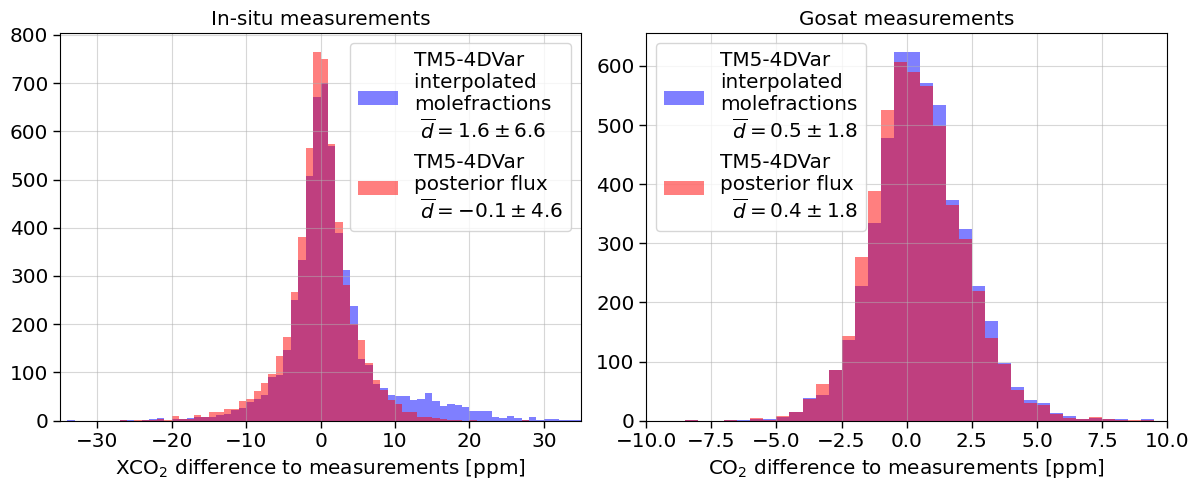

In [173]:
WITH_PRIOR=False

# get max val from 'TM5_molefrac_diff', 'prior_diff', 'posterior_diff'
gosat_max=np.ceil(np.max(np.abs(gosat_prior[['TM5_molefrac_diff', 'prior_diff']]).to_array()).compute().item())
insitu_max=np.ceil(np.max(np.abs(insitu_prior[['TM5_molefrac_diff', 'prior_diff']]).to_array()).compute().item())

# def bins
bin_size=1
gosat_bins=np.arange(-gosat_max, gosat_max, step=bin_size/2)
insitu_bins=np.arange(-insitu_max, insitu_max, step=bin_size)
# plot
fig, ax=plt.subplots(1,2,figsize=(12,5))
# fig.suptitle('High resolution footprints, entire region')
# ax[0].hist(insitu_prior.TM5_molefrac_diff, insitu_bins,color='blue',alpha=0.5,  label=fr'TM5-4DVar molefractions, $\overline{{d}}={np.round((insitu_mean.TM5_molefrac_diff).compute().item(),1)}, \overline{{|d|}}={np.round(np.mean(np.abs(insitu_prior.TM5_molefrac_diff)).compute().item(),1)}$')
ax[0].hist(insitu_prior.TM5_molefrac_diff_interp, insitu_bins,color='blue',alpha=0.5,  
           label=fr'TM5-4DVar ''\n' 'interpolated ''\n' 'molefractions'
           '\n' fr' $\overline{{d}}={np.round((insitu_mean.TM5_molefrac_diff_interp).compute().item(),1)}\pm{np.round(insitu_std.TM5_molefrac_diff_interp.item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(insitu_prior.TM5_molefrac_diff_interp)).compute().item(),1)}$')
ax[0].hist(insitu_prior.posterior_diff, insitu_bins, color='red', alpha=0.5,  
           label=fr'TM5-4DVar ''\n' 'posterior flux'
           '\n' fr' $\overline{{d}}={np.round((insitu_mean.posterior_diff).compute().item(),1)}\pm{np.round(insitu_std.posterior_diff.compute().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(insitu_prior.posterior_diff)).compute().item(),1)}$')
if WITH_PRIOR:
    ax[0].hist(insitu_prior.prior_diff, insitu_bins, color='orange', alpha=0.5,  
            label=fr'TM5-4DVar prior flux''\n' fr' $\overline{{d}}={np.round((insitu_mean.prior_diff).compute().item(),1)}\pm{np.round(insitu_std.prior_diff.compute().item(),1)}$')
            # , \overline{{|d|}}={np.round(np.mean(np.abs(insitu_prior.prior_diff)).compute().item(),1)}$')
ax[0].set_xlabel(r'$\mathrm{XCO_2}$ difference to measurements [ppm]', fontsize='x-large')
ax[1].hist(gosat_prior.TM5_molefrac_diff_interp, gosat_bins,color='blue',alpha=0.5,  
           label=fr'TM5-4DVar ''\n' 'interpolated''\n' 'molefractions'
           '\n' fr'  $\overline{{d}}={np.round((gosat_mean.TM5_molefrac_diff_interp).compute().item(),1)}\pm{np.round(gosat_std.TM5_molefrac_diff_interp.compute().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(gosat_prior.TM5_molefrac_diff_interp)).compute().item(),1)}$')
# ax[1].hist(gosat_prior.TM5_molefrac_diff, gosat_bins,color='blue',alpha=0.5,  label=fr'TM5-4DVar molefractions, $\overline{{d}}={np.round((gosat_mean.TM5_molefrac_diff).compute().i$')tem(),1)}
# # , \overline{{|d|}}={np.round(np.mean(np.abs(gosat_prior.TM5_molefrac_diff)).compute().item(),1)}$')
ax[1].hist(gosat_prior.posterior_diff, gosat_bins, color='red', alpha=0.5,  
           label=fr'TM5-4DVar''\n' 'posterior flux'
           '\n' fr'  $\overline{{d}}={np.round((gosat_mean.posterior_diff).compute().item(),1)}\pm{np.round(gosat_std.posterior_diff.compute().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(gosat_prior.posterior_diff)).compute().item(),1)}$')
if WITH_PRIOR:
    ax[1].hist(gosat_prior.prior_diff, gosat_bins, color='orange', alpha=0.5,  
            label=fr'TM5-4DVar prior flux''\n' fr'  $\overline{{d}}={np.round((gosat_mean.prior_diff).compute().item(),1)}\pm{np.round(gosat_std.prior_diff.compute().item(),1)}$')
            # , \overline{{|d|}}={np.round(np.mean(np.abs(gosat_prior.prior_diff)).compute().item(),1)}$')
ax[1].set_xlabel(r'$\mathrm{CO_2}$ difference to measurements [ppm]', fontsize='x-large')
ax[0].set_title(f'In-situ measurements', fontsize='x-large')  #, n={insitu_prior.pointspec.size}')
ax[1].set_title(f'Gosat measurements', fontsize='x-large')   #, n={gosat_prior.pointspec.size}')
for i in range(0,len(ax)):
    ax[i].grid(alpha=0.5)
    ax[i].legend(fontsize='x-large')  #fontsize='small'
    ax[i].tick_params(axis='both', which='both', labelsize='x-large', width=1, length=5)
ax[0].set_xlim(-35,35)
ax[1].set_xlim(-10,10)
fig.tight_layout()
# fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/insitu/prep_footprints/high_res/prior_co2_val/meas_diff_hist_inner_region.png')
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Results/forward_model_comp_hist_diff_without_d.png', dpi=300, bbox_inches='tight')

print(gosat_max, insitu_max)

## 5.2 modeled measurement values

In [2]:
corr_str='with'
meas_err_val=2
gosat_err_val=1

data_dir='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/with_correlation/footprint_spec001_mr_scaled/1ppm_gosat_meas_err/2ppm_insitu_meas_err/'
inv_data=xr.open_dataset(f'{data_dir}20091001-20110331_RemoTeC_2.4.0+IS_bg.nc')
gosat_data=xr.open_dataset(f'{data_dir}/gosat_data_2x2_20091001-20110331_RemoTeC_2.4.0+IS_bg.nc')
is_data=xr.open_dataset(f'{data_dir}/insitu_data_2x2_20091001-20110331_RemoTeC_2.4.0+IS_bg.nc')
gosat_weekly=xr.open_dataset(f'{data_dir}/weekly_data/gosat_data_weekly_mean_2010_RemoTeC_2.4.0+IS_bg.nc')
is_weekly=xr.open_dataset(f'{data_dir}/weekly_data/is_data_weekly_mean_2010_RemoTeC_2.4.0+IS_bg.nc')

### plot timeseries

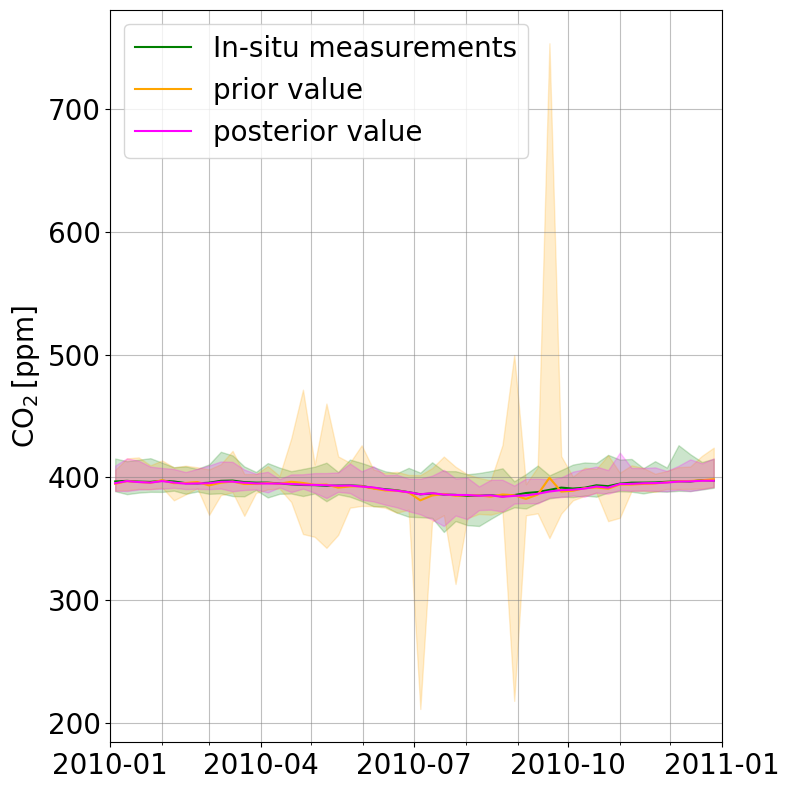

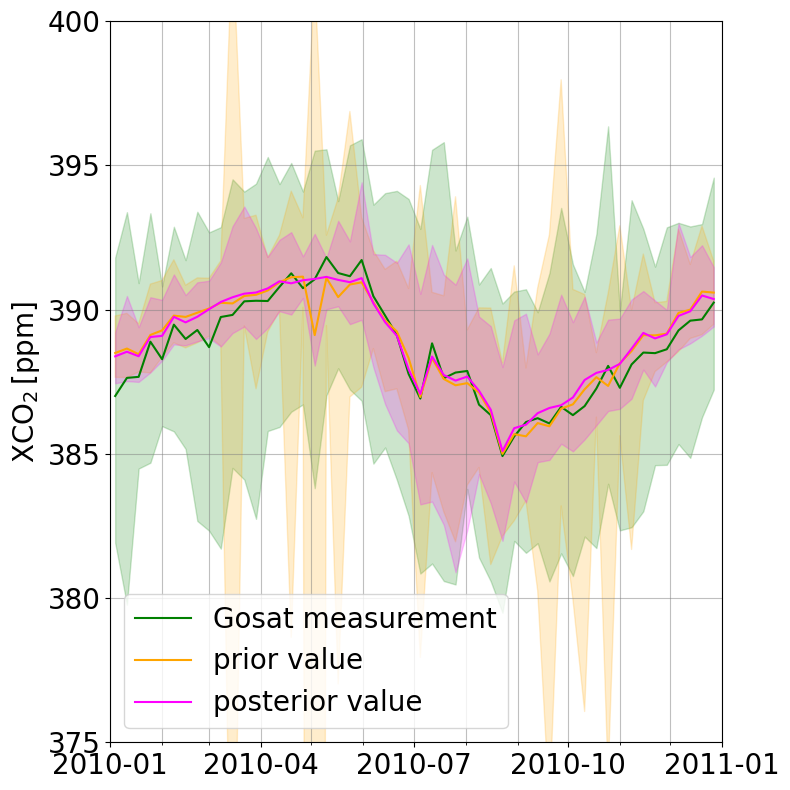

In [5]:
WITH_PRIOR=True
# select inner area
is_weekly_inner=is_weekly.sel(release_box_lat=slice(20,48), release_box_lon=slice(-126,-70))
gosat_weekly_inner=gosat_weekly.sel(release_box_lat=slice(20,48), release_box_lon=slice(-126,-70))

# plot meas and posterior range
fig, ax=plt.subplots(figsize=(8,8))
# measurements
ax.plot(is_weekly_inner.release_week, is_weekly_inner['co2_val[ppm]'].mean(dim=['release_box_lat', 'release_box_lon']), color='g', label='In-situ measurements')
ax.fill_between(is_weekly_inner.release_week,is_weekly_inner['co2_val[ppm]_min'].min(dim=['release_box_lat', 'release_box_lon']), is_weekly_inner['co2_val[ppm]_max'].max(dim=['release_box_lat', 'release_box_lon']),color='g', alpha=0.2)
# prior value
if WITH_PRIOR:
    ax.plot(is_weekly_inner.release_week, is_weekly_inner['prior_val+bg'].mean(dim=['release_box_lat', 'release_box_lon']), color='orange', label='prior value')
    ax.fill_between(is_weekly_inner.release_week,is_weekly_inner['prior_val+bg_min'].min(dim=['release_box_lat', 'release_box_lon']), is_weekly_inner['prior_val+bg_max'].max(dim=['release_box_lat', 'release_box_lon']),color='orange', alpha=0.2)
ax.plot(is_weekly_inner.release_week, is_weekly_inner['posterior_val+bg'].mean(dim=['release_box_lat', 'release_box_lon']), color='magenta', label='posterior value')
ax.fill_between(is_weekly_inner.release_week,is_weekly_inner['posterior_val+bg_min'].min(dim=['release_box_lat', 'release_box_lon']), is_weekly_inner['posterior_val+bg_max'].max(dim=['release_box_lat', 'release_box_lon']),color='magenta', alpha=0.2)
# 
ax.set_ylabel(r'$\mathrm{CO_2\,[ppm]}$', fontsize=20)
ax.set_xlim(dt.date(2010,1,1), dt.date(2011,1,1))
# ax.set_ylim(350,430)
ax.tick_params(labelleft=True, labelsize=20)
ax.legend(fontsize=20)  
ax.grid(which='both', c='grey', alpha=0.5)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.tight_layout()
if WITH_PRIOR:
    fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Results/is_weekly_meas_posterior_values_with_prior.png', dpi=300, bbox_inches='tight')
else:
    fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Results/is_weekly_meas_posterior_values.png', dpi=300, bbox_inches='tight')

fig, ax=plt.subplots(figsize=(8,8))
# measurements
ax.plot(gosat_weekly_inner.release_week, gosat_weekly_inner['xco2'].mean(dim=['release_box_lat', 'release_box_lon']), color='g', label='Gosat measurement')
ax.fill_between(gosat_weekly_inner.release_week,gosat_weekly_inner['xco2_min'].min(dim=['release_box_lat', 'release_box_lon']), gosat_weekly_inner['xco2_max'].max(dim=['release_box_lat', 'release_box_lon']),color='g', alpha=0.2)
# prior
if WITH_PRIOR:
    ax.plot(gosat_weekly_inner.release_week, gosat_weekly_inner['prior_val+bg'].mean(dim=['release_box_lat', 'release_box_lon']), color='orange', label='prior value')
    ax.fill_between(gosat_weekly_inner.release_week,gosat_weekly_inner['prior_val+bg_min'].min(dim=['release_box_lat', 'release_box_lon']), gosat_weekly_inner['prior_val+bg_max'].max(dim=['release_box_lat', 'release_box_lon']),color='orange', alpha=0.2)
# posterior estimates
ax.plot(gosat_weekly_inner.release_week, gosat_weekly_inner['posterior_val+bg'].mean(dim=['release_box_lat', 'release_box_lon']), color='magenta', label='posterior value')
ax.fill_between(gosat_weekly_inner.release_week,gosat_weekly_inner['posterior_val+bg_min'].min(dim=['release_box_lat', 'release_box_lon']), gosat_weekly_inner['posterior_val+bg_max'].max(dim=['release_box_lat', 'release_box_lon']),color='magenta', alpha=0.2)
# 
ax.set_ylabel(r'$\mathrm{XCO_2\,[ppm]}$', fontsize=20)
ax.set_xlim(dt.date(2010,1,1), dt.date(2011,1,1))
# ax.set_ylim(350,430)
ax.set_ylim(375,400)
ax.tick_params(labelleft=True, labelsize=20)
ax.legend(fontsize=20)  
ax.grid(which='both', c='grey', alpha=0.5)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.tight_layout()
if WITH_PRIOR:
    fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Results/gosat_weekly_meas_posterior_values_with_prior.png', dpi=300, bbox_inches='tight')
else:
    fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Results/gosat_weekly_meas_posterior_values.png', dpi=300, bbox_inches='tight')


### Difference histogramm

In [3]:
# read meas data

# 20,48,-126,-70
gosat_data
is_data
# select measurements during 2010, in inner region
gosat_data_inner=gosat_data.where((gosat_data.release_lat>=interp_region[0])&(gosat_data.release_lat<=interp_region[1]) & (gosat_data.release_lon>=interp_region[2])&(gosat_data.release_lon<=interp_region[3]) & (gosat_data.release_time.dt.year==2010), drop=True)
is_data_inner=is_data.where((is_data.release_lat>=interp_region[0])&(is_data.release_lat<=interp_region[1]) & (is_data.release_lon>=interp_region[2])&(is_data.release_lon<=interp_region[3]) & (is_data.release_time.dt.year==2010), drop=True)
is_data_inner

<xarray.Dataset> Size: 796kB
Dimensions:                                (pointspec: 5530)
Coordinates:
  * pointspec                              (pointspec) int64 44kB 1846 ... 10252
    height                                 float32 4B 30.0
Data variables: (12/17)
    release_time                           (pointspec) datetime64[ns] 44kB 20...
    release_lat                            (pointspec) float64 44kB 33.41 ......
    release_lon                            (pointspec) float64 44kB -81.83 .....
    co2_val[ppm]                           (pointspec) float64 44kB 403.9 ......
    TM5_RemoTeC_2.4.0+IS_background        (pointspec) float64 44kB 390.6 ......
    TM5_RemoTeC_2.4.0+IS_co2               (pointspec) float64 44kB 401.0 ......
    ...                                     ...
    TM5_molefrac_diff                      (pointspec) float64 44kB -2.873 .....
    TM5_molefrac_diff_interpolated         (pointspec) float64 44kB -3.881 .....
    prior_diff                             (pointspec) float64 44kB 1.982 ......
    posterior_diff                         (pointspec) float64 44kB 2.065 ......
    ref_IS_diff                            (pointspec) float64 44kB 0.1478 .....
    ref_RemoteC_IS_diff                    (pointspec) float64 44kB 0.1961 .....
Attributes: (12/37)
    Conventions:            CF-1.6
    title:                  FLEXPART model output
    git:                    682d874 Tue Jul 2 10:56:37 2024 +0200
    source:                 Version 11.0 (2023-07-11) model output
    history:                2025-03-19 14:24 +0100  created by b382762 on l40...
    references:             Stohl et al., Atmos. Chem. Phys., 2005, doi:10.51...
    ...                     ...
    ind_source:             1
    ind_receptor:           2
    mquasilag:              0
    nested_output:          0
    sfc_only:               0
    linit_cond:             0

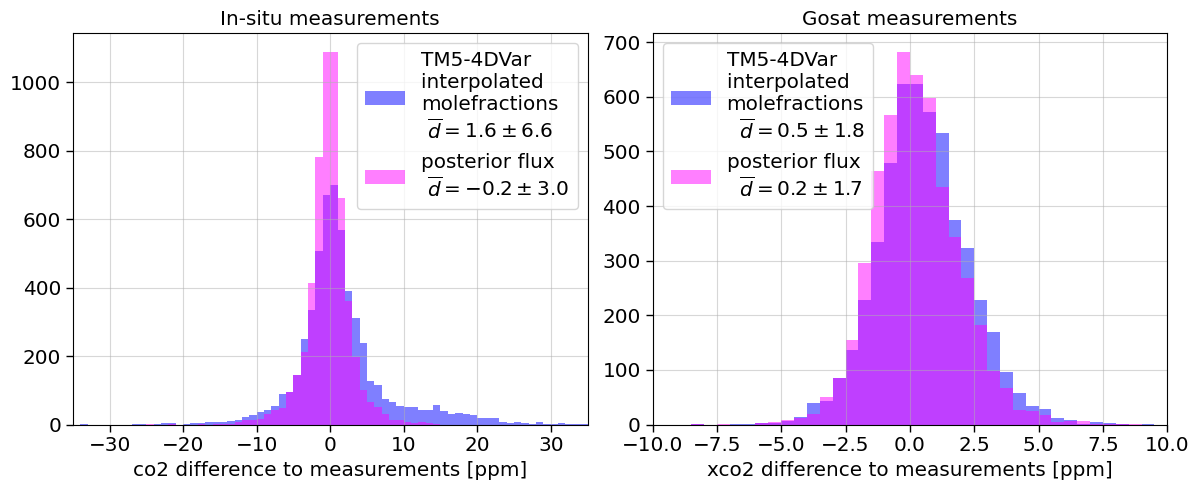

In [180]:

# get max val from 'TM5_molefrac_diff', 'prior_diff', 'posterior_diff'
# gosat_max=np.ceil(np.max(np.abs(gosat_data_inner[['TM5_molefrac_diff_interpolated', 'prior_diff','posterior_diff']]).to_array()).item())
# insitu_max=np.ceil(np.max(np.abs(is_data_inner[['TM5_molefrac_diff_interpolated', 'prior_diff','posterior_diff']]).to_array()).item())
# # def bins
# bin_size=1
# gosat_bins=np.arange(-gosat_max, gosat_max, step=bin_size/2)
# insitu_bins=np.arange(-insitu_max, insitu_max, step=bin_size)

# set bins manually
#10.0 36.0
gosat_bins=np.arange(-10, 10, step=0.5)
insitu_bins=np.arange(-36, 36, step=1)

WITH_PRIOR=False

# plot
fig, ax=plt.subplots(1,2,figsize=(12,5))
ax[0].hist(is_data_inner.TM5_molefrac_diff_interpolated, insitu_bins,color='blue',alpha=0.5,  
           label=fr'TM5-4DVar''\n' 'interpolated ''\n' 'molefractions''\n' fr' $\overline{{d}}={np.round((is_data_inner.TM5_molefrac_diff_interpolated.mean()).item(),1)}\pm{np.round(is_data_inner.TM5_molefrac_diff_interpolated.std().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(is_data_inner.TM5_molefrac_diff_interpolated)).item(),1)}$')
if WITH_PRIOR:
    ax[0].hist(is_data_inner.prior_diff, insitu_bins, color='orange', alpha=0.5,  label=fr'prior flux''\n' fr' $\overline{{d}}={np.round((is_data_inner.prior_diff.mean()).item(),1)}\pm{np.round(is_data_inner.prior_diff.std().item(),1)}$')# , \overline{{|d|}}={np.round(np.mean(np.abs(is_data_inner.prior_diff)).item(),1)}$')
ax[0].hist(is_data_inner.posterior_diff, insitu_bins, color='magenta', alpha=0.5,  
           label=fr'posterior flux''\n' fr' $\overline{{d}}={np.round((is_data_inner.posterior_diff.mean()).item(),1)}\pm{np.round(is_data_inner.posterior_diff.std().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(is_data_inner.posterior_diff)).item(),1)}$')
ax[0].set_xlabel('co2 difference to measurements [ppm]', fontsize='x-large')
ax[1].hist(gosat_data_inner.TM5_molefrac_diff_interpolated, gosat_bins,color='blue',alpha=0.5,  
           label=fr'TM5-4DVar''\n' 'interpolated ''\n' 'molefractions''\n' fr'  $\overline{{d}}={np.round((gosat_data_inner.TM5_molefrac_diff_interpolated.mean()).item(),1)}\pm{np.round(gosat_data_inner.TM5_molefrac_diff_interpolated.std().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(gosat_data_inner.TM5_molefrac_diff_interpolated)).item(),1)}$')
if WITH_PRIOR:
    ax[1].hist(gosat_data_inner.prior_diff, gosat_bins, color='orange', alpha=0.5,  label=fr'prior flux''\n' fr'  $\overline{{d}}={np.round((gosat_data_inner.prior_diff.mean()).item(),1)}\pm{np.round(gosat_data_inner.prior_diff.std().item(),1)}$')# , \overline{{|d|}}={np.round(np.mean(np.abs(gosat_data_inner.prior_diff)).item(),1)}$')    
ax[1].hist(gosat_data_inner.posterior_diff, gosat_bins, color='magenta', alpha=0.5,  
           label=fr'posterior flux''\n' fr'  $\overline{{d}}={np.round((gosat_data_inner.posterior_diff.mean()).item(),1)}\pm{np.round(gosat_data_inner.posterior_diff.std().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(gosat_data_inner.posterior_diff)).item(),1)}$')
ax[1].set_xlabel('xco2 difference to measurements [ppm]', fontsize='x-large')
ax[0].set_title(f'In-situ measurements', fontsize='x-large')  #, n={is_data_inner.pointspec.size}')
ax[1].set_title(f'Gosat measurements', fontsize='x-large')   #, n={gosat_data_inner.pointspec.size}')
for i in range(0,len(ax)):
    ax[i].grid(alpha=0.5)
    ax[i].legend(fontsize='x-large')  #fontsize='small'
    ax[i].tick_params(axis='both', which='both', labelsize='x-large', width=1, length=5)
ax[0].set_xlim(-35,35)
ax[1].set_xlim(-10,10)
fig.tight_layout()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Results/posterior_meas_comp_hist_diff.png', dpi=300, bbox_inches='tight')

## 5.3 monthly NEE maps

In [33]:
data_dir='/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/with_correlation/footprint_spec001_mr_scaled/1ppm_gosat_meas_err/2ppm_insitu_meas_err/'
inv_data=xr.open_dataset(f'{data_dir}20091001-20110331_RemoTeC_2.4.0+IS_bg.nc')
gosat_data=xr.open_dataset(f'{data_dir}/gosat_data_2x2_20091001-20110331_RemoTeC_2.4.0+IS_bg.nc')
is_data=xr.open_dataset(f'{data_dir}/insitu_data_2x2_20091001-20110331_RemoTeC_2.4.0+IS_bg.nc')
gosat_weekly=xr.open_dataset(f'{data_dir}/weekly_data/gosat_data_weekly_mean_2010_RemoTeC_2.4.0+IS_bg.nc')
is_weekly=xr.open_dataset(f'{data_dir}/weekly_data/is_data_weekly_mean_2010_RemoTeC_2.4.0+IS_bg.nc')
# read boudary file
gdf = geopandas.read_file("/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/east_west_region_boundaries.geojson")

ref_weekly=xr.open_dataset('/work/bb1170/RUN/b382762/data/TM5Inversion/glb3x2_20220413_new_gridded_flux/flux_2x2_RemoTeC_2.4.0+IS_cut_weekly.nc')
# plot for monthly TM5-4DVar reference, on 3x2 grid
ref_monthly=xr.open_dataset('/work/bb1170/RUN/b382762/data/TM5Inversion/glb3x2_20220413_new_gridded_flux/flux_1x1_RemoTeC_2.4.0+IS_cut.nc') # in gC/m^2/day
# get nee flux in kgCO2/(m^2 s)
for col in ['CO2_flux_nee','CO2_flux_fire','CO2_flux_oce', 'CO2_flux_fos']:
    ref_monthly[col]=(ref_monthly[col]*44/12*1e-3/(24*60*60)).assign_attrs(units='kgCO2/(m^2 s)')
ref_monthly=ref_monthly*1e6     # kgCO2 -> mgCO2
# add grid_cell_area to flux data
inv_data['grid_cell_area']=ref_weekly.grid_cell_area

In [34]:
# get NEE flux from posterior
inv_data['posterior_NEE']=inv_data.TM5_posterior_flux-ref_weekly.CO2_flux_fire-ref_weekly.CO2_flux_oce-ref_weekly.CO2_flux_fos
inv_data['prior_NEE']=inv_data.TM5_prior_flux-ref_weekly.CO2_flux_fire-ref_weekly.CO2_flux_oce-ref_weekly.CO2_flux_fos
# get monthly mean
inv_monhtly=inv_data[['TM5_prior_flux','TM5_posterior_flux', 'posterior_NEE', 'prior_NEE','grid_cell_area']].reindex(time=pd.date_range(dt.date(2010,1,1),dt.date(2010,12,31)), method='ffill')
inv_monhtly=inv_monhtly.resample(time='MS').mean()*1e6
inv_monhtly

<xarray.Dataset> Size: 380kB
Dimensions:             (latitude: 22, longitude: 36, time: 12)
Coordinates:
  * latitude            (latitude) float32 88B 13.0 15.0 17.0 ... 51.0 53.0 55.0
  * longitude           (longitude) float32 144B -133.0 -131.0 ... -65.0 -63.0
    height              float32 4B 30.0
  * time                (time) datetime64[ns] 96B 2010-01-01 ... 2010-12-01
Data variables:
    TM5_prior_flux      (time, latitude, longitude) float64 76kB 0.0004682 .....
    TM5_posterior_flux  (time, latitude, longitude) float64 76kB 0.0004879 .....
    posterior_NEE       (time, latitude, longitude) float64 76kB 0.0004395 .....
    prior_NEE           (time, latitude, longitude) float64 76kB 0.0004198 .....
    grid_cell_area      (time, latitude, longitude) float64 76kB 4.819e+16 .....

In [35]:
print(inv_monhtly.sel(latitude=41, longitude=-93,time='2010-8-1').posterior_NEE.item())
inv_monhtly.sel(latitude=slice(41-2, 41+2), longitude=slice(-93-2,-93+2),time='2010-8-1').where(~((inv_monhtly.latitude==41)&(inv_monhtly.longitude==-93))).posterior_NEE.mean()

0.07985607324542053


<xarray.DataArray 'posterior_NEE' ()> Size: 8B
array(-0.11419034)
Coordinates:
    height   float32 4B 30.0
    time     datetime64[ns] 8B 2010-08-01

In [5]:
# read boudary file
gdf = geopandas.read_file("/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/east_west_region_boundaries.geojson")

fig, ax=plt.subplots(4,3,figsize=(18,20), subplot_kw={'projection': ccrs.PlateCarree()}, sharex=True, sharey=True)
ax=ax.flatten()
for i in range(0,len(ax)):
    t= inv_monhtly.time.values[i]
    img = inv_monhtly.sel(time=t).posterior_NEE.plot(ax=ax[i],vmin=-3e-1, vmax=3e-1, cmap='RdBu_r',add_colorbar=False)
    ax[i].set_title(pd.to_datetime(t).strftime('%B'), fontsize=20)
    
    ax[i].set_xlabel('longitude')
    ax[i].set_ylabel('latitude')
    # Add coastlines
    ax[i].coastlines(linewidth=0.5, alpha=0.3)
    # Add U.S. state borders
    ax[i].add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
    gl = ax[i].gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    # if i % 3 != 0:
    #     gl.left_labels = False
    # if i < 8:
    #     gl.bottom_labels = False
    gl.ylabel_style = {'size': 20}
    gl.xlabel_style = {'size': 20}
    ax[i].grid(c='lightgrey')
    ax[i].set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
    ax[i].set_ylim(12,56)
    for _, row in gdf.iterrows():
        ax[i].plot(*row.geometry.exterior.xy,transform=ccrs.PlateCarree(),color='brown', linewidth=1)
fig.tight_layout(rect=[0, 0.15, 1,1])

fig.subplots_adjust(bottom=0.1)  # Leave space at the bottom for the colorbar
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])  # [left, bottom, width, height]
cbar=fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'NEE flux [$\mathrm{\frac{mg}{m^2 s}}$]')  
cbar.ax.xaxis.label.set_size(20)
cbar.ax.tick_params(labelsize=20)
# plt.show()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Results/monthly_posterior_NEE_maps.png')
plt.close()

In [197]:
# same plot for monthly TM5-4DVar reference fluxes
# read boudary file
gdf = geopandas.read_file("/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/east_west_region_boundaries.geojson")

fig, ax=plt.subplots(4,3,figsize=(18,20), subplot_kw={'projection': ccrs.PlateCarree()}, sharex=True, sharey=True)
ax=ax.flatten()
for i in range(0,len(ax)):
    t= inv_monhtly.time.values[i]
    img = ref_monthly.CO2_flux_nee.sel(time=t).plot(ax=ax[i],vmin=-3e-1, vmax=3e-1, cmap='RdBu_r', add_colorbar=False)
    ax[i].set_title(pd.to_datetime(t).strftime('%B'), fontsize=20)
    
    ax[i].set_xlabel('longitude')
    ax[i].set_ylabel('latitude')
    # Add coastlines
    ax[i].coastlines(linewidth=0.5, alpha=0.3)
    # Add U.S. state borders
    ax[i].add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
    gl = ax[i].gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    # if i % 3 != 0:
    #     gl.left_labels = False
    # if i < 8:
    #     gl.bottom_labels = False
    gl.ylabel_style = {'size': 20}
    gl.xlabel_style = {'size': 20}
    ax[i].grid(c='lightgrey')
    ax[i].set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
    ax[i].set_ylim(12,56)
    for _, row in gdf.iterrows():
        ax[i].plot(*row.geometry.exterior.xy,transform=ccrs.PlateCarree(),color='brown', linewidth=1)
fig.tight_layout(rect=[0, 0.15, 1,1])

fig.subplots_adjust(bottom=0.1)  # Leave space at the bottom for the colorbar
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])  # [left, bottom, width, height]
cbar=fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'NEE flux [$\mathrm{\frac{mg}{m^2 s}}$]')  
cbar.ax.xaxis.label.set_size(20)
cbar.ax.tick_params(labelsize=20)
# plt.show()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Results/monthly_TM5-4DVar_ref_NEE_maps.png')
plt.close()

/tmp/ipykernel_4018045/3132501007.py:37: UserWarning: Adding colorbar to a different Figure <Figure size 1800x2000 with 13 Axes> than <Figure size 1800x2000 with 13 Axes> which fig.colorbar is called on.
  cbar=fig.colorbar(img, cax=cbar_ax, orientation='horizontal')


### NEE difference map, Appendix section A.4


In [5]:
# get inversion NEE on 1x1 grid
inv_monhtly_1x1=inv_monhtly.posterior_NEE.reindex(latitude=ref_monthly.latitude.values, longitude=ref_monthly.longitude.values, method='nearest')
# get absolute difference

diff=inv_monhtly_1x1-ref_monthly.sel(time=inv_monhtly.time.values).CO2_flux_nee

print(ref_monthly.CO2_flux_nee.min().item())
print(ref_monthly.CO2_flux_nee.max().item())


-0.4765750315622473
0.3314771126782196


In [6]:
# plot 
fig, ax=plt.subplots(4,3,figsize=(18,20), subplot_kw={'projection': ccrs.PlateCarree()}, sharex=True, sharey=True)
ax=ax.flatten()
for i in range(0,len(ax)):
    t= inv_monhtly.time.values[i]
    img = diff.sel(time=t).plot(ax=ax[i],vmin=-3e-1, vmax=3e-1, cmap='RdBu_r', add_colorbar=False)
    # img = diff.sel(time=t).plot(ax=ax[i])
    ax[i].set_title(pd.to_datetime(t).strftime('%B'), fontsize=20)
    
    ax[i].set_xlabel('longitude')
    ax[i].set_ylabel('latitude')
    # Add coastlines
    ax[i].coastlines(linewidth=0.5, alpha=0.3)
    # Add U.S. state borders
    ax[i].add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
    gl = ax[i].gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    # if i % 3 != 0:
    #     gl.left_labels = False
    # if i < 8:
    #     gl.bottom_labels = False
    gl.ylabel_style = {'size': 20}
    gl.xlabel_style = {'size': 20}
    ax[i].grid(c='lightgrey')
    ax[i].set_xlim(-134,-62)    # plot entire Flexpart region [12,56,-134,-62]
    ax[i].set_ylim(12,56)
    for _, row in gdf.iterrows():
        ax[i].plot(*row.geometry.exterior.xy,transform=ccrs.PlateCarree(),color='brown', linewidth=1)
fig.tight_layout(rect=[0, 0.15, 1,1])

fig.subplots_adjust(bottom=0.1)  # Leave space at the bottom for the colorbar
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])  # [left, bottom, width, height]
cbar=fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'NEE flux difference [$\mathrm{\frac{mg}{m^2 s}}$]')  
cbar.ax.xaxis.label.set_size(20)
cbar.ax.tick_params(labelsize=20)
# plt.show()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Results/monthly_NEE_diff_maps.png')
plt.close()

## 5.4 Eastern - western US NEE

In [ ]:
# read mask from file
west_mask= xr.open_dataarray('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/west_mask.nc')
east_mask= xr.open_dataarray('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/east_mask.nc')

# weekly east and west mean
# select region and time period
weekly_west=inv_data.where(west_mask).sel(time=slice(dt.date(2009,12,25), dt.date(2011,1,7)))[['posterior_NEE','prior_NEE', 'grid_cell_area']]
weekly_east=inv_data.where(east_mask).sel(time=slice(dt.date(2009,12,25), dt.date(2011,1,7)))[['posterior_NEE','prior_NEE', 'grid_cell_area']]
# same for monthly
monthly_west=inv_monhtly.where(west_mask)[['posterior_NEE','prior_NEE', 'grid_cell_area']]
monthly_east=inv_monhtly.where(east_mask)[['posterior_NEE','prior_NEE', 'grid_cell_area']]

# weigh with grid cell area, sum, divide by total area
for ds in [weekly_east, weekly_west,monthly_east,monthly_west]:
    for col in ['posterior_NEE','prior_NEE']:
        # get standard deviation
        ds[f'{col}_std']=ds[col].std(dim=['latitude','longitude'])
        # get area weigted mean
        ds[col]=(ds[col]*ds.grid_cell_area).sum(dim=['latitude','longitude'])/ds.grid_cell_area.sum(dim=['latitude','longitude'])
        
# monthly 2x2
ref_monthly_2x2=xr.open_dataset('/work/bb1170/RUN/b382762/data/TM5Inversion/glb3x2_20220413_new_gridded_flux/flux_2x2_RemoTeC_2.4.0+IS_cut.nc')
monthly_west_ref=ref_monthly_2x2.where(west_mask).sel(time=slice(dt.date(2010,1,1), dt.date(2010,12,31)))[['CO2_flux_nee', 'grid_cell_area']]
monthly_east_ref=ref_monthly_2x2.where(east_mask).sel(time=slice(dt.date(2010,1,1), dt.date(2010,12,31)))[['CO2_flux_nee', 'grid_cell_area']]
# weigh with grid cell area, sum, divide by total area
monthly_east_ref['CO2_flux_nee']=(monthly_east_ref.CO2_flux_nee*monthly_east_ref.grid_cell_area).sum(dim=['latitude','longitude'])/monthly_east_ref.grid_cell_area.sum(dim=['latitude','longitude'])
monthly_west_ref['CO2_flux_nee']=(monthly_west_ref.CO2_flux_nee*monthly_west_ref.grid_cell_area).sum(dim=['latitude','longitude'])/monthly_west_ref.grid_cell_area.sum(dim=['latitude','longitude'])

# monthly 1x1?

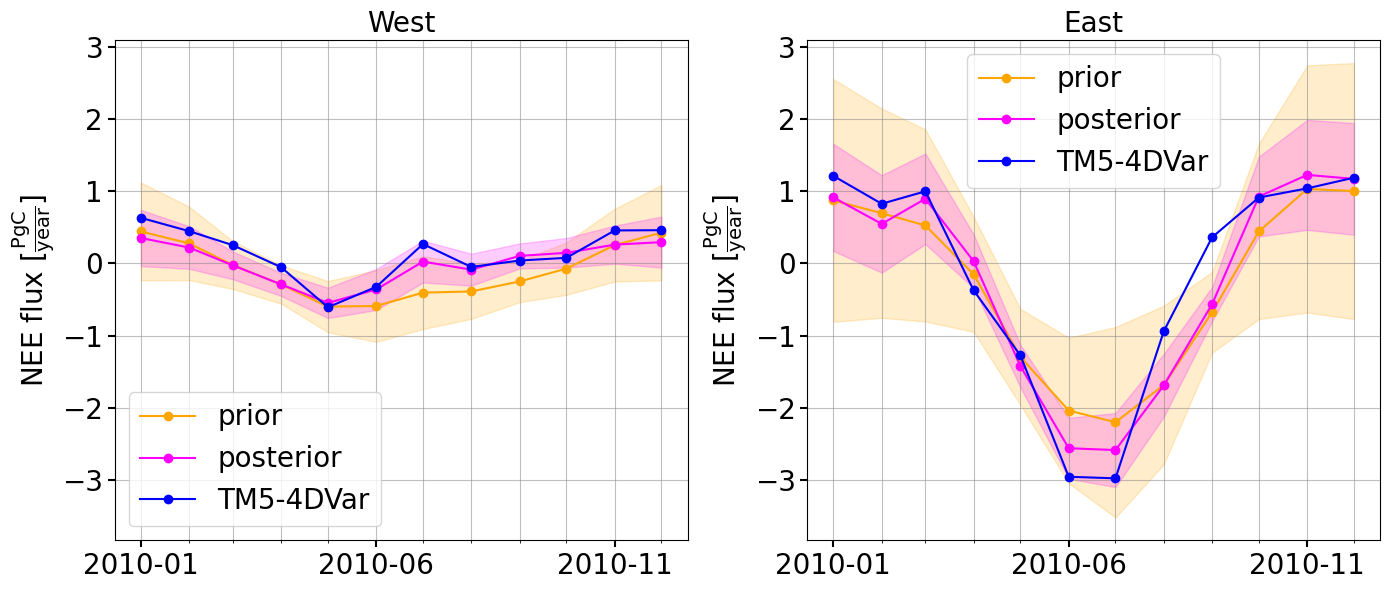

In [41]:
# weekly east and west mean
# select region and time period
start_date=dt.date(2010,1,1)
end_date=dt.date(2010,12,31)
weekly_west=inv_data.where(west_mask).reindex(time=pd.date_range(start_date, end_date), method='ffill')[['posterior_NEE', 'TM5_posterior_std','prior_NEE', 'prior_uncertainty', 'grid_cell_area']]
weekly_east=inv_data.where(east_mask).reindex(time=pd.date_range(start_date, end_date), method='ffill')[['posterior_NEE', 'TM5_posterior_std','prior_NEE', 'prior_uncertainty', 'grid_cell_area']]
monthly_east_ref=ref_monthly_2x2.where(east_mask).reindex(time=pd.date_range(start_date, end_date), method='ffill')[['CO2_flux_nee', 'grid_cell_area']]
monthly_west_ref=ref_monthly_2x2.where(west_mask).reindex(time=pd.date_range(start_date, end_date), method='ffill')[['CO2_flux_nee', 'grid_cell_area']]


# fluxes in # kg/m^2/s
# flux*area, sum over area
# *60*60*24 and sum over month (1/s -> 1/month)
# kg CO2 *12/44*1e-12-> PgC
for col in ['posterior_NEE','prior_NEE','TM5_posterior_std','prior_uncertainty']:
    monthly_west[col]=(weekly_west[col]*weekly_west.grid_cell_area).sum(dim=['latitude','longitude']).resample(time='MS').sum()*60*60*24*12/44*1e-12*12
    monthly_east[col]=(weekly_east[col]*weekly_east.grid_cell_area).sum(dim=['latitude','longitude']).resample(time='MS').sum()*60*60*24*12/44*1e-12*12
# for col in ['TM5_posterior_std','prior_uncertainty']:
#     monthly_west[col]=(weekly_west[col]*weekly_west.grid_cell_area).sum(dim=['latitude','longitude']).resample(time='MS').sum()*60*60*24*12/44*1e-12*12
#     monthly_east[col]=(weekly_east[col]*weekly_east.grid_cell_area).sum(dim=['latitude','longitude']).resample(time='MS').sum()*60*60*24*12/44*1e-12*12


# for ref
monthly_east_ref['CO2_flux_nee']=(monthly_east_ref['CO2_flux_nee']*monthly_east_ref.grid_cell_area).sum(dim=['latitude','longitude'])*60*60*24*12/44*1e-12*12
monthly_west_ref['CO2_flux_nee']=(monthly_west_ref['CO2_flux_nee']*monthly_west_ref.grid_cell_area).sum(dim=['latitude','longitude'])*60*60*24*12/44*1e-12*12
monthly_east_ref=monthly_east_ref.resample(time='MS').sum()
monthly_west_ref=monthly_west_ref.resample(time='MS').sum()

# plot east on the eight, west on the left
# weekly, monthly and reference
WITH_WEEKLY=False

fig, ax=plt.subplots(1,2,figsize=(14,6), sharey=True)
ax=ax.flatten()
ax[1].plot(monthly_east.time, monthly_east.prior_NEE,marker='o', color='orange', label='prior')         #+ np.timedelta64(14, 'D')
ax[0].plot(monthly_west.time, monthly_west.prior_NEE,marker='o', color='orange', label='prior')         #+ np.timedelta64(14, 'D')
ax[1].plot(monthly_east.time, monthly_east.posterior_NEE,marker='o', color='magenta', label='posterior')         #+ np.timedelta64(14, 'D')
ax[0].plot(monthly_west.time, monthly_west.posterior_NEE,marker='o', color='magenta', label='posterior')         #+ np.timedelta64(14, 'D')
# plot std range
ax[1].fill_between(monthly_east.time, monthly_east.prior_NEE-monthly_east.prior_uncertainty, monthly_east.prior_NEE+monthly_east.prior_uncertainty, color='orange', alpha=0.2)         #+ np.timedelta64(14, 'D')
ax[0].fill_between(monthly_west.time, monthly_west.prior_NEE-monthly_west.prior_uncertainty, monthly_west.prior_NEE+monthly_west.prior_uncertainty, color='orange', alpha=0.2)         #+ np.timedelta64(14, 'D')
ax[1].fill_between(monthly_east.time, monthly_east.posterior_NEE-monthly_east.TM5_posterior_std, monthly_east.posterior_NEE+monthly_east.TM5_posterior_std, color='magenta', alpha=0.2)         #+ np.timedelta64(14, 'D')
ax[0].fill_between(monthly_west.time, monthly_west.posterior_NEE-monthly_west.TM5_posterior_std, monthly_west.posterior_NEE+monthly_west.TM5_posterior_std, color='magenta', alpha=0.2)         #+ np.timedelta64(14, 'D')



if WITH_WEEKLY:
    ax[1].plot(weekly_east.time, weekly_east.posterior_NEE, linestyle='--', color='pink')
    ax[0].plot(weekly_west.time, weekly_west.posterior_NEE,linestyle='--', color='pink')
# plot refence
ax[1].plot(monthly_east_ref.time, monthly_east_ref.CO2_flux_nee,marker='o', color='b', label='TM5-4DVar')            #+ np.timedelta64(14, 'D')
ax[0].plot(monthly_west_ref.time, monthly_west_ref.CO2_flux_nee,marker='o', color='b', label='TM5-4DVar')            #+ np.timedelta64(14, 'D')
ax[0].set_title('West',fontsize=20)
ax[1].set_title('East',fontsize=20)

for i in range(len(ax)):
    ax[i].grid()
    ax[i].set_ylabel(r'NEE flux [$\mathrm{\frac{PgC}{year}}$]',fontsize=20)
    ax[i].legend(fontsize=20)
    # ax[i].set_xlim(dt.date(2010,1,1), dt.date(2011,1,1))
    ax[i].tick_params(labelleft=True, labelsize=20)
    ax[i].legend(fontsize=20)  
    ax[i].grid(which='both', c='grey', alpha=0.5)
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,5)))
    ax[i].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax[i].tick_params(axis='both', which='major', labelsize=20, width=1.5, length=5)
fig.tight_layout()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Results/east_west_NEE_mean.png', dpi=300, bbox_inches='tight')

In [46]:
# get posterior error reduction
# sum(sigma_prior-sigma_post)/sum(sigma_prior)

# east
per_east=(monthly_east.prior_uncertainty-monthly_east.TM5_posterior_std).sum()/monthly_east.prior_uncertainty.sum()
print('east', per_east.item())

# west
per_west=(monthly_west.prior_uncertainty-monthly_west.TM5_posterior_std).sum()/monthly_west.prior_uncertainty.sum()
print('west', per_west.item())

east 0.5616264861343607
west 0.4309693552362587


# Appendix

## A.1 Weekly and monthly posterior flux example with correlation

saved to: /work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/correlation/flux_timeseries_example_surrounding_43-93_monthly.png


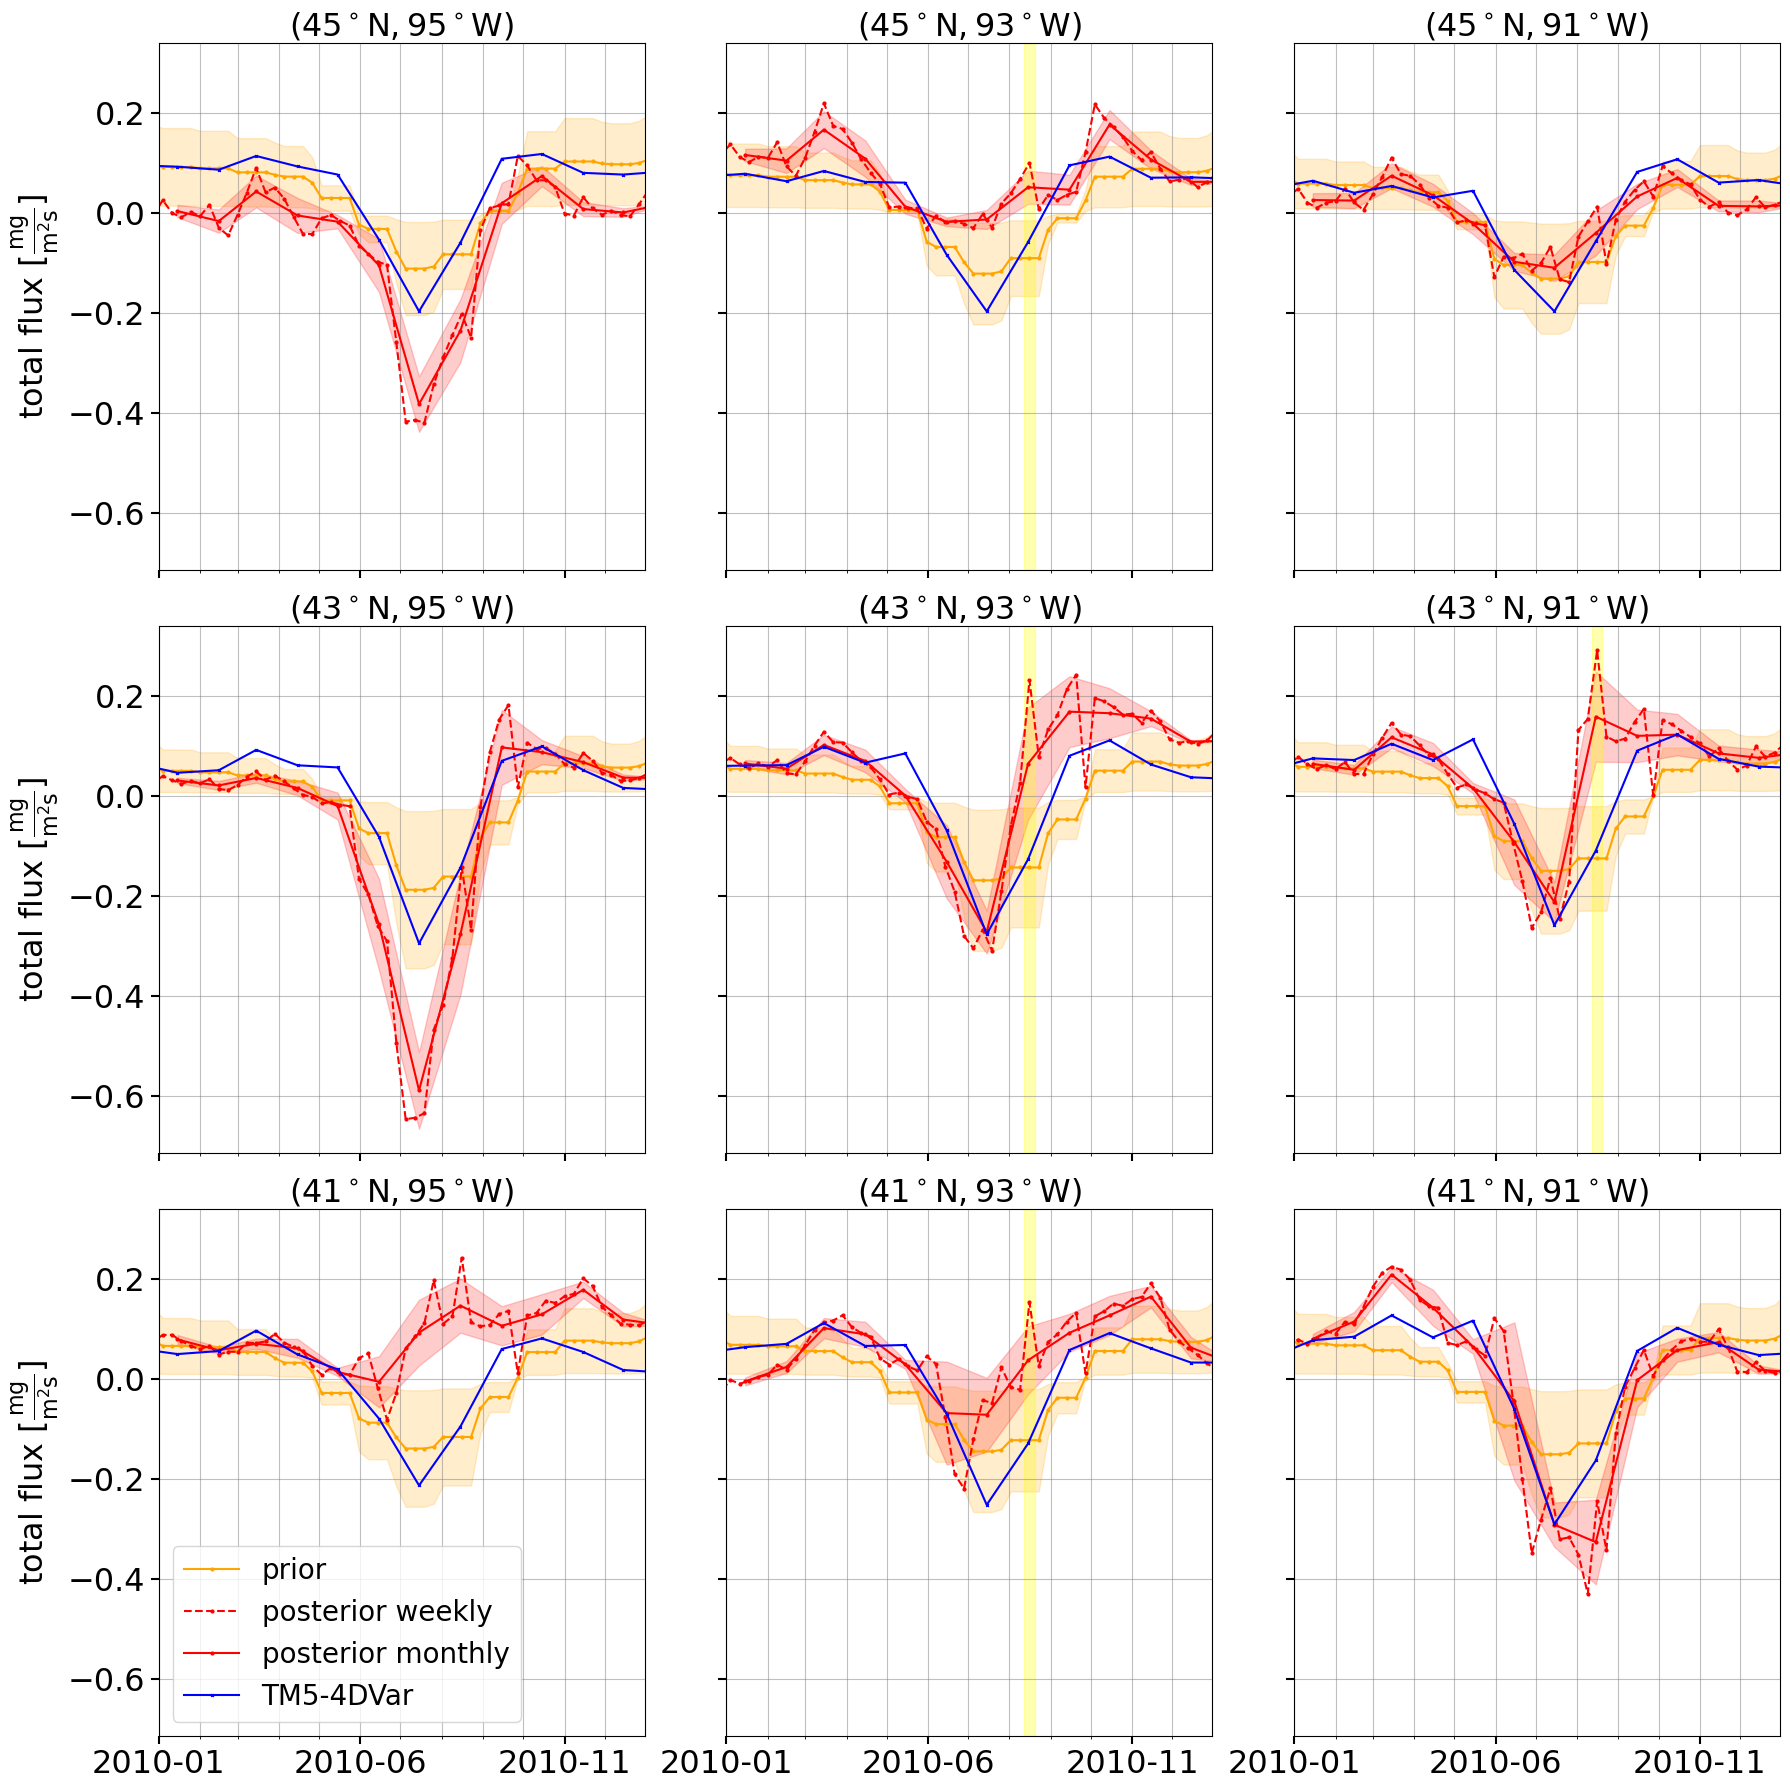

In [ ]:
# plot example and surroundings cells

# read data
bg_str = 'RemoTeC_2.4.0+IS'
gosat_err_val=1
meas_err_val=2
data_dir=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/no_correlation/footprint_spec001_mr/{gosat_err_val}ppm_gosat_meas_err/{meas_err_val}ppm_insitu_meas_err/'
data=xr.open_dataset(f'{data_dir}/20091001-20110331_{bg_str}_bg.nc').sel(latitude=slice(20,48), longitude=slice(-123,-73))
corr_data=xr.open_dataset(f'{data_dir.replace("no_corr", "with_corr")}/20091001-20110331_{bg_str}_bg.nc').sel(latitude=slice(20,48), longitude=slice(-123,-73))
# read reference
ref_flux_2x2=xr.open_dataset(f'/work/bb1170/RUN/b382762/data/TM5Inversion/glb3x2_20220413_new_gridded_flux/flux_2x2_{bg_str}_cut.nc').sel(latitude=slice(20,48), longitude=slice(-123,-73))
# get monthly mean
corr_data_monthly= corr_data.reindex(time=pd.date_range(dt.date(2010,1,1) ,dt.date(2011,1,1)), method='ffill')
corr_data_monthly_std=corr_data_monthly.resample(time='MS').std() # resample to monthly mean
corr_data_monthly=corr_data_monthly.resample(time='MS').mean() # resample to monthly mean

lat_mid=43
lon_mid=-93
lat_lon_list=[(lat, lon) for lat in [lat_mid-2,lat_mid,lat_mid+2] for lon in [lon_mid+2,lon_mid,lon_mid-2]]

# sort by latitude descending, longitude ascending
lat_lon_list=sorted(lat_lon_list, key=lambda x: (-x[0], x[1]))
# plot overview
fig, ax=plt.subplots(3, 3, figsize=(3*6, 3*6), sharey=True, sharex=True)
ax=ax.flatten()
# marker size
ms=2
for i in range(0, len(lat_lon_list)):
    lat_sel, lon_sel =lat_lon_list[i]
    ref_flux_2x2_sel=ref_flux_2x2.sel(latitude=lat_sel, longitude=lon_sel)*1e6
    data_sel=data.sel(latitude=lat_sel, longitude=lon_sel)*1e6
    corr_data_sel=corr_data.sel(latitude=lat_sel, longitude=lon_sel)*1e6
    corr_data_monthly_sel=corr_data_monthly.sel(latitude=lat_sel, longitude=lon_sel)*1e6
    corr_data_monthly_std_sel=corr_data_monthly_std.sel(latitude=lat_sel, longitude=lon_sel)*1e6
    # get monthly 
    
    # plot prior
    ax[i].plot(data_sel.time, data_sel.TM5_prior_flux, c='orange', marker='o', markersize=ms, label='prior')
    ax[i].fill_between(data_sel.time, data_sel.TM5_prior_flux-data_sel.prior_uncertainty, data_sel.TM5_prior_flux+data_sel.prior_uncertainty, color='orange', alpha=0.2)        
    # plot posterior
    # ax[i].plot(data_sel.time, data_sel.TM5_posterior_flux, c='brown', marker='o', markersize=ms, label='posterior no correlation')
    # with correlation
    # ax[i].plot(corr_data_sel.time, corr_data_sel.TM5_posterior_flux, c='r', marker='o', markersize=ms,linestyle='--', label='posterior with correlation')
    ax[i].plot(corr_data_sel.time, corr_data_sel.TM5_posterior_flux, c='r', marker='o', markersize=ms,linestyle='--', label='posterior weekly')
    # ax[i].fill_between(corr_data_sel.time, corr_data_sel.TM5_posterior_flux-corr_data_sel.TM5_posterior_std, corr_data_sel.TM5_posterior_flux+corr_data_sel.TM5_posterior_std, color='r', alpha=0.2)        
    
    # plot monthly 
    ax[i].plot(corr_data_monthly_sel.time+np.timedelta64(14, 'D'), corr_data_monthly_sel.TM5_posterior_flux, c='r', marker='o', markersize=ms, label='posterior monthly')
    ax[i].fill_between(corr_data_monthly_sel.time+np.timedelta64(14, 'D'), corr_data_monthly_sel.TM5_posterior_flux-corr_data_monthly_std_sel.TM5_posterior_flux, corr_data_monthly_sel.TM5_posterior_flux+corr_data_monthly_std_sel.TM5_posterior_flux, color='red', alpha=0.2)        
    
    # plot reference flux
    ax[i].plot(ref_flux_2x2_sel.time+np.timedelta64(14, 'D'), ref_flux_2x2_sel.total_flux,c='b', marker='x',linestyle='-', markersize=ms, label='TM5-4DVar')
    
    # ax[i].legend(fontsize='large')
    ax[i].set_title(fr'$( {lat_sel}^\circ \mathrm{{N}}, {-lon_sel}^\circ\mathrm{{W}})$', fontsize=23)
    ax[i].set_xlim(dt.date(2010,1,1), dt.date(2010,12,31))
    # ax[i].tick_params(labelleft=True)
    # ax[i].set_ylim(-8e-7, 4e-7)
    
    # You can change the step of range() as you prefer (now, it selects each third month) 
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,5)))
    ax[i].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax[i].grid(which='both', c='grey', alpha=0.5)
    # ax[i].tick_params(labelsize=23)
    ax[i].tick_params(axis='both', which='major', labelsize=23, width=1.5, length=6)
for i in [1,4,5,7]:
    ax[i].axvspan(dt.date(2010,8,12), dt.date(2010,8,20), color='yellow', alpha=0.3)
for i in [0,3,6]:
    ax[i].set_ylabel(r'total flux [$\mathrm{\frac{mg}{m^2 s}}$]', fontsize=23)
# title_str=f'Total 2x2 flux, with/without correlation,no diurnal cycle,{gosat_err_val}pp gosat meas err, {meas_err_val}ppm measurement error'
# fig.suptitle(title_str)
# fig.tight_layout(rect=[0, 0., 1, 0.98])
fig.tight_layout()
ax[6].legend(fontsize=20)
spath_fig=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/Inv_setup/correlation/flux_timeseries_example_surrounding_{lat_mid}{lon_mid}_monthly.png'
fig.savefig(spath_fig)
print(f'saved to: {spath_fig}')
# plt.close()

## A.2 plot all posterior fluxes, 4x7 per page

In [4]:
# read data
bg_str = 'RemoTeC_2.4.0+IS'
gosat_err_val=1
meas_err_val=2
res=2
ref_flux=xr.open_dataset(f'/work/bb1170/RUN/b382762/data/TM5Inversion/glb3x2_20220413_new_gridded_flux/flux_{res}x{res}_{bg_str}_cut.nc')
start_date=dt.date(2009,10,1)
end_date=dt.date(2011,3,31)

ms=5 # plot marker size

f_str= 'spec001_mr'
corr_str='no'
data_dir=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/{res}x{res}/{corr_str}_correlation/footprint_{f_str}/{gosat_err_val}ppm_gosat_meas_err/{meas_err_val}ppm_insitu_meas_err/'
inv_data_no_corr=xr.open_dataset(f'{data_dir}/{start_date.strftime("%Y%m%d")}-{end_date.strftime("%Y%m%d")}_{bg_str}_bg.nc')

corr_str='with'
data_dir=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/{res}x{res}/{corr_str}_correlation/footprint_{f_str}/{gosat_err_val}ppm_gosat_meas_err/{meas_err_val}ppm_insitu_meas_err/'
inv_data_with_corr=xr.open_dataset(f'{data_dir}/{start_date.strftime("%Y%m%d")}-{end_date.strftime("%Y%m%d")}_{bg_str}_bg.nc')

f_str='spec001_mr_scaled'
data_dir=f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/{res}x{res}/{corr_str}_correlation/footprint_{f_str}/{gosat_err_val}ppm_gosat_meas_err/{meas_err_val}ppm_insitu_meas_err/'
inv_data_with_scaling=xr.open_dataset(f'{data_dir}/{start_date.strftime("%Y%m%d")}-{end_date.strftime("%Y%m%d")}_{bg_str}_bg.nc')
inv_data_with_scaling

<xarray.Dataset> Size: 5MB
Dimensions:                     (time: 80, latitude: 22, longitude: 36,
                                 meas_num: 20209)
Coordinates:
  * time                        (time) datetime64[ns] 640B 2009-09-21 ... 201...
  * latitude                    (latitude) float32 88B 13.0 15.0 ... 53.0 55.0
  * longitude                   (longitude) float32 144B -133.0 -131.0 ... -63.0
    height                      float32 4B ...
  * meas_num                    (meas_num) int64 162kB 0 1 2 ... 20207 20208
Data variables:
    flat_prior_flux             (time, latitude, longitude) float64 507kB ...
    TM5_prior_flux              (time, latitude, longitude) float64 507kB ...
    prior_uncertainty           (time, latitude, longitude) float64 507kB ...
    flat_posterior_flux         (time, latitude, longitude) float64 507kB ...
    flat_posterior_std          (time, latitude, longitude) float64 507kB ...
    flat_averaging_kernel_diag  (time, latitude, longitude) float64 507kB ...
    TM5_posterior_flux          (time, latitude, longitude) float64 507kB ...
    TM5_posterior_std           (time, latitude, longitude) float64 507kB ...
    TM5_averaging_kernel_diag   (time, latitude, longitude) float64 507kB ...
    meas                        (meas_num) float64 162kB ...
    meas_cov                    (meas_num) float64 162kB ...

In [24]:
n_rows=7
n_cols=4
lat_top=47-14
# lon_left=-125
# only use min and max error value, all other located in between
# for lon_left in np.arange(-125, -70, step=8):
for lon_left in [-101]:
    fig,ax=plt.subplots(n_rows, n_cols, figsize=(10*n_cols,7*n_rows), sharex=True, sharey=True)
    for i in range(0,n_rows):      #, (31, -97)
        lat_sel=lat_top-2*i
        for j in range(0,n_cols):
            lon_sel=lon_left+2*j
            # read ref flux
            # replace 29/-117 mit 33/-119
            if not (lat_sel,lon_sel)==(29,-117):            
                ref_flux_sel=ref_flux.sel(latitude=lat_sel, longitude=lon_sel)*1e6
                inv_data_no_corr_sel=inv_data_no_corr.sel(latitude=lat_sel, longitude=lon_sel)*1e6
                inv_data_with_corr_sel=inv_data_with_corr.sel(latitude=lat_sel, longitude=lon_sel)*1e6
                inv_data_with_scaling_sel=inv_data_with_scaling.sel(latitude=lat_sel, longitude=lon_sel)*1e6

                # plot just once prior
                # fluxes
                ax[i][j].plot(inv_data_no_corr_sel.time, inv_data_no_corr_sel.TM5_prior_flux, c='orange',marker='o',markersize=ms, label='prior')
                ax[i][j].fill_between(inv_data_no_corr_sel.time, inv_data_no_corr_sel.TM5_prior_flux-inv_data_no_corr_sel.prior_uncertainty, inv_data_no_corr_sel.TM5_prior_flux+inv_data_no_corr_sel.prior_uncertainty, color='orange', alpha=0.2)

                # plot posterior fluxes
                # no correlation
                ax[i][j].plot(inv_data_no_corr_sel.time, inv_data_no_corr_sel.TM5_posterior_flux, c='brown', marker='^', markersize=ms, label=fr'no correlation')
                ax[i][j].fill_between(inv_data_no_corr_sel.time, inv_data_no_corr_sel.TM5_posterior_flux-inv_data_no_corr_sel.TM5_posterior_std, inv_data_no_corr_sel.TM5_posterior_flux+inv_data_no_corr_sel.TM5_posterior_std, color='brown', alpha=0.1)
                # with correlation
                ax[i][j].plot(inv_data_with_corr_sel.time, inv_data_with_corr_sel.TM5_posterior_flux, c='red', marker='v', markersize=ms, label=fr'with correlation')
                ax[i][j].fill_between(inv_data_with_corr_sel.time, inv_data_with_corr_sel.TM5_posterior_flux-inv_data_with_corr_sel.TM5_posterior_std, inv_data_with_corr_sel.TM5_posterior_flux+inv_data_with_corr_sel.TM5_posterior_std, color='red', alpha=0.1)

                # with scaling
                ax[i][j].plot(inv_data_with_scaling_sel.time, inv_data_with_scaling_sel.TM5_posterior_flux, c='magenta', marker='s', markersize=ms, label=fr'with correlation and diurnal cycle')
                ax[i][j].fill_between(inv_data_with_scaling_sel.time, inv_data_with_scaling_sel.TM5_posterior_flux-inv_data_with_scaling_sel.TM5_posterior_std, inv_data_with_scaling_sel.TM5_posterior_flux+inv_data_with_scaling_sel.TM5_posterior_std, color='magenta', alpha=0.1)
                
                # plot reference
                ax[i][j].plot(ref_flux_sel.time, ref_flux_sel.total_flux,c='b', marker='x', markersize=ms, label='TM5-4DVar')
                ax[i][j].set_ylabel('')
                    # ax[i][j].hlines(0,dt.date(2010,1,1), dt.date(2010,12,31), color='black')
                # ax.set_ylim(-0.2,0.2)
                ax[i][j].set_title(fr'${lat_sel}^\circ \mathrm{{N}}/{-lon_sel}^\circ\mathrm{{W}}$', fontsize=30)
                ax[i][j].set_xlim(dt.date(2010,1,1), dt.date(2010,12,31))
                ax[i][j].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))
                ax[i][j].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
                ax[i][j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                ax[i][j].tick_params(labelleft=True, labelsize=30)
                ax[i][j].grid(which='both', c='grey', alpha=0.5)
                # ax[i][j].set_ylim(-0.8,0.55)
        ax[i][0].set_ylabel(r'total flux [$\mathrm{\frac{mg}{m^2 s}}$]', fontsize=30)
    # replace 29/-117 mit 33/-119
    if (lat_top, lon_left)==(33,-117): 
        lat_sel,lon_sel = 33, -119
        ax[2][0].set_title(fr'${lat_sel}^\circ \mathrm{{N}}/{-lon_sel}^\circ\mathrm{{W}}$',backgroundcolor= 'yellow', fontsize=30)
        ref_flux_sel=ref_flux.sel(latitude=lat_sel, longitude=lon_sel)*1e6
        inv_data_no_corr_sel=inv_data_no_corr.sel(latitude=lat_sel, longitude=lon_sel)*1e6
        inv_data_with_corr_sel=inv_data_with_corr.sel(latitude=lat_sel, longitude=lon_sel)*1e6
        inv_data_with_scaling_sel=inv_data_with_scaling.sel(latitude=lat_sel, longitude=lon_sel)*1e6

        # plot just once prior
        # fluxes
        ax[2][0].plot(inv_data_no_corr_sel.time, inv_data_no_corr_sel.TM5_prior_flux, c='orange',marker='o',markersize=ms, label='prior')
        ax[2][0].fill_between(inv_data_no_corr_sel.time, inv_data_no_corr_sel.TM5_prior_flux-inv_data_no_corr_sel.prior_uncertainty, inv_data_no_corr_sel.TM5_prior_flux+inv_data_no_corr_sel.prior_uncertainty, color='orange', alpha=0.2)

        # plot posterior fluxes
        # no correlation
        ax[2][0].plot(inv_data_no_corr_sel.time, inv_data_no_corr_sel.TM5_posterior_flux, c='brown', marker='^', markersize=ms, label=fr'no correlation')
        ax[2][0].fill_between(inv_data_no_corr_sel.time, inv_data_no_corr_sel.TM5_posterior_flux-inv_data_no_corr_sel.TM5_posterior_std, inv_data_no_corr_sel.TM5_posterior_flux+inv_data_no_corr_sel.TM5_posterior_std, color='brown', alpha=0.1)
        # with correlation
        ax[2][0].plot(inv_data_with_corr_sel.time, inv_data_with_corr_sel.TM5_posterior_flux, c='red', marker='v', markersize=ms, label=fr'with correlation')
        ax[2][0].fill_between(inv_data_with_corr_sel.time, inv_data_with_corr_sel.TM5_posterior_flux-inv_data_with_corr_sel.TM5_posterior_std, inv_data_with_corr_sel.TM5_posterior_flux+inv_data_with_corr_sel.TM5_posterior_std, color='red', alpha=0.1)

        # with scaling
        ax[2][0].plot(inv_data_with_scaling_sel.time, inv_data_with_scaling_sel.TM5_posterior_flux, c='magenta', marker='s', markersize=ms, label=fr'with correlation and diurnal cycle')
        ax[2][0].fill_between(inv_data_with_scaling_sel.time, inv_data_with_scaling_sel.TM5_posterior_flux-inv_data_with_scaling_sel.TM5_posterior_std, inv_data_with_scaling_sel.TM5_posterior_flux+inv_data_with_scaling_sel.TM5_posterior_std, color='magenta', alpha=0.1)
        
        # plot reference
        ax[2][0].plot(ref_flux_sel.time, ref_flux_sel.total_flux,c='b', marker='x', markersize=ms, label='TM5-4DVar')
        ax[2][0].set_ylabel('')
            # ax[2][0].hlines(0,dt.date(2010,1,1), dt.date(2010,12,31), color='black')

        ax[2][0].set_xlim(dt.date(2010,1,1), dt.date(2010,12,31))
        ax[2][0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))
        ax[2][0].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
        ax[2][0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax[2][0].tick_params(labelleft=True, labelsize=30)
        ax[2][0].grid(which='both', c='grey', alpha=0.5)
        ax[2][0].set_ylabel(r'total flux [$\mathrm{\frac{mg}{m^2 s}}$]', fontsize=30)
            
    ax[i][j].legend(fontsize=27)  
    fig.tight_layout()
    fig.savefig(f'/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/appendix/all_fluxes_{lat_top}{lon_left}.png')
    plt.close()

### map with regions for appendix plots

In [2]:
from matplotlib.lines import Line2D
lat_step=2
lon_step=2
interp_region=[20,48,-126,-70]       # lat_min, lat_max, lon_min, lon_max
flexpart_region=[12,56,-134,-62]       # lat_min, lat_max, lon_min, lon_max

lat=np.arange(flexpart_region[0],flexpart_region[1]+lat_step,lat_step)
lon=np.arange(-flexpart_region[2],-flexpart_region[3]-lon_step, -lon_step)

# read boudary file
gdf = geopandas.read_file("/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/inversions/2x2/east_west_region_boundaries.geojson")

geom_inv=[]
for i in range(0,len(lat)-1):
    for j in range(0, len(lon)-1):
        geom_inv.append(Polygon(zip([-lon[j+1],-lon[j],-lon[j],-lon[j+1]],[lat[i+1],lat[i+1],lat[i],lat[i]])))
geom_inv.append(Polygon(zip([interp_region[2],interp_region[3],interp_region[3],interp_region[2]],[interp_region[1],interp_region[1],interp_region[0],interp_region[0]])))
geom_inv.append(Polygon(zip([flexpart_region[2],flexpart_region[3],flexpart_region[3],flexpart_region[2]],[flexpart_region[1],flexpart_region[1],flexpart_region[0],flexpart_region[0]])))
# create gdf
gdf_inv=geopandas.GeoDataFrame({'Region':np.append(np.arange(0,len(geom_inv)-2),['Interp','FLEXPART_meas'])},geometry=geom_inv)

# for plot regions in appendix
plot_regions_lat=np.arange(interp_region[1],interp_region[0]-14,-14)
plot_regions_lon=np.arange(-interp_region[2],-interp_region[3]-8, -8)
plot_regions=[]
plot_regions_str=[]
fig_ind=3
for i in range(0,len(plot_regions_lat)-1):
    for j in range(0, len(plot_regions_lon)-1):
        if not (i==1) & (j in [0,6]):
            plot_regions_str.append([plot_regions_lat[i]-7, -plot_regions_lon[j]+3, f'A.{fig_ind}'])
            fig_ind+=1
            plot_regions.append(Polygon(zip([-plot_regions_lon[j+1],-plot_regions_lon[j],-plot_regions_lon[j],-plot_regions_lon[j+1]],[plot_regions_lat[i+1],plot_regions_lat[i+1],plot_regions_lat[i],plot_regions_lat[i]])))
plot_regions.append(Polygon(zip([-120,-118,-118,-120],[32,32,34,34])))
plot_regions_gdf=geopandas.GeoDataFrame(geometry=plot_regions)
plot_regions_str

[[41, -123, 'A.3'],
 [41, -115, 'A.4'],
 [41, -107, 'A.5'],
 [41, -99, 'A.6'],
 [41, -91, 'A.7'],
 [41, -83, 'A.8'],
 [41, -75, 'A.9'],
 [27, -115, 'A.10'],
 [27, -107, 'A.11'],
 [27, -99, 'A.12'],
 [27, -91, 'A.13'],
 [27, -83, 'A.14']]

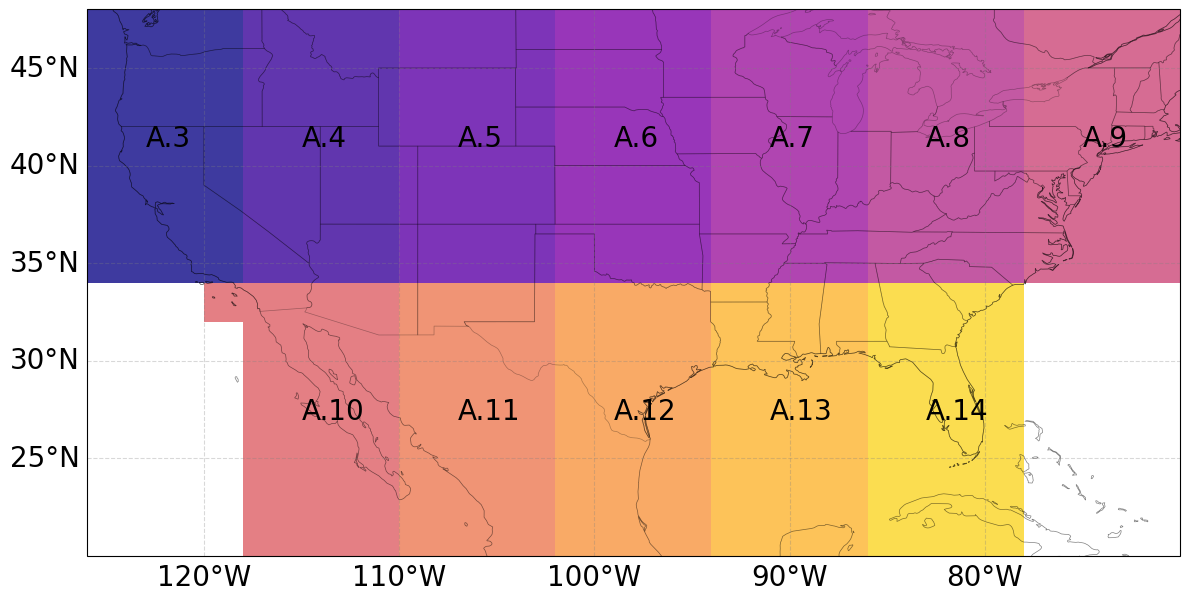

In [3]:
# list of color from colormap
cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, plot_regions_gdf.size))

fig, ax = plt.subplots(figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})
# plot gridboxes
# gdf_inv[:-2].boundary.plot(ax=ax,alpha=0.1, color='grey')         # , label='inversion boxes'
# gdf_inv[-2:-1].plot(ax=ax, color='darkorange', alpha=0.1)
# gdf_inv[-2:-1].boundary.plot(ax=ax, color='darkorange', label='inner domain')
for i in range(0,plot_regions_gdf.size-1):
    plot_regions_gdf[i:i+1].plot(ax=ax, color=colors[i], alpha=0.8)
plot_regions_gdf[-1:].plot(ax=ax, color=colors[7], alpha=0.8)

# for _, row in gdf.iterrows():
#     ax.plot(*row.geometry.exterior.xy,transform=ccrs.PlateCarree(),color='brown', linewidth=1) # just for boundaries
    # ax.add_geometries([row.geometry],crs=ccrs.PlateCarree(),facecolor='peru',edgecolor='brown',linewidth=1)

# Add coastlines
ax.coastlines(linewidth=0.5, alpha=0.5)
# ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
# Add U.S. state borders
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5,alpha=0.3)
gl = ax.gridlines(draw_labels=True,color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
# gl.set_ylabel
gl.ylabel_style = {'size': 20}
ax.set_xlim([-126,-70])
ax.set_ylim([20,48])
# ax.set_xlim([-134,-62])
# ax.set_ylim([12,56])
ax.grid(c='lightgrey')
# ax.set_title(f'{lon_step}°x{lat_step}°')

# Add a custom line to the legend
# custom_line = Line2D([0], [0], color='brown', lw=1, label='east & west region')
# custom_line2 = Line2D([0], [0], color='grey', lw=1, label='buffer zone')

# Add the custom line to the existing legend
# plt.legend(handles=[*ax.get_legend_handles_labels()[0], custom_line,custom_line2],handlelength=1, fontsize=20,bbox_to_anchor=(1.01, 1))

for i in range(len(plot_regions_str)):
    ax.text(plot_regions_str[i][1],plot_regions_str[i][0],plot_regions_str[i][2], fontsize=20)

# ax.legend()
fig.tight_layout()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/appendix/flux_region_map.png', dpi=300, bbox_inches='tight')

## A.3 Modeled measurement values with larger measurement differences

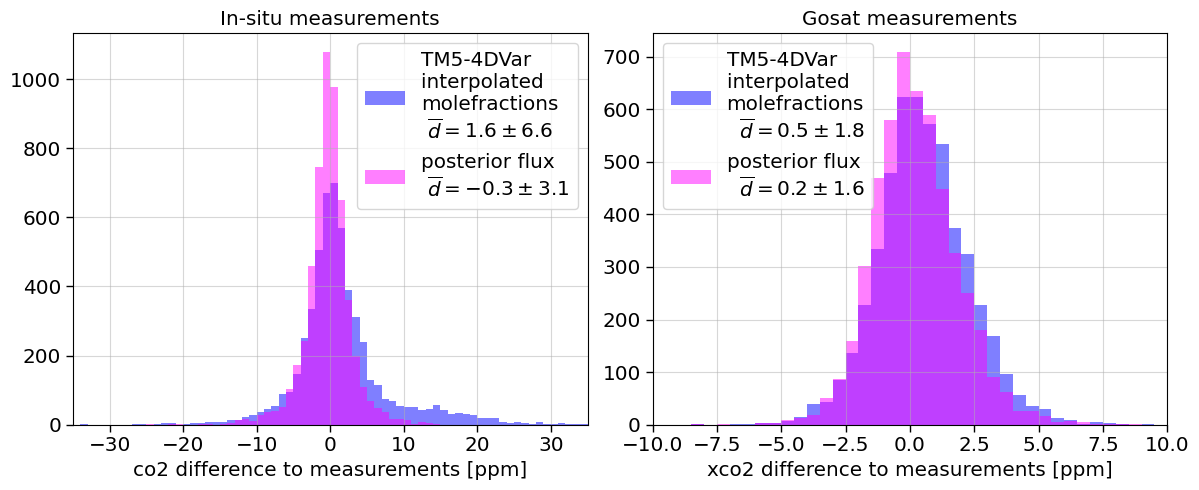

In [ ]:
# temp, same for larger is error
large_is_err=4

# read meas data
gosat_data_large=xr.open_dataset(f'{data_dir.replace("2ppm_insitu_meas_err",f"{large_is_err}ppm_insitu_meas_err")}/gosat_data_2x2_20091001-20110331_RemoTeC_2.4.0+IS_bg.nc')
is_data_large=xr.open_dataset(f'{data_dir.replace("2ppm_insitu_meas_err",f"{large_is_err}ppm_insitu_meas_err")}/insitu_data_2x2_20091001-20110331_RemoTeC_2.4.0+IS_bg.nc')

# 20,48,-126,-70
# select measurements during 2010, in inner region
gosat_data_large_inner=gosat_data_large.where((gosat_data_large.release_lat>=interp_region[0])&(gosat_data_large.release_lat<=interp_region[1]) & (gosat_data_large.release_lon>=interp_region[2])&(gosat_data_large.release_lon<=interp_region[3]) & (gosat_data_large.release_time.dt.year==2010), drop=True)
is_data_large_inner=is_data_large.where((is_data_large.release_lat>=interp_region[0])&(is_data_large.release_lat<=interp_region[1]) & (is_data_large.release_lon>=interp_region[2])&(is_data_large.release_lon<=interp_region[3]) & (is_data_large.release_time.dt.year==2010), drop=True)
# is_data_large_inner

# set bins manually
gosat_bins=np.arange(-15, 15, step=0.5)
insitu_bins=np.arange(-40, 40, step=1)

WITH_PRIOR=False

# plot
fig, ax=plt.subplots(1,2,figsize=(12,5))
ax[0].hist(is_data_large_inner.TM5_molefrac_diff_interpolated, insitu_bins,color='blue',alpha=0.5,  
           label=fr'TM5-4DVar''\n' 'interpolated ''\n' 'molefractions''\n' fr' $\overline{{d}}={np.round((is_data_large_inner.TM5_molefrac_diff_interpolated.mean()).item(),1)}\pm{np.round(is_data_large_inner.TM5_molefrac_diff_interpolated.std().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(is_data_large_inner.TM5_molefrac_diff_interpolated)).item(),1)}$')
if WITH_PRIOR:
    ax[0].hist(is_data_large_inner.prior_diff, insitu_bins, color='orange', alpha=0.5,  label=fr'prior flux''\n' fr' $\overline{{d}}={np.round((is_data_large_inner.prior_diff.mean()).item(),1)}\pm{np.round(is_data_large_inner.prior_diff.std().item(),1)}$')# , \overline{{|d|}}={np.round(np.mean(np.abs(is_data_large_inner.prior_diff)).item(),1)}$')
ax[0].hist(is_data_large_inner.posterior_diff, insitu_bins, color='magenta', alpha=0.5,  
           label=fr'posterior flux''\n' fr' $\overline{{d}}={np.round((is_data_large_inner.posterior_diff.mean()).item(),1)}\pm{np.round(is_data_large_inner.posterior_diff.std().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(is_data_large_inner.posterior_diff)).item(),1)}$')
ax[0].set_xlabel('co2 difference to measurements [ppm]', fontsize='x-large')
ax[1].hist(gosat_data_large_inner.TM5_molefrac_diff_interpolated, gosat_bins,color='blue',alpha=0.5,  
           label=fr'TM5-4DVar''\n' 'interpolated ''\n' 'molefractions''\n' fr'  $\overline{{d}}={np.round((gosat_data_large_inner.TM5_molefrac_diff_interpolated.mean()).item(),1)}\pm{np.round(gosat_data_large_inner.TM5_molefrac_diff_interpolated.std().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(gosat_data_large_inner.TM5_molefrac_diff_interpolated)).item(),1)}$')
if WITH_PRIOR:
    ax[1].hist(gosat_data_large_inner.prior_diff, gosat_bins, color='orange', alpha=0.5,  label=fr'prior flux''\n' fr'  $\overline{{d}}={np.round((gosat_data_large_inner.prior_diff.mean()).item(),1)}\pm{np.round(gosat_data_large_inner.prior_diff.std().item(),1)}$')# , \overline{{|d|}}={np.round(np.mean(np.abs(gosat_data_large_inner.prior_diff)).item(),1)}$')    
ax[1].hist(gosat_data_large_inner.posterior_diff, gosat_bins, color='magenta', alpha=0.5,  
           label=fr'posterior flux''\n' fr'  $\overline{{d}}={np.round((gosat_data_large_inner.posterior_diff.mean()).item(),1)}\pm{np.round(gosat_data_large_inner.posterior_diff.std().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(gosat_data_large_inner.posterior_diff)).item(),1)}$')
ax[1].set_xlabel('xco2 difference to measurements [ppm]', fontsize='x-large')
ax[0].set_title(f'In-situ measurements', fontsize='x-large')  #, n={is_data_large_inner.pointspec.size}')
ax[1].set_title(f'Gosat measurements', fontsize='x-large')   #, n={gosat_data_large_inner.pointspec.size}')
for i in range(0,len(ax)):
    ax[i].grid(alpha=0.5)
    ax[i].legend(fontsize='x-large')  #fontsize='small'
    ax[i].tick_params(axis='both', which='both', labelsize='x-large', width=1, length=5)
ax[0].set_xlim(-35,35)
ax[1].set_xlim(-10,10)
fig.tight_layout()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/appendix/posterior_meas_comp_hist_diff_large_is_err.png', dpi=300, bbox_inches='tight')

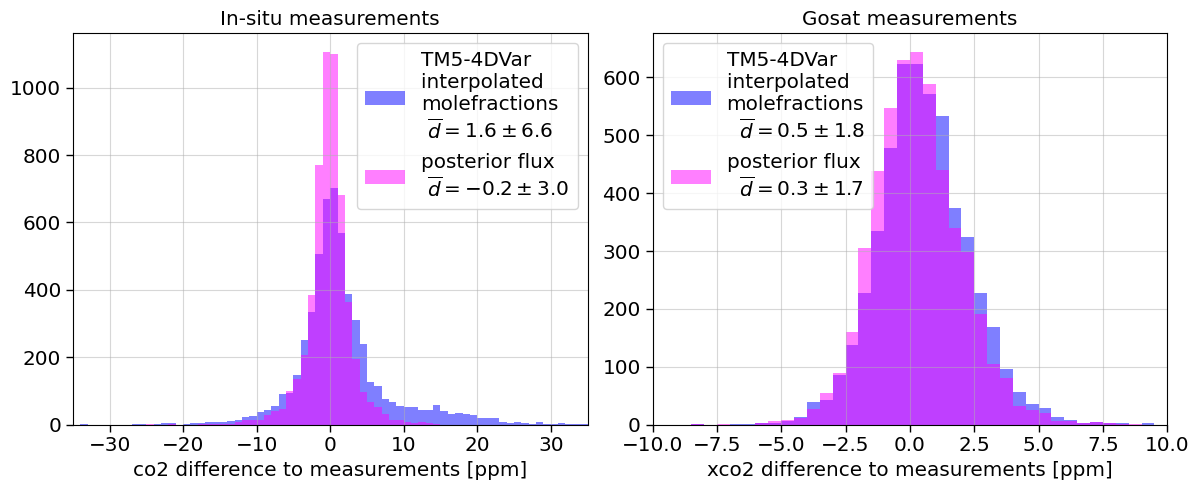

In [ ]:
# temp, same for larger gosat error
large_gosat_err=3

# read meas data
gosat_data_large=xr.open_dataset(f'{data_dir.replace("1ppm_gosat_meas_err",f"{large_gosat_err}ppm_gosat_meas_err")}/gosat_data_2x2_20091001-20110331_RemoTeC_2.4.0+IS_bg.nc')
is_data_large=xr.open_dataset(f'{data_dir.replace("1ppm_gosat_meas_err",f"{large_gosat_err}ppm_gosat_meas_err")}/insitu_data_2x2_20091001-20110331_RemoTeC_2.4.0+IS_bg.nc')


# 20,48,-126,-70
# select measurements during 2010, in inner region
gosat_data_large_inner=gosat_data_large.where((gosat_data_large.release_lat>=interp_region[0])&(gosat_data_large.release_lat<=interp_region[1]) & (gosat_data_large.release_lon>=interp_region[2])&(gosat_data_large.release_lon<=interp_region[3]) & (gosat_data_large.release_time.dt.year==2010), drop=True)
is_data_large_inner=is_data_large.where((is_data_large.release_lat>=interp_region[0])&(is_data_large.release_lat<=interp_region[1]) & (is_data_large.release_lon>=interp_region[2])&(is_data_large.release_lon<=interp_region[3]) & (is_data_large.release_time.dt.year==2010), drop=True)
# is_data_large_inner

# set bins manually
gosat_bins=np.arange(-15, 15, step=0.5)
insitu_bins=np.arange(-40, 40, step=1)

WITH_PRIOR=False

# plot
fig, ax=plt.subplots(1,2,figsize=(12,5))
ax[0].hist(is_data_large_inner.TM5_molefrac_diff_interpolated, insitu_bins,color='blue',alpha=0.5,  
           label=fr'TM5-4DVar''\n' 'interpolated ''\n' 'molefractions''\n' fr' $\overline{{d}}={np.round((is_data_large_inner.TM5_molefrac_diff_interpolated.mean()).item(),1)}\pm{np.round(is_data_large_inner.TM5_molefrac_diff_interpolated.std().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(is_data_large_inner.TM5_molefrac_diff_interpolated)).item(),1)}$')
if WITH_PRIOR:
    ax[0].hist(is_data_large_inner.prior_diff, insitu_bins, color='orange', alpha=0.5,  label=fr'prior flux''\n' fr' $\overline{{d}}={np.round((is_data_large_inner.prior_diff.mean()).item(),1)}\pm{np.round(is_data_large_inner.prior_diff.std().item(),1)}$')# , \overline{{|d|}}={np.round(np.mean(np.abs(is_data_large_inner.prior_diff)).item(),1)}$')
ax[0].hist(is_data_large_inner.posterior_diff, insitu_bins, color='magenta', alpha=0.5,  
           label=fr'posterior flux''\n' fr' $\overline{{d}}={np.round((is_data_large_inner.posterior_diff.mean()).item(),1)}\pm{np.round(is_data_large_inner.posterior_diff.std().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(is_data_large_inner.posterior_diff)).item(),1)}$')
ax[0].set_xlabel('co2 difference to measurements [ppm]', fontsize='x-large')
ax[1].hist(gosat_data_large_inner.TM5_molefrac_diff_interpolated, gosat_bins,color='blue',alpha=0.5,  
           label=fr'TM5-4DVar''\n' 'interpolated ''\n' 'molefractions''\n' fr'  $\overline{{d}}={np.round((gosat_data_large_inner.TM5_molefrac_diff_interpolated.mean()).item(),1)}\pm{np.round(gosat_data_large_inner.TM5_molefrac_diff_interpolated.std().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(gosat_data_large_inner.TM5_molefrac_diff_interpolated)).item(),1)}$')
if WITH_PRIOR:
    ax[1].hist(gosat_data_large_inner.prior_diff, gosat_bins, color='orange', alpha=0.5,  label=fr'prior flux''\n' fr'  $\overline{{d}}={np.round((gosat_data_large_inner.prior_diff.mean()).item(),1)}\pm{np.round(gosat_data_large_inner.prior_diff.std().item(),1)}$')# , \overline{{|d|}}={np.round(np.mean(np.abs(gosat_data_large_inner.prior_diff)).item(),1)}$')    
ax[1].hist(gosat_data_large_inner.posterior_diff, gosat_bins, color='magenta', alpha=0.5,  
           label=fr'posterior flux''\n' fr'  $\overline{{d}}={np.round((gosat_data_large_inner.posterior_diff.mean()).item(),1)}\pm{np.round(gosat_data_large_inner.posterior_diff.std().item(),1)}$')
           # , \overline{{|d|}}={np.round(np.mean(np.abs(gosat_data_large_inner.posterior_diff)).item(),1)}$')
ax[1].set_xlabel('xco2 difference to measurements [ppm]', fontsize='x-large')
ax[0].set_title(f'In-situ measurements', fontsize='x-large')  #, n={is_data_large_inner.pointspec.size}')
ax[1].set_title(f'Gosat measurements', fontsize='x-large')   #, n={gosat_data_large_inner.pointspec.size}')
for i in range(0,len(ax)):
    ax[i].grid(alpha=0.5)
    ax[i].legend(fontsize='x-large')  #fontsize='small'
    ax[i].tick_params(axis='both', which='both', labelsize='x-large', width=1, length=5)
ax[0].set_xlim(-35,35)
ax[1].set_xlim(-10,10)
fig.tight_layout()
fig.savefig('/work/bb1170/RUN/b382762/data/Flexpart11_invSetup_final/MA_plots/appendix/posterior_meas_comp_hist_diff_large_gosat_err.png', dpi=300, bbox_inches='tight')

# end